# Prepare data for training

In [1]:
import tensorflow as tf

import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import ndimage
from pathlib import Path

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

from sklearn.utils import class_weight

import sys
sys.path.append(r"/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/Brain_Mets_Classification")

import brain_mets_classification.custom_funcs as funcs

from tqdm import tqdm

import shutil

import imageio
import cv2

### Imfusion Lables Preparation

export .txt file and convert segmentation masks to unsigned char for ImFusion Label annotations

In [2]:
# move only the fully preprocessed files into new patient folders
path_to_auto_segmented_files = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/segmented_AURORA_n4_20240614-170748")
path_to_all_preprocessed_files = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/preprocessed_n4_brainlesion_percentile_20240612-083743")
path_to_unsigned_segmentations = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/unsigned_segmentations")

path_to_txt_file = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/files_to_segment.txt"

In [3]:
# create txt file that lists all the paths to the preprocessed t1c images and after that separated by a semi-colon the path to the multilabel segmentation

preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

for patient in tqdm(preprocessed_patients):

    # go into perc_normalized dir
    # create new patient dir in path_to_only_preprocessed
    # copy contents
    
    path_to_perc_normalized = path_to_all_preprocessed_files / patient / "perc_normalized"

    t1c_file = [file for file in os.listdir(str(path_to_perc_normalized)) if "t1c" in file][0]
    path_to_t1c_file = path_to_perc_normalized / t1c_file

    path_to_segmentation = path_to_auto_segmented_files / patient
    if not path_to_segmentation.exists():
        print(f"directory {path_to_segmentation} does not exist")
        continue

    multimodal_segmentation_file = [file for file in os.listdir(str(path_to_segmentation)) if "multi-modal" in file][0]
    path_to_multimodal_segmentation_file = path_to_segmentation / multimodal_segmentation_file

    mask = nib.load(path_to_multimodal_segmentation_file)
    data = mask.get_fdata()

    # Convert to unsigned bytes
    data_uint8 = data.astype(np.uint8)

    # Create a new Nifti1Image
    new_img = nib.Nifti1Image(data_uint8, affine = mask.affine)

    new_img.header.set_data_dtype(np.uint8)
    new_img.header['datatype'] = 2  # 2 corresponds to unsigned char in NIfTI format
    new_img.header['bitpix'] = 8  # 8 bits per voxel

    path_to_unsinged_mask = path_to_unsigned_segmentations / multimodal_segmentation_file

    nib.save(new_img, path_to_unsinged_mask)

    f = open(path_to_txt_file, "a")
    f.write(f"{path_to_t1c_file};{path_to_unsinged_mask}\n")
    f.close()

 42%|████▏     | 208/492 [00:06<00:08, 32.55it/s]


KeyboardInterrupt: 

In [13]:
output_file = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/unsigned_segmentations/sub-01009590_multi-modal_segmentation.nii.gz"

img = nib.load(output_file)
print(img.get_data_dtype())  # This should print uint8

uint8


prints patients that have been removed from the training

In [16]:
path_to_tsv = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Dateien/dataset_patients_05_24.tsv"

training_patients = pd.read_csv(path_to_tsv, sep="\t")

patient_ids = training_patients["participant_id"].tolist()
print(patient_ids)

preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

for patient in preprocessed_patients:
    if patient not in patient_ids:
        print(patient)

['sub-01005097', 'sub-01005630', 'sub-01006290', 'sub-01009590', 'sub-01015961', 'sub-01018613', 'sub-01021714', 'sub-01021993', 'sub-01022787', 'sub-01025630', 'sub-01031243', 'sub-01038520', 'sub-01040149', 'sub-01041137', 'sub-01055292', 'sub-01056598', 'sub-01056884', 'sub-01064662', 'sub-01071055', 'sub-01072344', 'sub-01083248', 'sub-01087386', 'sub-01098043', 'sub-01099901', 'sub-01104996', 'sub-01106844', 'sub-01108350', 'sub-01109318', 'sub-01111974', 'sub-01117914', 'sub-01117958', 'sub-01119720', 'sub-01122863', 'sub-01125016', 'sub-01130173', 'sub-01130856', 'sub-01131702', 'sub-01134825', 'sub-01138456', 'sub-01147272', 'sub-01150136', 'sub-01152379', 'sub-01164049', 'sub-01164986', 'sub-01169240', 'sub-01188297', 'sub-01189050', 'sub-01190670', 'sub-01190738', 'sub-01196057', 'sub-01199093', 'sub-01201117', 'sub-01201482', 'sub-01204563', 'sub-01205171', 'sub-01205745', 'sub-01207036', 'sub-01213140', 'sub-01214172', 'sub-01214417', 'sub-01216717', 'sub-01220269', 'sub-01

In [ ]:
import nibabel as nib
import numpy as np

# Load the .nii file
img = nib.load('path_to_your_label.nii')
data = img.get_fdata()

# Convert to unsigned bytes
data_uint8 = data.astype(np.uint8)

# Create a new Nifti1Image
new_img = nib.Nifti1Image(data_uint8, img.affine, img.header)

# Save the new .nii file
nib.save(new_img, 'path_to_your_label_uint8.nii')

In [4]:
# copy preprocessed files into new patient folders
preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

for patient in tqdm(preprocessed_patients):

    # go into perc_normalized dir
    # create new patient dir in path_to_only_preprocessed
    # copy contents
    
    path_to_perc_normalized = path_to_all_preprocessed_files / patient / "perc_normalized"

    path_to_new_patient_folder = path_to_only_preprocessed / patient
    os.mkdir(path_to_new_patient_folder)

    files_to_copy = [file for file in os.listdir(str(path_to_perc_normalized)) if not file.endswith(".nii.gz")]

    for file in files_to_copy:
        shutil.copy(path_to_perc_normalized / file, path_to_new_patient_folder)

## Regensburg

### Clean up data

CAVE: remove patient sub-01383503 from training as the cerebellum is not fully displayed

In [2]:
# set pandas random seed to 42
np.random.seed(42)

In [3]:
#path_to_patients_tsv = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/rawdata/participants.tsv")
#path_to_patients_tsv = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Dateien/dataset_patients_05_24.tsv")
path_to_patients_tsv = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Dateien/participants_04_09_24.tsv")

# old: path_to_preprocessed_images = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/preprocessed_brainlesion_allpatients")
# path_to_preprocessed_images = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/preprocessed_brainlesion_allpatients")
#path_to_preprocessed_images = Path("/Users/LennartPhilipp/Desktop/testing_data/derivatives/preprocessed_n4_brainlesion_percentile_20240611-125716")
path_to_preprocessed_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/preprocessed_n4_brainlesion_percentile_20240612-083743")

Read .tsv file with all the patients

In [4]:
training_patients = pd.read_csv(path_to_patients_tsv, sep="\t", index_col=False)

# drop patient sub-01383503
patient_to_drop_index = training_patients.index[training_patients["participant_id"] == "sub-01383503"]
training_patients.drop(index=patient_to_drop_index, inplace=True)
training_patients.reset_index(drop=True, inplace=True)
#training_patients = training_patients.sample(frac=1) #shuffles the dataset

print(f"Before removing unfit files: {len(training_patients)}")
patient_files_list = os.listdir(path_to_preprocessed_images)
for index, row in training_patients.iterrows():
    if training_patients["participant_id"][index] not in patient_files_list:
        training_patients.drop(index=index, inplace=True)

print(f"After removing unfit files: {len(training_patients)}")
training_patients.reset_index(drop=True, inplace=True)

# shuffle dataset
training_patients = training_patients.sample(frac=1).reset_index(drop=True)

patient_ids = training_patients["participant_id"].tolist()

Before removing unfit files: 472
After removing unfit files: 470


### Unify primary classes

In [ ]:
#copy of cancer_primaries_dict from config.py (22_07_2024)

# cancer_primaries_dict = {   '1a': 'small cell lung cancer',
#                             '1b': 'squamous cell lung cancer',
#                             '1c': 'adenocarcinoma of the lung',
#                             '1d': 'large cell lung cancer',
#                             '1e': 'NSCLC',
#                             '1f': 'lung cancer, other',
#                             '1g': 'lung cancer, exact histology unknown',
#                             '2': 'breast cancer',
#                             '3': 'prostate cancer',
#                             '4': 'testicular cancer',
#                             '5': 'renal cell carcinoma',
#                             '6': 'transitional cell carcinoma', # also called urothelial carcinoma
#                             '7': 'vulvar carcinoma',
#                             '8': 'cervical cancer',
#                             '9': 'endometrial cancer',
#                             '10': 'ovarian cell carcinoma',
#                             '11a': 'osteosarcoma',
#                             '11b': 'liposarcoma',
#                             '11c': 'leiomyosarcoma',
#                             '11d': 'rhabdomyosarcoma',
#                             '11e': 'synovial sarcoma',
#                             '11f': 'solitary fibrous tumor',
#                             '11g': 'sarcoma, other',
#                             '11h': 'sarcoma, exact histology unknown',
#                             '12': 'melanoma',
#                             '13': 'lacrimal gland carcinoma',
#                             '14': 'salivary gland cancer',
#                             '15': 'oral squamous cell carcinoma',
#                             '16': 'adenoid cystic carcinoma',
#                             '17': 'laryngeal cancer',
#                             '18': 'thyroid cancer',
#                             '19': 'esophageal cancer',
#                             '20': 'gastric cancer',
#                             '21': 'pancreatic cancer',
#                             '22': 'cholangiocellular carcinoma',
#                             '23': 'colorectal cancer',
#                             '24': 'NET', # = neuroendocrine tumors
#                             '25': 'MiNEN', # = mixed neuroendocrine non-neuroendocine neuroplasms
#                             '26a': 'DSRCT', # = Desmoplastic small-round-cell Tumor
#                             '26b': 'mesothelioma, other',
#                             '27': 'thymoma',
#                             '28': 'plasmacytoma',
#                             '29': 'cancer of unknown primary'
# }

In [5]:
# primaries are written like this: 1e, 25, 13, 2f, etc., for the full list see config.py
# given a certain amount of classes, e.g. 3:
# create the following classes: lung, melanoma, other
primaries_array_dict = pd.Series(training_patients.primary.values, index=training_patients.participant_id).to_dict()

print("Original Primaries Dict:")
print(primaries_array_dict)
print()

def compress_primaries_dict(primaries_dict):

    #primaries_dict_copy = primaries_dict.copy()

    for key, value in primaries_dict.items():
        clean_primary = ''.join(filter(str.isdigit, value))
        primaries_dict[key] = clean_primary
    
    print(primaries_dict)

    for key, value in primaries_dict.items():
        primary_num = int(value)

        renamed_primary = 0

        # compress all the genitourinary cancers togehter (3-10)
        if primary_num >= 3 and primary_num <= 10:
            renamed_primary = 3
        # compress all the gastrointestinal cancers together (19-25)
        elif primary_num >= 19 and primary_num <= 25:
            renamed_primary = 19
        # compress all the head and neck cancers together (13-18)
        elif primary_num >= 13 and primary_num <= 18:
            renamed_primary = 13
        else:
            renamed_primary = primary_num

        primaries_dict[key] = renamed_primary
    
    print(primaries_dict)
    return primaries_dict


def return_specific_primaries_dict(primaries_dict, specific_classes, dataset):
    """
    Replace items in the primaries_array that are not in the specified classes with "other".
    
    Args:
    primaries_array (array): Array of primary classes.
    specific_classes (array): Array of specific classes to include.
    dataset (str): Name of the dataset ("Regensburg" or "Yale").
    
    Returns:
    array: Updated primaries_array with classes replaced as specified.
    """

    # go through the list and replace each iteam that is not in the specified classes with "other"

    if dataset == "Regensburg":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung
                    
                    for key, value in primaries_dict.items():
                        if value == 1:
                            primaries_dict[key] = 101

                case 2: # melanoma

                    for key, value in primaries_dict.items():
                        if value == 12:
                            primaries_dict[key] = 102
                case 3: # breast

                    for key, value in primaries_dict.items():
                        if value == 2:
                            primaries_dict[key] = 103
                case 4: # genito urinary

                    for key, value in primaries_dict.items():
                        if value == 3:
                            primaries_dict[key] = 104
                case 5: # gastro

                    for key, value in primaries_dict.items():
                        if value == 19:
                            primaries_dict[key] = 105
                case _:
                    pass
    
    elif dataset == "Yale":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung

                    for key, value in primaries_dict.items():
                        if value == 1:
                            primaries_dict[key] = 101
                    #primaries_array = primaries_array.replace(0, 101)
                case 2: # melanoma

                    for key, value in primaries_dict.items():
                        if value == 4:
                            primaries_dict[key] = 102
                    #primaries_array = primaries_array.replace(4, 102)
                case 3: # breast

                    for key, value in primaries_dict.items():
                        if value == 1:
                            primaries_dict[key] = 103
                    #primaries_array = primaries_array.replace(1, 103)
                case 4: # genito urinary, actually in this case only renal cell carcinoma
                    
                    for key, value in primaries_dict.items():
                        if value == 6:
                            primaries_dict[key] = 104
                    #primaries_array = primaries_array.replace(6, 104)
                case 5: # gastro

                    for key, value in primaries_dict.items():
                        if value == 2:
                            primaries_dict[key] = 105
                    #primaries_array = primaries_array.replace(2, 105)
                case _:
                    pass

    print(primaries_dict)

    for key, value in primaries_dict.items():
        if value < 100:
            primaries_dict[key] = 0

    print(primaries_dict)

    counter = 0

    for specific_class in specific_classes:
        specific_class = specific_class + 100
        counter += 1

        for key, value in primaries_dict.items():
            if value == specific_class:
                primaries_dict[key] = counter
    
    print(primaries_dict)

    return primaries_dict

print("Compress Primaries Dict Function output:")
compressed = compress_primaries_dict(primaries_array_dict)
print()

print("Return Specific Primaries Dict Function output:")
specific_primaries_dict = return_specific_primaries_dict(compressed, [1], "Regensburg")

print(pd.Series(specific_primaries_dict.values()).value_counts())

Original Primaries Dict:
{'sub-01205745': '12', 'sub-01288350': '23', 'sub-01125016': '11b', 'sub-02184584': '1c', 'sub-02146286': '1a', 'sub-01710250': '1c', 'sub-01686968': '1f', 'sub-01025630': '1a', 'sub-02055312': '1c', 'sub-01281168': '12', 'sub-01314225': '1b', 'sub-02178883': '1c', 'sub-02127770': '2', 'sub-02154718': '1c', 'sub-80011453': '2', 'sub-02139997': '1e', 'sub-01515235': '12', 'sub-01381621': '8', 'sub-02148372': '10', 'sub-01311383': '1c', 'sub-01005097': '1e', 'sub-93003757': '5', 'sub-01038520': '1a', 'sub-01771120': '1a', 'sub-01309950': '23', 'sub-01677324': '12', 'sub-02174928': '2', 'sub-01307298': '1a', 'sub-01117958': '1f', 'sub-01587295': '6', 'sub-01421533': '1c', 'sub-01732889': '1c', 'sub-01398968': '1a', 'sub-02124336': '1a', 'sub-01071055': '5', 'sub-01147272': '1a', 'sub-02095181': '15', 'sub-93002557': '23', 'sub-01947074': '23', 'sub-01484016': '12', 'sub-01895825': '12', 'sub-01773716': '1e', 'sub-01505384': '12', 'sub-01565091': '23', 'sub-0201573

In [6]:
# primaries are written like this: 1e, 25, 13, 2f, etc., for the full list see config.py
# given a certain amount of classes, e.g. 3:
# create the following classes: lung, melanoma, other
primaries_array_dict = pd.Series(training_patients.primary.values, index=training_patients.participant_id).to_dict()
primaries_array = training_patients["primary"]

#print(primaries_array)

#print(primaries_array.value_counts())




def compress_primaries(primaries_array):
    '''moves all the primaries from different subclasses into one class, e.g. 1a-f become 1 etc.'''
    
    letters_removed_primaries = []

    # remove any letters from the list
    for primary in primaries_array:
        clean_primary = ''.join(filter(str.isdigit, primary))
        letters_removed_primaries.append(clean_primary)

    compressed_primaries = []

    for primary in letters_removed_primaries:
        primary_num = int(primary)
        renamed_primary = 0
        # compress all the genitourinary cancers togehter (3-10)
        if primary_num >= 3 and primary_num <= 10:
            renamed_primary = 3
        # compress all the gastrointestinal cancers together (19-25)
        elif primary_num >= 19 and primary_num <= 25:
            renamed_primary = 19
        # compress all the head and neck cancers together (13-18)
        elif primary_num >= 13 and primary_num <= 18:
            renamed_primary = 13
        else:
            renamed_primary = primary_num
        
        compressed_primaries.append(renamed_primary)
        
    return compressed_primaries

compressed_list = pd.Series(compress_primaries(primaries_array))
#print(compressed_list.value_counts())

def return_specific_primaries(primaries_array, specific_classes, dataset):
    """
    Replace items in the primaries_array that are not in the specified classes with "other".
    
    Args:
    primaries_array (array): Array of primary classes.
    specific_classes (array): Array of specific classes to include.
    dataset (str): Name of the dataset ("Regensburg" or "Yale").
    
    Returns:
    array: Updated primaries_array with classes replaced as specified.
    """

    # go through the list and replace each iteam that is not in the specified classes with "other"

    if dataset == "Regensburg":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung
                    primaries_array = primaries_array.replace(1, 101)
                case 2: # melanoma
                    primaries_array = primaries_array.replace(12, 102)
                case 3: # breast
                    primaries_array = primaries_array.replace(2, 103)
                case 4: # genito urinary
                    primaries_array = primaries_array.replace(3, 104)
                case 5: # gastro
                    primaries_array = primaries_array.replace(19, 105)
                case _:
                    pass
    
    elif dataset == "Yale":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung
                    primaries_array = primaries_array.replace(0, 101)
                case 2: # melanoma
                    primaries_array = primaries_array.replace(4, 102)
                case 3: # breast
                    primaries_array = primaries_array.replace(1, 103)
                case 4: # genito urinary, actually in this case only renal cell carcinoma
                    primaries_array = primaries_array.replace(6, 104)
                case 5: # gastro
                    primaries_array = primaries_array.replace(2, 105)
                case _:
                    pass

    for primary in primaries_array:
            if primary < 100:
                primaries_array = primaries_array.replace(primary, 0)
    
    counter = 0

    for specific_class in specific_classes:
        
        specific_class = specific_class + 100

        counter += 1

        primaries_array = primaries_array.replace(specific_class, counter)

    #print(primaries_array.value_counts())

    return primaries_array

def return_modified_primaries(primaries_array, num_classes):
    '''returns an array where all the items are grouped into x classes depending on num_classes
    e.g. if num_classes = 2, then only the most frequent category (lung cancer) gets returned while all the other categories are grouped as \'other\''''
    
    # get most frequent classes
    # go through the list and replace each item that is not in the most frequent classes with "other"
    # the following code is probably one the least efficient ways to solve this problem
    # but it works so who am I to change it
    different_primaries = []

    for primary in primaries_array:
        if primary not in different_primaries:
            different_primaries.append(primary)
    
    count_dict = {}

    #print(different_primaries)

    for dif_primary in different_primaries:
        count = list(primaries_array).count(dif_primary)
        count_dict[count] = dif_primary
    
    sorted_dict = sorted(count_dict, reverse=True)

    white_list_count = []

    for n in range(num_classes - 1):
        white_list_count.append(sorted_dict[n])

    white_list = []
    for n in white_list_count:
        white_list.append(count_dict[n])

    modified_array = []

    for primary in primaries_array:
        modified_primary = 0

        if primary not in white_list:
            modified_primary = 0
        else:
            modified_primary = primary
        
        modified_array.append(modified_primary)
    
    return modified_array

test_class_primaries = return_specific_primaries(compressed_list, specific_classes = [1], dataset="Regensburg")
#print(test_class_primaries)
print(test_class_primaries.value_counts())
# two_classes_primaries = pd.Series(return_modified_primaries(compressed_list, num_classes=2))

# print(two_classes_primaries)
# print(two_classes_primaries.value_counts())

# # create dict of patient IDs to primaries
patient_primaries_dict = dict(zip(patient_ids, test_class_primaries))
print(patient_primaries_dict)

1    255
0    215
Name: count, dtype: int64
{'sub-01205745': 0, 'sub-01288350': 0, 'sub-01125016': 0, 'sub-02184584': 1, 'sub-02146286': 1, 'sub-01710250': 1, 'sub-01686968': 1, 'sub-01025630': 1, 'sub-02055312': 1, 'sub-01281168': 0, 'sub-01314225': 1, 'sub-02178883': 1, 'sub-02127770': 0, 'sub-02154718': 1, 'sub-80011453': 0, 'sub-02139997': 1, 'sub-01515235': 0, 'sub-01381621': 0, 'sub-02148372': 0, 'sub-01311383': 1, 'sub-01005097': 1, 'sub-93003757': 0, 'sub-01038520': 1, 'sub-01771120': 1, 'sub-01309950': 0, 'sub-01677324': 0, 'sub-02174928': 0, 'sub-01307298': 1, 'sub-01117958': 1, 'sub-01587295': 0, 'sub-01421533': 1, 'sub-01732889': 1, 'sub-01398968': 1, 'sub-02124336': 1, 'sub-01071055': 0, 'sub-01147272': 1, 'sub-02095181': 0, 'sub-93002557': 0, 'sub-01947074': 0, 'sub-01484016': 0, 'sub-01895825': 0, 'sub-01773716': 1, 'sub-01505384': 0, 'sub-01565091': 0, 'sub-02015730': 1, 'sub-01432274': 0, 'sub-01942928': 0, 'sub-01288245': 0, 'sub-01373833': 1, 'sub-01450871': 1, 'sub-

### Compute class weights for weighted loss function

In [7]:
labels = pd.Series(specific_primaries_dict).to_numpy()

classes = np.array([1, 0])

weights = class_weight.compute_class_weight(class_weight="balanced",
                                            classes=classes,
                                            y=labels)

print(weights)

[0.92156863 1.09302326]


### One hot encode sex

In [8]:
# 0 = male
# 1 = female

sex_array_dict = pd.Series(training_patients["sex (m/f)"].values, index=training_patients.participant_id).to_dict()

for key, value in sex_array_dict.items():
    if value == "m":
        sex_array_dict[key] = 0
    elif value == "f":
        sex_array_dict[key] = 1
    else:
        print(f"unknown sex: {value}")

print(sex_array_dict)

sex_array = training_patients["sex (m/f)"]

print(sex_array.value_counts())

# str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
# str_lookup_layer.adapt(sex_array)
# sex_tensors = str_lookup_layer(sex_array)

# sex_test = sex_tensors[0].numpy()
# print(sex_test)

sex_encoded = []

for sex in sex_array:
    if sex == "m":
        sex_encoded.append(0)
    elif sex == "f":
        sex_encoded.append(1)
    else:
        print(f"unknown sex: {sex}")
        #sex_encoded.append([0, 0])

print(sex_encoded)
sex_encoded_dict = dict(zip(patient_ids, sex_encoded))

{'sub-01205745': 0, 'sub-01288350': 1, 'sub-01125016': 0, 'sub-02184584': 1, 'sub-02146286': 1, 'sub-01710250': 0, 'sub-01686968': 1, 'sub-01025630': 0, 'sub-02055312': 0, 'sub-01281168': 0, 'sub-01314225': 1, 'sub-02178883': 1, 'sub-02127770': 1, 'sub-02154718': 0, 'sub-80011453': 1, 'sub-02139997': 0, 'sub-01515235': 1, 'sub-01381621': 1, 'sub-02148372': 1, 'sub-01311383': 1, 'sub-01005097': 1, 'sub-93003757': 0, 'sub-01038520': 1, 'sub-01771120': 1, 'sub-01309950': 0, 'sub-01677324': 0, 'sub-02174928': 1, 'sub-01307298': 1, 'sub-01117958': 0, 'sub-01587295': 0, 'sub-01421533': 0, 'sub-01732889': 0, 'sub-01398968': 0, 'sub-02124336': 1, 'sub-01071055': 0, 'sub-01147272': 0, 'sub-02095181': 0, 'sub-93002557': 1, 'sub-01947074': 0, 'sub-01484016': 0, 'sub-01895825': 0, 'sub-01773716': 0, 'sub-01505384': 0, 'sub-01565091': 1, 'sub-02015730': 0, 'sub-01432274': 0, 'sub-01942928': 1, 'sub-01288245': 1, 'sub-01373833': 1, 'sub-01450871': 0, 'sub-02137062': 0, 'sub-01882333': 0, 'sub-016521

### 3D Images

#### Prepare images for training
- load nifti files
- pad images to be the same size
- rotate images 90 degrees
- rescale the values to be between -1 and 1
- compress all 4 sequences into one array (while using the different sequences as different "colors")

In [137]:
def load_rgb_patient(patientID):
    """loads the images for a specific patient and returns a tensorflow tensor"""
    images = []
    # get all four sequences
    patientID = str(patientID)
    patient_path = Path(patientID)
    image_names = os.listdir(path_to_preprocessed_images / patient_path / "perc_normalized")
    
    # load them
    for name in image_names:
        path_to_image = path_to_preprocessed_images / patient_path / "perc_normalized" / Path(name)
        image = nib.load(path_to_image)
        data = image.get_fdata()
        #tensor = tf.convert_to_tensor(data, dtype = float)
        images.append(data)
    
    if len(images) != 4:
        print(f"Warning: either too many or too few images for {patientID} (#{len(images)})")
    
    # return four images as array
    return images

def rotate_90_deg_rgb(images):
    """rotates images by 90 degrees"""
    # rotate images
    rotated_images = []
    for image in images:
        rotated_image = ndimage.rotate(np.array(image), angle = 270)
        #rotated_images.append(tf.convert_to_tensor(rotated_image, dtype = float))
        rotated_images.append(rotated_image)

    # return back
    return rotated_images

def pad_images(images, target_shape = (155,185,149)): # for further information why this specific values is used please take a look at dataset_analysis.ipynb
    """adds \"zero\" padding to the images, the value of a corner of the image gets used to padding"""
    padded_images = []

    # get value to use for padding
    for image in images:
        # gets value of an image corner
        min_value = image[:,:,0][0][0]

        # Calculate the padding amounts for each dimension
        current_shape = image.shape
        pad_widths = []

        for target_dim, current_dim in zip(target_shape, current_shape):
            total_padding = max(0, target_dim - current_dim)
            padding_before = total_padding // 2
            padding_after = total_padding - padding_before
            pad_widths.append((padding_before, padding_after))
        
        # pad the image
        padded_image = np.pad(
            array = image,
            pad_width = pad_widths,
            mode = "constant",
            constant_values = min_value)
        # padded_image = tf.pad(tensor = image,
        #        paddings = pad_widths,
        #        mode = "CONSTANT",
        #        constant_values = int(min_value))
        
        padded_images.append(padded_image)

    # return images
    return padded_images

def rescale_images(images):
    """rescales the values for each image pixel (or voxel) to be between -1 and 1"""

    # rescale images
    rescaled_images = []

    for image in images:
        min_val = np.min(image)
        max_val = np.max(image)
        # min_val = tf.reduce_min(image)
        # max_val = tf.reduce_max(image)

        #scaled_image = (image - min_val) / (max_val - min_val) * 2 - 1
        scaled_image = (image - min_val) / (max_val - min_val)

        rescaled_images.append(scaled_image)

    # return images
    return rescaled_images

def merge_and_transpose_images_rgb(images):
    """merge images so that the fourth dimension used for the different sequences"""
    # merge image
    stacked = tf.stack(images, axis = -1)

    new_order = [2, 0, 1, 3]
    transposed = np.transpose(stacked, axes=new_order)

    # rearranges the sequence to order to the only correct one: T1, T1c, T2, FLAIR
    rgb_sequence_order = [1, 3, 0, 2]
    rgb_sequence_images = transposed[..., rgb_sequence_order]

    # transposed = tf.transpose(stacked, perm = new_order)
    return rgb_sequence_images

def prepare_images(patientID):
    loaded_images = load_rgb_patient(patientID)
    #padded_images = pad_images(loaded_images)
    rotated_images = rotate_90_deg_rgb(loaded_images)
    #rescaled_images = rescale_images(rotated_images)
    return merge_and_transpose_images_rgb(rotated_images)

#### Data Augmentation for the images
- random horizontal flip
- random brightness
- random contrast
- random rotation
- random translation

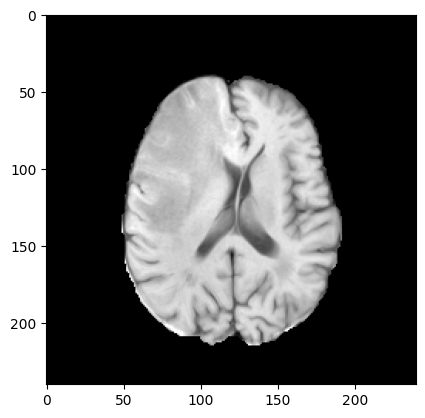

In [141]:
images = merge_and_transpose_images_rgb(rotate_90_deg_rgb(load_rgb_patient("sub-02063373")))
plt.imshow(images[80,:,:,0], cmap = "gray")

shape: (155, 240, 240, 4)
Max value: 1.0
Min value: 0.0


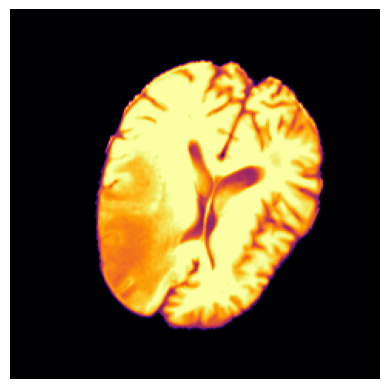

In [48]:
patient_images = prepare_images("sub-02063373")
print(f"shape: {patient_images.shape}")

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal"),
    tf.keras.layers.RandomBrightness(factor = (-0.2, 0.4), value_range=(0, 1)),
    #tf.keras.layers.RandomContrast(0.5), # consider removing the random contrast layer as that causes pixel values to go beyond 1
    tf.keras.layers.RandomRotation(factor = (-0.07, 0.07), fill_mode = "nearest"),
    tf.keras.layers.RandomTranslation(
        height_factor = 0.05,
        width_factor = 0.05,
        fill_mode = "nearest"
    )
])

#consider adding some noise

augmented_images = data_augmentation(patient_images)

plt.imshow(np.array(augmented_images[80,:,:,1]), cmap="inferno")
plt.axis("off")

print("Max value:", np.array(augmented_images).max())
print("Min value:", np.array(augmented_images).min())

#### Data Augmentation - Volumentation

In [66]:
from volumentations import *

def get_augmentation():
    return Compose([Flip(2, p=1),
                    Rotate((-30, 30),(0,0),  (0,0), p=0),
                    RandomGamma(p=1)],
                    p=1.0)
#GaussianNoise(var_limit=(0, 5), p=0.2),
# Rotate((-15, 15), (0, 0), (0, 0), p=0.5),
#                     Flip(0, p=0.5),
#                     Flip(1, p=0.5),
#                     Flip(2, p=0.5),
#                     ElasticTransform((0, 0.25), interpolation=2, p=0.1),
#                     RandomGamma(gamma_limit=(0.5, 1.5), p=0.2)]

def augmentor(img):
    aug = get_augmentation()
    data = {'image': img}
    aug_data = aug(**data)
    img = aug_data['image']
    return np.ndarray.astype(img , np.float32)

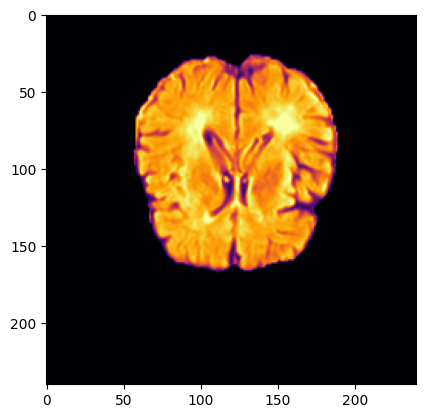

In [89]:

feature_description = {
    "image": tf.io.FixedLenFeature([155, 240, 240, 4], tf.float32),
    "sex": tf.io.FixedLenFeature([2], tf.int64, default_value=[0,0]),
    "age": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "primary": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse(serialize_patient):
    example = tf.io.parse_single_example(serialize_patient, feature_description)
    # input = [example["image"], example["sex"], example["age"]]
    # label = example["primary"]
    image = example["image"]
    image = tf.reshape(image, [155, 240, 240, 4])
    image = data_augmentation(image)
    #image = tf.numpy_function(augmentor, [image], tf.float32)

    return image, example["sex"], example["age"], example["primary"]

dataset = tf.data.TFRecordDataset([path_to_testing_tfr], compression_type="GZIP")
parsed_dataset = dataset.map(parse)



# numpy_image = parsed_dataset.get_single_element()[0].numpy()
# plt.imshow(numpy_image[80,:,:,0], cmap = "inferno")

test_image = parsed_dataset.take(1)
for image, sex, age, primary in test_image:
    numpy_image = image.numpy()
    plt.imshow(numpy_image[80,:,:,0], cmap = "inferno")

#### TFRecord creation

#### Write all the training information to TFRecord

consider adding a seperate patient id to the all the tfrecord entries, to check if any errors occuring during shuffling

In [ ]:
# To-Do:
# shuffle training_patients
# create new tfr file
# go through list of sex, age, created image and primary and write to file
# fucking work

path_to_tfr = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/TFRecords/patient_data_2classes.tfrecord")

def write_to_tfr(patient_id, sex, age, primary):

    image = prepare_images(patient_id)
    imag_data = image.tobytes()

    #sex_data = bytes(sex, "utf-8")

    patient_example = Example(
        features = Features(
            feature = {
                "image": Feature(BytesList(value=imag_data)),
                "sex": Feature(BytesList(value=[sex])),
                "age": Feature(Int64List(value=[age])),
                "primary": Feature(Int64List(value=[primary]))
            }
        )
    )

    with tf.io.TFRecordWriter(path_to_tfr) as f:
        f.write(patient_example.SerializeToString())

write_to_tfr("sub-01641510", sex_array[0], training_patients["age"][0], primary=two_classes_primaries[0])


# Assuming you have your dataset in the following format
dataset = [
    {'sex': [1, 0], 'age': 25, 'primary': 1, 'image': np.random.rand(32, 32, 32, 3)},
    {'sex': [0, 1], 'age': 30, 'primary': 0, 'image': np.random.rand(32, 32, 32, 3)},
    # Add more entries as needed
]

# Function to serialize example
def serialize_example(sex, age, primary, image):
    feature = {
        'sex': tf.train.Feature(int64_list=tf.train.Int64List(value=sex)),
        'age': tf.train.Feature(int64_list=tf.train.Int64List(value=[age])),
        'primary': tf.train.Feature(int64_list=tf.train.Int64List(value=[primary])),
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image[:, :, :, :]).numpy()])),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# Define the output TFRecord file
output_file = 'dataset.tfrecord'

# Write the dataset to TFRecord
with tf.io.TFRecordWriter(output_file) as writer:
    for data in dataset:
        example = serialize_example(data['sex'], data['age'], data['primary'], data['image'])
        writer.write(example)


 

In [2]:
path_to_tfr = "/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/TFRecords/patient_data_2classes.tfrecord"
path_to_testing_tfr = "/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/TFRecords/testing_patient_data_2classes.tfrecord"


safe all patients in one large TFRecord File

In [54]:
def serialize_patient(patientID, sex, age, primary):

    image_data = prepare_images(patientID)

    patient_example = Example(
        features = Features(
            feature = {
                'image': tf.train.Feature(float_list=tf.train.FloatList(value=image_data.ravel())),
                'sex': tf.train.Feature(int64_list=tf.train.Int64List(value= sex)),
                'age': tf.train.Feature(int64_list=tf.train.Int64List(value=[age])),
                'primary': tf.train.Feature(int64_list=tf.train.Int64List(value=[primary])),
            }   
        )
    )

    return patient_example.SerializeToString()

# sex_example = sex_encoded[0]
# id_example = training_patients["participant_id"][0]
# age_example = training_patients["age"][0]
# primary_example = two_classes_primaries[0]
# print(sex_example, id_example, age_example, primary_example)

# Write the dataset to TFRecord
options = tf.io.TFRecordOptions(compression_type="GZIP") # compress the dataset
with tf.io.TFRecordWriter(path_to_tfr, options) as writer:

    for i in tqdm(range(len(training_patients))): # iter over all entities in the dataframe

        sex = sex_encoded[i]
        id = training_patients["participant_id"][i]
        age = training_patients["age"][i]
        primary = two_classes_primaries[i]
        example = serialize_patient(id, sex, age, primary)
        writer.write(example)

100%|██████████| 491/491 [3:27:22<00:00, 25.34s/it]  


#### Create a TFRecord File for testing

splits the testing tfrecord file into 4 seperate files, basically acting as k-folds

In [16]:
#path_to_testing_tfr = "/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/TFRecords/testing_patient_data_2classes.tfrecord"
path_to_testing_tfr = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Data.tmp/testing_patient_data_2classes.tfrecord"

def serialize_patient(patientID, sex, age, primary):

    image_data = prepare_images(patientID)

    patient_example = Example(
        features = Features(
            feature = {
                'image': tf.train.Feature(float_list=tf.train.FloatList(value=image_data.ravel())),
                'sex': tf.train.Feature(int64_list=tf.train.Int64List(value= sex)),
                'age': tf.train.Feature(int64_list=tf.train.Int64List(value=[age])),
                'primary': tf.train.Feature(int64_list=tf.train.Int64List(value=[primary])),
            }   
        )
    )

    return patient_example.SerializeToString()


k = 4
fold_size = 3
testing_patients_lengths = 12


# Write the dataset to TFRecord
options = tf.io.TFRecordOptions(compression_type="GZIP") # compress the dataset

patient_counter = 0

for fold_idx in range(k):

    file_path = f"/Users/LennartPhilipp/Desktop/Uni/Prowiss/Data.tmp/3D_CNN_whole/fold_{fold_idx}.tfrecord"
    with tf.io.TFRecordWriter(file_path, options) as writer:

        for i in range(fold_size):

            sex = sex_encoded[patient_counter]
            id = training_patients["participant_id"][patient_counter]
            age = training_patients["age"][patient_counter]
            primary = two_classes_primaries[patient_counter]
            example = serialize_patient(id, sex, age, primary)
            writer.write(example)
            patient_counter += 1
# with tf.io.TFRecordWriter(path_to_testing_tfr, options) as writer:

#     for i in tqdm(range(12)): # iter over all entities in the dataframe (prev. 8)

#         sex = sex_encoded[i]
#         id = training_patients["participant_id"][i]
#         age = training_patients["age"][i]
#         primary = two_classes_primaries[i]
#         example = serialize_patient(id, sex, age, primary)
#         writer.write(example)

#### Write one TFRecord per patient

In [15]:
path_to_derivatives = Path("/Users/LennartPhilipp/Desktop/testing_data/derivatives/TFRecords")
path_to_preprocessed_patients = Path("/Users/LennartPhilipp/Desktop/testing_data/derivatives/preprocessed_n4_brainlesion_percentile_20240611-125716")

def serialize_patient(patientID, sex, age, primary):

    image_data = prepare_images(patientID)

    patient_example = Example(
        features = Features(
            feature = {
                'image': tf.train.Feature(float_list=tf.train.FloatList(value=image_data.ravel())),
                'sex': tf.train.Feature(int64_list=tf.train.Int64List(value= sex)),
                'age': tf.train.Feature(int64_list=tf.train.Int64List(value=[age])),
                'primary': tf.train.Feature(int64_list=tf.train.Int64List(value=[primary])),
            }   
        )
    )

    return patient_example.SerializeToString()


# Write the dataset to TFRecord
options = tf.io.TFRecordOptions(compression_type="GZIP") # compress the dataset

patients = [patient for patient in os.listdir(path_to_preprocessed_patients) if os.path.isdir(os.path.join(path_to_preprocessed_patients, patient))]

path_to_all_tfr = path_to_derivatives / Path("all_pats_single")
os.makedirs(path_to_all_tfr, exist_ok=True)

for pat in range(len(patients)):

    file_path = str(path_to_all_tfr) + "/" + patients[pat] + ".tfrecord"
    with tf.io.TFRecordWriter(file_path, options) as writer:

        sex = sex_encoded[pat]
        id = training_patients["participant_id"][pat]
        age = training_patients["age"][pat]
        primary = two_classes_primaries[pat]
        example = serialize_patient(id, sex, age, primary)
        writer.write(example)

#### Read TFRecord File

In [3]:
path_to_tsv = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Dateien/dataset_patients_05_24.tsv"

patients = pd.read_csv(path_to_tsv, sep="\t")

[1 0]
46
1


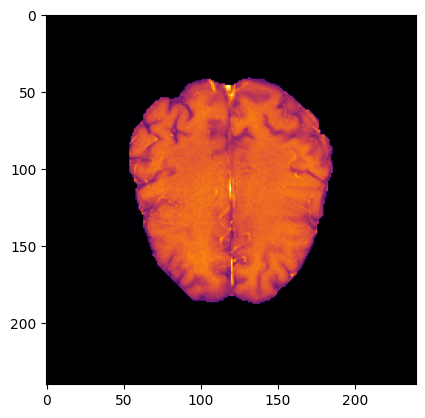

In [7]:
path_to_testing_tfr = "/Users/LennartPhilipp/Desktop/testing_data/derivatives/TFRecords/remote_tfrecords/sub-02063373.tfrecord"

feature_description = {
    "image": tf.io.FixedLenFeature([155, 240, 240, 4], tf.float32),
    "sex": tf.io.FixedLenFeature([2], tf.int64, default_value=[0,0]),
    "age": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "primary": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse(serialize_patient):
    example = tf.io.parse_single_example(serialize_patient, feature_description)
    # input = [example["image"], example["sex"], example["age"]]
    # label = example["primary"]
    image = example["image"]
    image = tf.reshape(image, [155, 240, 240, 4]) #[149, 185, 155, 4] = old size
    
    return image, example["sex"], example["age"], example["primary"]

dataset = tf.data.TFRecordDataset([path_to_testing_tfr], compression_type="GZIP")
parsed_dataset = dataset.map(parse)

test_image = parsed_dataset.take(1)
for image, sex, age, primary in test_image:
    print(sex.numpy())
    print(age.numpy())
    print(primary.numpy())
    numpy_image = image.numpy()
    plt.imshow(numpy_image[100,:,:,0], cmap = "inferno")

# sex
# m = 1, 0
# f = 0, 1

### 2D Images

#### Prepare Images For Training
- load png files
- give options to load mask or cutout
- rotate images 90 degress?
- compress all sequences into one array 

In [9]:
path_to_sliced_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices")
#path_to_sliced_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_test_slices")

In [10]:
def load_2d_rgb_image(patient_id, include_mask = False, only_cutout = False, save_as_rgb = False):
    # order of sequences t1, t1c, t2, flair, maybe mask

    if save_as_rgb:
        imread_flag = cv2.IMREAD_COLOR  # 1
    else: # save as a single gray scale image
        imread_flag = cv2.IMREAD_GRAYSCALE  # 0

    leasions = []
    leasion_ids = {}


    patient_files = [file for file in os.listdir(path_to_sliced_images / patient_id) if file.endswith(".png")]

    leasion_layers = []

    counter = 0

    # adds leasions to the leasion_ids dictionary
    for file in patient_files:

        leasion = int(file.split("_")[3])

        if leasion not in leasion_ids.values():
            leasion_ids[counter] = leasion
            counter += 1


    # goes through all the leasions
    for leasion in range(len(leasion_ids.keys())):
        
        leasion_files = [
            file for file in patient_files
            if int(file.split("_")[3]) == (leasion_ids[leasion])
        ]

        leasion_layer = int(leasion_files[0].split("_")[2])
        #print(f"Leasion Layer = {leasion_layer}")

        leasion_layers.append(leasion_layer)
        
        t1_image = None
        t1c_image = None
        t2_image = None
        flair_image = None
        mask_image = None

        if only_cutout == True:
            # load only cutout of t1, t1c, t2, flair
            leasion_files = [file for file in leasion_files if "cutout" in file]

            for file in leasion_files:
                sequence = file.split("_")[-2]

                path_to_file = str(path_to_sliced_images / patient_id / file)

                bgr_img = cv2.imread(path_to_file, imread_flag)
                # If saving as RGB, convert from BGR -> RGB
                if save_as_rgb and bgr_img is not None:
                    bgr_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

                match sequence:
                    case "t1":
                        t1_image = bgr_img
                    case "t1c":
                        t1c_image = bgr_img
                    case "t2":
                        t2_image = bgr_img
                    case "fla":
                        flair_image = bgr_img
                    case _:
                        pass

            images = [t1_image, t1c_image, t2_image, flair_image]

        elif include_mask == True:
            # load t1, t1c, t2, flair, mask image

            for file in leasion_files:

                path_to_file = str(path_to_sliced_images / patient_id / file)

                sequence = file.split("_")[-1].split(".")[0]

                bgr_img = cv2.imread(path_to_file, imread_flag)
                if save_as_rgb and bgr_img is not None:
                    bgr_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

                
                match sequence:
                    case "t1":
                        t1_image = bgr_img
                    case "t1c":
                        t1c_image = bgr_img
                    case "t2":
                        t2_image = bgr_img
                    case "fla":
                        flair_image = bgr_img
                    case _:
                        pass

                if file.endswith("mask.png") and mask_image is None:
                    mask_image = bgr_img #previously: mask_image = cv2.imread(path_to_file, 0)

            images = [t1_image, t1c_image, t2_image, flair_image, mask_image]

        else:
            # load t1, t1c, t2, flair image

            for file in leasion_files:

                path_to_file = str(path_to_sliced_images / patient_id / file)

                sequence = file.split("_")[-1].split(".")[0]

                bgr_img = cv2.imread(path_to_file, imread_flag)
                if save_as_rgb and bgr_img is not None:
                    bgr_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

                
                match sequence:
                    case "t1":
                        t1_image = bgr_img
                    case "t1c":
                        t1c_image = bgr_img
                    case "t2":
                        t2_image = bgr_img
                    case "fla":
                        flair_image = bgr_img
                    case _:
                        #print("Wrong sequence set in the load_2d_rgb_image func, please pick a sequence between t1, t1c, t2, flair")
                        pass

            images = [t1_image, t1c_image, t2_image, flair_image]
        
        leasions.append(images)
    
    return leasions, leasion_layers

def merge_2d_rgb_images(leasions):

    merged = []

    for leasion in leasions:
        stacked = tf.stack(leasion, axis = -1)
        merged.append(stacked)
    
    return tf.convert_to_tensor(merged)

def prepare_2d_rgb_images(patient_id, include_mask = False, only_cutout = False, save_as_rgb = False):

    leasions, leasion_layers = load_2d_rgb_image(patient_id, include_mask, only_cutout, save_as_rgb)
    merged = merge_2d_rgb_images(leasions)

    if len(leasions) != len(leasion_layers):
        print("ERROR! Amount of leasions is not equal to the amount of leasion_layers")

    return merged, leasion_layers

(240, 240, 3)


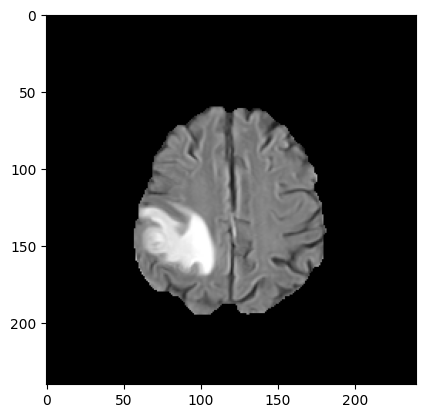

In [11]:
leasions, leasion_layers = load_2d_rgb_image(patient_id = "sub-01134825",
                             include_mask = True,
                             only_cutout = False,
                             save_as_rgb = True)

#print(leasions[0].shape)

plt.imshow(leasions[0][3], cmap = "gray")

print(leasions[0][1].shape)

merged = merge_2d_rgb_images(leasions)

#merged = merge_2d_rgb_images(leasions)
# plt.imshow(merged[0][:,:,2], cmap = "gray")

#### Data Augmentation

custom layer that adjusts all pixel values to be between 0 and 1

In [6]:
class NormalizeToRange(tf.keras.layers.Layer):
    def __init__(self, zero_to_one=True):
        super(NormalizeToRange, self).__init__()
        self.zero_to_one = zero_to_one

    def call(self, inputs):
        min_val = tf.reduce_min(inputs)
        max_val = tf.reduce_max(inputs)
        if self.zero_to_one:
            # Normalize to [0, 1]
            normalized = (inputs - min_val) / (max_val - min_val)
        else:
            # Normalize to [-1, 1]
            normalized = 2 * (inputs - min_val) / (max_val - min_val) - 1
        return normalized

Random Rescaling Custom Layer

In [16]:
class RandomRescale(tf.keras.layers.Layer):
    def __init__(self, scale_range=(0.8, 1.2), **kwargs):
        """
        Custom layer for random rescaling of images.
        Args:
            scale_range (tuple): A tuple specifying the minimum and maximum scaling factors.
                                 Values < 1.0 zoom out, and > 1.0 zoom in.
        """
        super(RandomRescale, self).__init__(**kwargs)
        self.scale_range = scale_range

    def call(self, inputs, training=None):
        if training:
            # Randomly choose a scaling factor
            scale = tf.random.uniform([], self.scale_range[0], self.scale_range[1])
            
            # Get image dimensions
            input_shape = tf.shape(inputs)
            #height, width = input_shape[1], input_shape[2]
            height, width = input_shape[0], input_shape[1]
            
            # Compute new dimensions
            new_height = tf.cast(tf.cast(height, tf.float32) * scale, tf.int32)
            new_width = tf.cast(tf.cast(width, tf.float32) * scale, tf.int32)
            
            # Resize image to new dimensions
            scaled_image = tf.image.resize(inputs, [new_height, new_width])
            
            # Crop or pad to original size
            scaled_image = tf.image.resize_with_crop_or_pad(scaled_image, height, width)
            
            return scaled_image
        else:
            return inputs

    def get_config(self):
        config = super(RandomRescale, self).get_config()
        config.update({"scale_range": self.scale_range})
        return config


a simple data augmentation protocol that includes
- horizontal flip
- rescaling to 0 - 1
- random contrast
- random brightness
- random rotation
- rescaling again lol
- random translatio

I had to rescale the images again using a custom layer, so that all images values are between 0 and 1 in the end

input shape: (240, 240, 5)
augmented shape: (240, 240, 5)
Max value: 0.99750924
Mean value: 0.27595377
Min value: 0.0


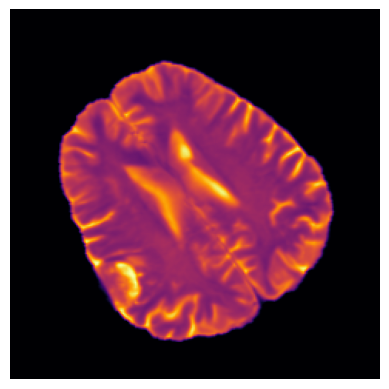

In [231]:
patient_images = merge_2d_rgb_images(load_2d_rgb_image(patient_id = "sub-01921604",
                            include_mask = True,
                            only_cutout = False)[0])[1]
print(f"input shape: {patient_images.shape}")

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal"),
    #tf.keras.layers.Rescaling(1/255),
    tf.keras.layers.RandomContrast(0.5), # consider removing the random contrast layer as that causes pixel values to go beyond 1
    tf.keras.layers.RandomBrightness(factor = (-0.2, 0.4)), #, value_range=(0, 1)
    tf.keras.layers.RandomRotation(factor = (-0.14, 0.14), fill_mode = "nearest"),
    NormalizeToRange(zero_to_one=True),
    tf.keras.layers.RandomTranslation(
        height_factor = 0.05,
        width_factor = 0.05,
        fill_mode = "nearest"
    ),
    RandomRescale(scale_range=(0.7, 1.2))
])

#consider adding some noise

augmented_images = data_augmentation(patient_images)

print(f"augmented shape: {augmented_images.shape}")

plt.imshow(np.array(augmented_images[:,:,2]), cmap="inferno")
plt.axis("off")

print("Max value:", np.array(augmented_images).max())
print("Mean value:", np.array(augmented_images).mean())
print("Min value:", np.array(augmented_images).min())

#### TFRecord Creation

In [12]:
path_to_derivatives = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords")
path_to_preprocessed_patients = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices")

tf.experimental.numpy.experimental_enable_numpy_behavior()

def serialize_2d_patient(image_data, sex, age, layer, primary):

    #print(image_data.shape)

    #image_data = prepare_2d_rgb_images(patientID, include_mask = True, only_cutout = False)

    patient_example = Example(
        features = Features(
            feature = {
                'image': tf.train.Feature(float_list=tf.train.FloatList(value = image_data.ravel())),
                'sex': tf.train.Feature(int64_list=tf.train.Int64List(value = [sex])),
                'age': tf.train.Feature(int64_list=tf.train.Int64List(value = [age])),
                'layer': tf.train.Feature(int64_list=tf.train.Int64List(value = [layer])),
                'primary': tf.train.Feature(int64_list=tf.train.Int64List(value= [primary])),
            }   
        )
    )

    return patient_example.SerializeToString()

# consider addng include_mask as parameter
def writeTFRecordFiles(save_as_rgb, save_as_cutout, include_mask, only_one_patient = False):
    # Write the dataset to TFRecord
    options = tf.io.TFRecordOptions(compression_type="GZIP") # compress the dataset

    patients = [patient for patient in os.listdir(path_to_preprocessed_patients) if os.path.isdir(os.path.join(path_to_preprocessed_patients, patient))]

    # write a check to compare patient_ids with patients
    patients = set(patients).intersection(patient_ids)

    slice_text = "cutout" if save_as_cutout else "slice"
    color_text = "rgb" if save_as_rgb else "gray"

    folder_text = f"all_pats_single_{slice_text}_{color_text}"

    path_to_all_tfr = path_to_derivatives / Path(folder_text)

    os.makedirs(path_to_all_tfr, exist_ok=True)

    # get list of already processed patients
    tfr_already_created_patients = [patient for patient in os.listdir(path_to_all_tfr) if os.path.isdir(os.path.join(path_to_all_tfr, patient))]

    for patient in tfr_already_created_patients:
        # check if the number of leasions equals the number of tfr files
        path_to_patient = path_to_all_tfr / patient
        tfr_files = [f for f in os.listdir(path_to_patient) if f.endswith(".tfrecord")]
        num_leasions = len(tfr_files)
        leasions, leasion_layers = prepare_2d_rgb_images(patient, include_mask = include_mask, only_cutout = save_as_cutout, save_as_rgb=save_as_rgb)
        if num_leasions != len(leasions):
            # delete the patient folder
            shutil.rmtree(path_to_patient)
            tfr_already_created_patients.remove(patient)
    
    counter = 0

    # loop through patients
    for pat in tqdm(patients):

        if counter > 0 and only_one_patient:
            break

        if os.path.exists(path_to_all_tfr):
            if pat in tfr_already_created_patients:
                print(f"Skipping patient {pat}")
                continue

        # create patient folder
        path_to_patient = path_to_all_tfr / pat
        os.makedirs(path_to_patient, exist_ok=False)

        leasions, leasion_layers = prepare_2d_rgb_images(pat, include_mask = include_mask, only_cutout = save_as_cutout, save_as_rgb = save_as_rgb)
        print(f"found {len(leasions)} leasion(s) and {len(leasion_layers)} layers in patient {pat}")

        for i in range(len(leasions)):

            file_path = str(path_to_patient) + "/" + pat + "_" + str(i) + ".tfrecord"
            with tf.io.TFRecordWriter(file_path, options) as writer:

                sex = sex_array_dict[pat]
                leasion_data = leasions[i]
                age = int(list(training_patients[training_patients["participant_id"] == pat]["age"])[0])
                layer = leasion_layers[i]
                primary = specific_primaries_dict[pat]
                # print("________________")
                # print(age)
                example = serialize_2d_patient(leasion_data, sex, age, layer, primary)
                writer.write(example)
        
        counter += 1

In [13]:
writeTFRecordFiles(save_as_rgb = False, save_as_cutout = False, include_mask = True)

  0%|          | 0/470 [00:00<?, ?it/s]

Skipping patient sub-01419998
found 1 leasion(s) and 1 layers in patient sub-01805334


  0%|          | 2/470 [00:15<59:46,  7.66s/it]

Skipping patient sub-01164986
Skipping patient sub-02120806
Skipping patient sub-01521599
found 25 leasion(s) and 25 layers in patient sub-02092748


  1%|▏         | 6/470 [06:34<9:17:59, 72.15s/it]

found 1 leasion(s) and 1 layers in patient sub-01125016


  1%|▏         | 7/470 [06:49<7:44:51, 60.24s/it]

Skipping patient sub-02190005
Skipping patient sub-02012594
Skipping patient sub-01798755
Skipping patient sub-02026140
Skipping patient sub-02183443
Skipping patient sub-02145622
Skipping patient sub-01551183
Skipping patient sub-01744565
Skipping patient sub-96003928
Skipping patient sub-02181503
Skipping patient sub-01760947
Skipping patient sub-02014467
Skipping patient sub-01122863
found 4 leasion(s) and 4 layers in patient sub-01569328


  4%|▍         | 21/470 [07:50<1:53:11, 15.12s/it]

Skipping patient sub-02085355
found 2 leasion(s) and 2 layers in patient sub-02080563


  5%|▍         | 23/470 [08:20<1:52:42, 15.13s/it]

Skipping patient sub-01530724
Skipping patient sub-01435731
Skipping patient sub-01670714
Skipping patient sub-01025630
found 1 leasion(s) and 1 layers in patient sub-01543367


  6%|▌         | 28/470 [08:35<1:21:32, 11.07s/it]

Skipping patient sub-02095303
Skipping patient sub-01015961
found 1 leasion(s) and 1 layers in patient sub-01861511


  7%|▋         | 31/470 [08:50<1:11:09,  9.73s/it]

found 10 leasion(s) and 10 layers in patient sub-01489395


  7%|▋         | 32/470 [11:21<2:50:04, 23.30s/it]

Skipping patient sub-01997658
Skipping patient sub-01496608
found 1 leasion(s) and 1 layers in patient sub-01616246


  7%|▋         | 35/470 [11:36<2:10:14, 17.96s/it]

Skipping patient sub-01387984
Skipping patient sub-01699419
Skipping patient sub-02188930
Skipping patient sub-01478990
Skipping patient sub-01465229
Skipping patient sub-01789555
Skipping patient sub-01421533
Skipping patient sub-01402283
Skipping patient sub-01703264
Skipping patient sub-01130173
Skipping patient sub-01131702
Skipping patient sub-02019520
Skipping patient sub-01251946
Skipping patient sub-01882989
Skipping patient sub-01373833
found 3 leasion(s) and 3 layers in patient sub-01515235


 11%|█         | 51/470 [12:21<52:21,  7.50s/it]  

Skipping patient sub-01584596
found 1 leasion(s) and 1 layers in patient sub-02020631


 11%|█▏        | 53/470 [12:36<52:06,  7.50s/it]

Skipping patient sub-01083248
Skipping patient sub-01414189
Skipping patient sub-02018743
found 2 leasion(s) and 2 layers in patient sub-01710250


 12%|█▏        | 57/470 [13:06<51:36,  7.50s/it]

Skipping patient sub-01779701
Skipping patient sub-01281168
Skipping patient sub-01130856
Skipping patient sub-01056884
found 2 leasion(s) and 2 layers in patient sub-02097980


 13%|█▎        | 62/470 [13:36<47:54,  7.04s/it]

Skipping patient sub-02089657
found 1 leasion(s) and 1 layers in patient sub-02073121


 14%|█▎        | 64/470 [13:51<48:06,  7.11s/it]

Skipping patient sub-01695080
Skipping patient sub-01854308
Skipping patient sub-01492604
found 1 leasion(s) and 1 layers in patient sub-01952689


 14%|█▍        | 68/470 [14:06<41:03,  6.13s/it]

Skipping patient sub-01410317
Skipping patient sub-02090355
Skipping patient sub-01983233
Skipping patient sub-01981993
Skipping patient sub-02019676
Skipping patient sub-01961566
found 1 leasion(s) and 1 layers in patient sub-01589112


 16%|█▌        | 75/470 [14:21<29:12,  4.44s/it]

Skipping patient sub-02138280
Skipping patient sub-01201482
Skipping patient sub-01871625
Skipping patient sub-02137062
Skipping patient sub-01381621
Skipping patient sub-01311383
found 4 leasion(s) and 4 layers in patient sub-02070606


 17%|█▋        | 82/470 [15:21<38:39,  5.98s/it]

Skipping patient sub-01480742
Skipping patient sub-02127770
Skipping patient sub-01587295
Skipping patient sub-01781732
Skipping patient sub-01549022
Skipping patient sub-01583797
Skipping patient sub-01479403
Skipping patient sub-01892684
found 1 leasion(s) and 1 layers in patient sub-01982853


 19%|█▉        | 91/470 [15:36<26:38,  4.22s/it]

Skipping patient sub-02021781
Skipping patient sub-02074050
Skipping patient sub-02063373
found 1 leasion(s) and 1 layers in patient sub-01797781


 20%|██        | 95/470 [15:51<25:45,  4.12s/it]

found 17 leasion(s) and 17 layers in patient sub-02095961


 20%|██        | 96/470 [20:05<2:12:41, 21.29s/it]

Skipping patient sub-01373703
Skipping patient sub-01055292
found 1 leasion(s) and 1 layers in patient sub-01205745


 21%|██        | 99/470 [20:20<1:48:41, 17.58s/it]

found 1 leasion(s) and 1 layers in patient sub-01947074


 21%|██▏       | 100/470 [20:35<1:46:48, 17.32s/it]

Skipping patient sub-01134825
Skipping patient sub-02088404
Skipping patient sub-01666008
Skipping patient sub-01706146
Skipping patient sub-02084961
Skipping patient sub-02119712
found 1 leasion(s) and 1 layers in patient sub-01935938


 23%|██▎       | 107/470 [20:50<59:29,  9.83s/it]  

Skipping patient sub-02163033
Skipping patient sub-01609293
Skipping patient sub-01562247
found 1 leasion(s) and 1 layers in patient sub-01796937


 24%|██▎       | 111/470 [21:05<48:22,  8.09s/it]

found 2 leasion(s) and 2 layers in patient sub-01425882


 24%|██▍       | 112/470 [21:35<1:00:16, 10.10s/it]

Skipping patient sub-01188297
Skipping patient sub-01398968
Skipping patient sub-01455312
Skipping patient sub-02128777
Skipping patient sub-01038520
found 1 leasion(s) and 1 layers in patient sub-01199093


 25%|██▌       | 118/470 [21:50<39:26,  6.72s/it]  

Skipping patient sub-01021714
Skipping patient sub-90001992
Skipping patient sub-01732889
Skipping patient sub-01152379
Skipping patient sub-02034046
found 1 leasion(s) and 1 layers in patient sub-99000041


 26%|██▋       | 124/470 [22:05<29:18,  5.08s/it]

Skipping patient sub-02174928
Skipping patient sub-01893873
found 2 leasion(s) and 2 layers in patient sub-01288896


 27%|██▋       | 127/470 [22:34<35:04,  6.14s/it]

found 1 leasion(s) and 1 layers in patient sub-01395836


 27%|██▋       | 128/470 [22:49<39:41,  6.96s/it]

Skipping patient sub-01709242
found 3 leasion(s) and 3 layers in patient sub-01331487


 28%|██▊       | 130/470 [23:34<57:49, 10.20s/it]

found 1 leasion(s) and 1 layers in patient sub-01594137


 28%|██▊       | 131/470 [23:49<1:01:04, 10.81s/it]

Skipping patient sub-01205171
found 1 leasion(s) and 1 layers in patient sub-01483526


 28%|██▊       | 133/470 [24:04<55:46,  9.93s/it]  

found 1 leasion(s) and 1 layers in patient sub-01674416


 29%|██▊       | 134/470 [24:19<1:00:21, 10.78s/it]

Skipping patient sub-02164825
Skipping patient sub-01691369
found 1 leasion(s) and 1 layers in patient sub-02115365


 29%|██▉       | 137/470 [24:34<46:42,  8.42s/it]  

Skipping patient sub-01108350
Skipping patient sub-02075769
Skipping patient sub-01773716
Skipping patient sub-02071509
Skipping patient sub-02094355
Skipping patient sub-02177752
Skipping patient sub-02137073
Skipping patient sub-01660211
found 2 leasion(s) and 2 layers in patient sub-01309950


 31%|███       | 146/470 [25:04<27:54,  5.17s/it]

Skipping patient sub-02172003
Skipping patient sub-01018613
found 1 leasion(s) and 1 layers in patient sub-01484016


 32%|███▏      | 149/470 [25:19<27:22,  5.12s/it]

Skipping patient sub-01883957
Skipping patient sub-01699532
Skipping patient sub-02070580
Skipping patient sub-01288245
Skipping patient sub-01957841
Skipping patient sub-01946372
Skipping patient sub-01705952
found 1 leasion(s) and 1 layers in patient sub-01942928


 33%|███▎      | 157/470 [25:34<18:44,  3.59s/it]

Skipping patient sub-88000225
Skipping patient sub-01545797
Skipping patient sub-01713022
Skipping patient sub-02184584
Skipping patient sub-02132336
Skipping patient sub-01461078
Skipping patient sub-01649133
Skipping patient sub-01457167
found 1 leasion(s) and 1 layers in patient sub-01441531


 35%|███▌      | 166/470 [25:49<13:59,  2.76s/it]

Skipping patient sub-01117958
found 4 leasion(s) and 4 layers in patient sub-01696845


 36%|███▌      | 168/470 [26:49<30:15,  6.01s/it]

Skipping patient sub-01707721
Skipping patient sub-01391534
Skipping patient sub-01924748
found 5 leasion(s) and 5 layers in patient sub-01596127


 37%|███▋      | 172/470 [28:04<46:08,  9.29s/it]

Skipping patient sub-01513891
found 1 leasion(s) and 1 layers in patient sub-01213140


 37%|███▋      | 174/470 [28:19<44:31,  9.03s/it]

Skipping patient sub-02038513
Skipping patient sub-02197114
Skipping patient sub-01390721
Skipping patient sub-01502083
Skipping patient sub-02178883
Skipping patient sub-02015730
Skipping patient sub-01405609
Skipping patient sub-01763867
Skipping patient sub-01458719
Skipping patient sub-01905692
Skipping patient sub-01960441
Skipping patient sub-01332588
Skipping patient sub-96004436
found 14 leasion(s) and 14 layers in patient sub-02082001


 40%|████      | 188/470 [31:47<59:02, 12.56s/it]

found 2 leasion(s) and 2 layers in patient sub-02071087


 40%|████      | 189/470 [32:17<1:03:29, 13.56s/it]

Skipping patient sub-01695173
Skipping patient sub-01005097
found 2 leasion(s) and 2 layers in patient sub-01269967


 41%|████      | 192/470 [32:46<59:25, 12.83s/it]  

Skipping patient sub-01890298
Skipping patient sub-01754011
Skipping patient sub-93003757
Skipping patient sub-01881784
Skipping patient sub-02153522
Skipping patient sub-01924997
Skipping patient sub-02119444
Skipping patient sub-02088565
Skipping patient sub-01041137
Skipping patient sub-02113718
Skipping patient sub-02165732
found 1 leasion(s) and 1 layers in patient sub-01031243


 43%|████▎     | 204/470 [33:01<29:27,  6.64s/it]

Skipping patient sub-02031868
Skipping patient sub-01415245
found 2 leasion(s) and 2 layers in patient sub-01064662


 44%|████▍     | 207/470 [33:31<31:22,  7.16s/it]

Skipping patient sub-01393875
Skipping patient sub-01169240
Skipping patient sub-01710310
Skipping patient sub-01021993
Skipping patient sub-01707275
found 7 leasion(s) and 7 layers in patient sub-01150136


 45%|████▌     | 213/470 [35:16<44:32, 10.40s/it]

found 1 leasion(s) and 1 layers in patient sub-01764802


 46%|████▌     | 214/470 [35:31<45:43, 10.72s/it]

Skipping patient sub-02014685
Skipping patient sub-02146286
found 15 leasion(s) and 15 layers in patient sub-01494236


 46%|████▌     | 217/470 [39:14<1:46:44, 25.31s/it]

Skipping patient sub-02197683
found 3 leasion(s) and 3 layers in patient sub-01098043


 47%|████▋     | 219/470 [39:58<1:43:41, 24.79s/it]

Skipping patient sub-01434869
Skipping patient sub-01696904
Skipping patient sub-02131818
Skipping patient sub-01314225
Skipping patient sub-02139997
found 2 leasion(s) and 2 layers in patient sub-01486069


 48%|████▊     | 225/470 [40:28<1:06:06, 16.19s/it]

found 1 leasion(s) and 1 layers in patient sub-01207036


 48%|████▊     | 226/470 [40:43<1:05:21, 16.07s/it]

Skipping patient sub-01196057
Skipping patient sub-01410235
found 2 leasion(s) and 2 layers in patient sub-01801060


 49%|████▊     | 229/470 [41:13<57:33, 14.33s/it]  

Skipping patient sub-01204563
Skipping patient sub-01840035
Skipping patient sub-01936903
Skipping patient sub-02066389
found 1 leasion(s) and 1 layers in patient sub-01550202


 50%|████▉     | 234/470 [41:28<38:16,  9.73s/it]

Skipping patient sub-01677324
Skipping patient sub-01087386
Skipping patient sub-02010452
found 1 leasion(s) and 1 layers in patient sub-02036251


 51%|█████     | 238/470 [41:43<30:18,  7.84s/it]

found 1 leasion(s) and 1 layers in patient sub-01377261


 51%|█████     | 239/470 [41:58<32:57,  8.56s/it]

found 9 leasion(s) and 9 layers in patient sub-01695094


 51%|█████     | 240/470 [44:13<1:34:00, 24.52s/it]

Skipping patient sub-01654658
found 1 leasion(s) and 1 layers in patient sub-01702596


 51%|█████▏    | 242/470 [44:28<1:15:56, 19.98s/it]

found 6 leasion(s) and 6 layers in patient sub-01755816


 52%|█████▏    | 243/470 [45:57<1:57:29, 31.06s/it]

Skipping patient sub-02063986
found 2 leasion(s) and 2 layers in patient sub-01099901


 52%|█████▏    | 245/470 [46:27<1:37:42, 26.06s/it]

Skipping patient sub-02105939
Skipping patient sub-01437004
Skipping patient sub-02100576
found 1 leasion(s) and 1 layers in patient sub-01433377


 53%|█████▎    | 249/470 [46:42<57:09, 15.52s/it]  

Skipping patient sub-02035864
Skipping patient sub-01384142
found 2 leasion(s) and 2 layers in patient sub-02055312


 54%|█████▎    | 252/470 [47:12<49:36, 13.65s/it]

Skipping patient sub-01494733
found 6 leasion(s) and 6 layers in patient sub-01641960


 54%|█████▍    | 254/470 [48:41<1:16:16, 21.19s/it]

Skipping patient sub-02020169
found 3 leasion(s) and 3 layers in patient sub-01990699


 54%|█████▍    | 256/470 [49:26<1:16:37, 21.48s/it]

found 1 leasion(s) and 1 layers in patient sub-01650072


 55%|█████▍    | 257/470 [49:41<1:12:40, 20.47s/it]

Skipping patient sub-01895825
Skipping patient sub-01795656
Skipping patient sub-01936520
found 1 leasion(s) and 1 layers in patient sub-01616767


 56%|█████▌    | 261/470 [49:56<43:52, 12.60s/it]  

Skipping patient sub-01698789
Skipping patient sub-02154718
Skipping patient sub-01420310
Skipping patient sub-01501379
found 1 leasion(s) and 1 layers in patient sub-01673666


 57%|█████▋    | 266/470 [50:11<27:55,  8.21s/it]

Skipping patient sub-01607473
Skipping patient sub-01214417
Skipping patient sub-02036130
Skipping patient sub-02134991
Skipping patient sub-01600788
Skipping patient sub-01812518
found 2 leasion(s) and 2 layers in patient sub-01190670


 58%|█████▊    | 273/470 [50:41<20:47,  6.33s/it]

Skipping patient sub-01514331
Skipping patient sub-01652130
Skipping patient sub-01572564
Skipping patient sub-02000864
Skipping patient sub-01573094
found 2 leasion(s) and 2 layers in patient sub-01592849


 59%|█████▉    | 279/470 [51:11<18:33,  5.83s/it]

Skipping patient sub-01969755
Skipping patient sub-02122538
Skipping patient sub-02036854
Skipping patient sub-01879950
Skipping patient sub-02071305
Skipping patient sub-01414540
Skipping patient sub-01943022
found 1 leasion(s) and 1 layers in patient sub-01400779


 61%|██████    | 287/470 [51:25<12:46,  4.19s/it]

Skipping patient sub-01516702
found 28 leasion(s) and 28 layers in patient sub-01111974


 61%|██████▏   | 289/470 [58:24<1:32:01, 30.51s/it]

Skipping patient sub-01812578
Skipping patient sub-02152734
Skipping patient sub-01071055
Skipping patient sub-01661279
found 1 leasion(s) and 1 layers in patient sub-01792136


 63%|██████▎   | 294/470 [58:39<1:04:05, 21.85s/it]

Skipping patient sub-02094837
Skipping patient sub-01456719
found 1 leasion(s) and 1 layers in patient sub-02090169


 63%|██████▎   | 297/470 [58:53<52:38, 18.26s/it]  

Skipping patient sub-93002557
Skipping patient sub-01243841
Skipping patient sub-01874079
Skipping patient sub-01340749
Skipping patient sub-02145747
Skipping patient sub-02086122
found 5 leasion(s) and 5 layers in patient sub-02155605


 65%|██████▍   | 304/470 [1:00:08<41:47, 15.11s/it]

Skipping patient sub-02115377
found 1 leasion(s) and 1 layers in patient sub-02185066


 65%|██████▌   | 306/470 [1:00:23<38:17, 14.01s/it]

Skipping patient sub-01006290
Skipping patient sub-02090905
Skipping patient sub-01804484
found 18 leasion(s) and 18 layers in patient sub-01946271


 66%|██████▌   | 310/470 [1:04:51<1:18:43, 29.52s/it]

Skipping patient sub-01497790
Skipping patient sub-02140670
Skipping patient sub-02015335
Skipping patient sub-01852952
Skipping patient sub-01953116
Skipping patient sub-02031256
Skipping patient sub-02179132
Skipping patient sub-01288036
Skipping patient sub-80004059
Skipping patient sub-01978091
found 1 leasion(s) and 1 layers in patient sub-90005031


 68%|██████▊   | 321/470 [1:05:06<35:53, 14.46s/it]  

Skipping patient sub-01138456
Skipping patient sub-90003334
Skipping patient sub-01423083
found 2 leasion(s) and 2 layers in patient sub-01565091


 69%|██████▉   | 325/470 [1:05:36<31:14, 12.92s/it]

found 1 leasion(s) and 1 layers in patient sub-01695930


 69%|██████▉   | 326/470 [1:05:50<31:20, 13.06s/it]

Skipping patient sub-01231700
Skipping patient sub-01432274
Skipping patient sub-02124336
Skipping patient sub-95001254
Skipping patient sub-01040149
Skipping patient sub-01288350
Skipping patient sub-01241505
Skipping patient sub-01476909
Skipping patient sub-01521835
Skipping patient sub-02104370
Skipping patient sub-01505384
Skipping patient sub-02126982
Skipping patient sub-01991292
Skipping patient sub-02096374
Skipping patient sub-01009590
found 1 leasion(s) and 1 layers in patient sub-01262362


 73%|███████▎  | 342/470 [1:06:05<11:46,  5.52s/it]

Skipping patient sub-01409764
Skipping patient sub-01830168
found 2 leasion(s) and 2 layers in patient sub-02063398


 73%|███████▎  | 345/470 [1:06:35<12:48,  6.15s/it]

Skipping patient sub-01377175
Skipping patient sub-02136965
Skipping patient sub-01358619
found 1 leasion(s) and 1 layers in patient sub-01706562


 74%|███████▍  | 349/470 [1:06:50<11:20,  5.63s/it]

found 4 leasion(s) and 4 layers in patient sub-02095181


 74%|███████▍  | 350/470 [1:07:49<18:53,  9.45s/it]

Skipping patient sub-01717958
Skipping patient sub-01261127
Skipping patient sub-01443624
Skipping patient sub-01307298
Skipping patient sub-02094018
Skipping patient sub-02064363
Skipping patient sub-01657294
found 6 leasion(s) and 6 layers in patient sub-02046093


 76%|███████▌  | 358/470 [1:09:19<19:04, 10.22s/it]

Skipping patient sub-01686968
Skipping patient sub-02011152
found 6 leasion(s) and 6 layers in patient sub-02168956


 77%|███████▋  | 361/470 [1:10:50<25:39, 14.12s/it]

Skipping patient sub-01729917
Skipping patient sub-01961554
Skipping patient sub-01979317
found 2 leasion(s) and 2 layers in patient sub-01450871


 78%|███████▊  | 365/470 [1:11:21<21:43, 12.41s/it]

found 1 leasion(s) and 1 layers in patient sub-01957247


 78%|███████▊  | 366/470 [1:11:37<21:59, 12.69s/it]

Skipping patient sub-02073198
Skipping patient sub-01005630
Skipping patient sub-01548397
found 1 leasion(s) and 1 layers in patient sub-01072344


 79%|███████▊  | 370/470 [1:11:52<16:16,  9.76s/it]

Skipping patient sub-01578955
found 2 leasion(s) and 2 layers in patient sub-01362907


 79%|███████▉  | 372/470 [1:12:24<17:46, 10.88s/it]

found 6 leasion(s) and 6 layers in patient sub-01370265


 79%|███████▉  | 373/470 [1:13:57<33:44, 20.88s/it]

Skipping patient sub-02087023
Skipping patient sub-02209727
Skipping patient sub-01190738
Skipping patient sub-02173158
Skipping patient sub-02145870
Skipping patient sub-01547588
Skipping patient sub-01274157
found 4 leasion(s) and 4 layers in patient sub-01864584


 81%|████████  | 381/470 [1:14:59<19:41, 13.28s/it]

found 3 leasion(s) and 3 layers in patient sub-02047436


 81%|████████▏ | 382/470 [1:15:46<24:03, 16.40s/it]

Skipping patient sub-01164049
found 1 leasion(s) and 1 layers in patient sub-01499528


 82%|████████▏ | 384/470 [1:16:01<20:54, 14.59s/it]

Skipping patient sub-01921604
Skipping patient sub-01732456
Skipping patient sub-01216717
found 1 leasion(s) and 1 layers in patient sub-01321873


 83%|████████▎ | 388/470 [1:16:17<14:25, 10.56s/it]

Skipping patient sub-90003562
found 5 leasion(s) and 5 layers in patient sub-01483723


 83%|████████▎ | 390/470 [1:17:35<22:07, 16.59s/it]

found 1 leasion(s) and 1 layers in patient sub-02145605


 83%|████████▎ | 391/470 [1:17:51<21:40, 16.46s/it]

Skipping patient sub-90005297
found 3 leasion(s) and 3 layers in patient sub-01966470


 84%|████████▎ | 393/470 [1:18:37<23:32, 18.35s/it]

Skipping patient sub-01214172
Skipping patient sub-01542729
Skipping patient sub-01104996
Skipping patient sub-02066445
Skipping patient sub-01659187
found 3 leasion(s) and 3 layers in patient sub-01349100


 85%|████████▍ | 399/470 [1:19:24<14:58, 12.66s/it]

found 125 leasion(s) and 125 layers in patient sub-01106844


 85%|████████▌ | 400/470 [1:51:42<4:30:24, 231.78s/it]

Skipping patient sub-01496804
Skipping patient sub-80011453
found 2 leasion(s) and 2 layers in patient sub-01119720


 86%|████████▌ | 403/470 [1:52:13<2:57:43, 159.16s/it]

Skipping patient sub-02190209
Skipping patient sub-01022787
Skipping patient sub-01762556
Skipping patient sub-01713725
found 4 leasion(s) and 4 layers in patient sub-02172137


 87%|████████▋ | 408/470 [1:53:15<1:37:59, 94.83s/it] 

Skipping patient sub-02167890
Skipping patient sub-01456959
found 4 leasion(s) and 4 layers in patient sub-02036053


 87%|████████▋ | 411/470 [1:54:17<1:13:20, 74.58s/it]

Skipping patient sub-01056598
found 1 leasion(s) and 1 layers in patient sub-01908576


 88%|████████▊ | 413/470 [1:54:33<57:45, 60.79s/it]  

Skipping patient sub-01792771
Skipping patient sub-01147272
found 1 leasion(s) and 1 layers in patient sub-01391984


 89%|████████▊ | 416/470 [1:54:49<39:22, 43.74s/it]

Skipping patient sub-02113470
Skipping patient sub-01905848
found 8 leasion(s) and 8 layers in patient sub-02148372


 89%|████████▉ | 419/470 [1:56:52<36:33, 43.00s/it]

Skipping patient sub-02135803
Skipping patient sub-01431720
found 14 leasion(s) and 14 layers in patient sub-02142561


 90%|████████▉ | 422/470 [2:00:29<41:26, 51.81s/it]

found 1 leasion(s) and 1 layers in patient sub-02106388


 90%|█████████ | 423/470 [2:00:44<36:59, 47.22s/it]

found 23 leasion(s) and 23 layers in patient sub-01516618


 90%|█████████ | 424/470 [2:06:40<1:12:18, 94.32s/it]

Skipping patient sub-02116290
Skipping patient sub-01906150
found 1 leasion(s) and 1 layers in patient sub-01605537


 91%|█████████ | 427/470 [2:06:55<42:19, 59.07s/it]  

Skipping patient sub-01885520
found 2 leasion(s) and 2 layers in patient sub-02014068


 91%|█████████▏| 429/470 [2:07:26<32:12, 47.14s/it]

found 4 leasion(s) and 4 layers in patient sub-01979997


 91%|█████████▏| 430/470 [2:08:28<33:03, 49.60s/it]

found 2 leasion(s) and 2 layers in patient sub-02082498


 92%|█████████▏| 431/470 [2:09:00<29:58, 46.11s/it]

Skipping patient sub-02051037
Skipping patient sub-01835095
Skipping patient sub-01914558
Skipping patient sub-01713570
Skipping patient sub-01117914
Skipping patient sub-01882333
Skipping patient sub-01681275
Skipping patient sub-02167792
Skipping patient sub-02070903
Skipping patient sub-01492723
Skipping patient sub-02026964
Skipping patient sub-02196769
found 2 leasion(s) and 2 layers in patient sub-01673701


 94%|█████████▍| 444/470 [2:09:31<05:13, 12.07s/it]

Skipping patient sub-01870024
Skipping patient sub-01718213
Skipping patient sub-01201117
Skipping patient sub-01452858
Skipping patient sub-02120805
Skipping patient sub-02199356
Skipping patient sub-01483116
Skipping patient sub-02015217
Skipping patient sub-01220269
Skipping patient sub-01109318
Skipping patient sub-01189050
found 1 leasion(s) and 1 layers in patient sub-01621161


 97%|█████████▋| 456/470 [2:09:46<01:32,  6.61s/it]

Skipping patient sub-02110064
found 3 leasion(s) and 3 layers in patient sub-01619086


 97%|█████████▋| 458/470 [2:10:33<01:40,  8.41s/it]

Skipping patient sub-01335279
Skipping patient sub-01498464
Skipping patient sub-01769144
Skipping patient sub-01668785
Skipping patient sub-01876862
found 1 leasion(s) and 1 layers in patient sub-01819252


 99%|█████████▊| 464/470 [2:10:48<00:39,  6.55s/it]

Skipping patient sub-01357275
Skipping patient sub-01771120
found 1 leasion(s) and 1 layers in patient sub-01518885


 99%|█████████▉| 467/470 [2:11:04<00:18,  6.31s/it]

Skipping patient sub-01933711
found 1 leasion(s) and 1 layers in patient sub-01958155


100%|██████████| 470/470 [2:11:19<00:00, 16.77s/it]

Skipping patient sub-01985065


In [14]:
writeTFRecordFiles(save_as_rgb = True, save_as_cutout = False, include_mask = True)

  0%|          | 0/470 [00:00<?, ?it/s]

found 1 leasion(s) and 1 layers in patient sub-01419998


  0%|          | 1/470 [00:46<6:06:34, 46.90s/it]

found 1 leasion(s) and 1 layers in patient sub-01805334


  0%|          | 2/470 [01:33<6:05:38, 46.88s/it]

found 2 leasion(s) and 2 layers in patient sub-01164986


  1%|          | 3/470 [03:07<8:51:04, 68.23s/it]

found 1 leasion(s) and 1 layers in patient sub-02120806


  1%|          | 4/470 [03:54<7:43:55, 59.73s/it]

found 1 leasion(s) and 1 layers in patient sub-01521599


  1%|          | 5/470 [04:40<7:07:02, 55.10s/it]

found 25 leasion(s) and 25 layers in patient sub-02092748


  1%|▏         | 6/470 [24:07<55:48:36, 433.01s/it]

found 1 leasion(s) and 1 layers in patient sub-01125016


  1%|▏         | 7/470 [24:54<39:26:28, 306.67s/it]

found 2 leasion(s) and 2 layers in patient sub-02190005


  2%|▏         | 8/470 [26:27<30:37:59, 238.70s/it]

found 3 leasion(s) and 3 layers in patient sub-02012594


  2%|▏         | 9/470 [28:47<26:37:22, 207.90s/it]

found 2 leasion(s) and 2 layers in patient sub-01798755


  2%|▏         | 10/470 [30:20<22:01:00, 172.31s/it]

found 1 leasion(s) and 1 layers in patient sub-02026140


  2%|▏         | 11/470 [31:06<17:03:30, 133.79s/it]

found 2 leasion(s) and 2 layers in patient sub-02183443


  3%|▎         | 12/470 [32:39<15:26:24, 121.36s/it]

found 0 leasion(s) and 0 layers in patient sub-02145622
found 5 leasion(s) and 5 layers in patient sub-01551183


  3%|▎         | 14/470 [36:31<15:03:43, 118.91s/it]

found 5 leasion(s) and 5 layers in patient sub-01744565


  3%|▎         | 15/470 [40:23<18:35:03, 147.04s/it]

found 2 leasion(s) and 2 layers in patient sub-96003928


  3%|▎         | 16/470 [41:56<16:44:31, 132.76s/it]

found 1 leasion(s) and 1 layers in patient sub-02181503


  4%|▎         | 17/470 [42:42<13:44:31, 109.21s/it]

found 9 leasion(s) and 9 layers in patient sub-01760947


  4%|▍         | 18/470 [49:42<24:39:34, 196.40s/it]

found 5 leasion(s) and 5 layers in patient sub-02014467


  4%|▍         | 19/470 [53:34<25:53:07, 206.62s/it]

found 6 leasion(s) and 6 layers in patient sub-01122863


  4%|▍         | 20/470 [58:14<28:29:03, 227.87s/it]

found 4 leasion(s) and 4 layers in patient sub-01569328


  4%|▍         | 21/470 [1:01:16<26:44:57, 214.47s/it]

found 4 leasion(s) and 4 layers in patient sub-02085355


  5%|▍         | 22/470 [1:04:17<25:26:16, 204.41s/it]

found 2 leasion(s) and 2 layers in patient sub-02080563


  5%|▍         | 23/470 [1:05:47<21:10:07, 170.49s/it]

found 1 leasion(s) and 1 layers in patient sub-01530724


  5%|▌         | 24/470 [1:06:31<16:28:37, 133.00s/it]

found 2 leasion(s) and 2 layers in patient sub-01435731


  5%|▌         | 25/470 [1:08:01<14:50:20, 120.05s/it]

found 1 leasion(s) and 1 layers in patient sub-01670714


  6%|▌         | 26/470 [1:08:46<12:02:02, 97.57s/it] 

found 1 leasion(s) and 1 layers in patient sub-01025630


  6%|▌         | 27/470 [1:09:31<10:04:22, 81.86s/it]

found 1 leasion(s) and 1 layers in patient sub-01543367


  6%|▌         | 28/470 [1:10:16<8:41:33, 70.80s/it] 

found 1 leasion(s) and 1 layers in patient sub-02095303


  6%|▌         | 29/470 [1:11:00<7:42:54, 62.98s/it]

found 1 leasion(s) and 1 layers in patient sub-01015961


  6%|▋         | 30/470 [1:11:45<7:01:24, 57.47s/it]

found 1 leasion(s) and 1 layers in patient sub-01861511


  7%|▋         | 31/470 [1:12:30<6:32:58, 53.71s/it]

found 10 leasion(s) and 10 layers in patient sub-01489395


  7%|▋         | 32/470 [1:19:58<20:56:25, 172.11s/it]

found 1 leasion(s) and 1 layers in patient sub-01997658


  7%|▋         | 33/470 [1:20:43<16:15:31, 133.94s/it]

found 7 leasion(s) and 7 layers in patient sub-01496608


  7%|▋         | 34/470 [1:25:57<22:44:56, 187.84s/it]

found 1 leasion(s) and 1 layers in patient sub-01616246


  7%|▋         | 35/470 [1:26:42<17:30:37, 144.91s/it]

found 2 leasion(s) and 2 layers in patient sub-01387984


  8%|▊         | 36/470 [1:28:11<15:28:08, 128.32s/it]

found 3 leasion(s) and 3 layers in patient sub-01699419


  8%|▊         | 37/470 [1:30:26<15:39:30, 130.19s/it]

found 4 leasion(s) and 4 layers in patient sub-02188930


  8%|▊         | 38/470 [1:33:25<17:23:10, 144.89s/it]

found 6 leasion(s) and 6 layers in patient sub-01478990


  8%|▊         | 39/470 [1:37:54<21:48:47, 182.20s/it]

found 2 leasion(s) and 2 layers in patient sub-01465229


  9%|▊         | 40/470 [1:39:24<18:26:31, 154.40s/it]

found 5 leasion(s) and 5 layers in patient sub-01789555


  9%|▊         | 41/470 [1:43:08<20:54:18, 175.43s/it]

found 2 leasion(s) and 2 layers in patient sub-01421533


  9%|▉         | 42/470 [1:44:38<17:47:35, 149.66s/it]

found 1 leasion(s) and 1 layers in patient sub-01402283


  9%|▉         | 43/470 [1:45:23<14:01:18, 118.22s/it]

found 1 leasion(s) and 1 layers in patient sub-01703264


  9%|▉         | 44/470 [1:46:07<11:22:59, 96.20s/it] 

found 1 leasion(s) and 1 layers in patient sub-01130173


 10%|▉         | 45/470 [1:46:52<9:32:49, 80.87s/it] 

found 2 leasion(s) and 2 layers in patient sub-01131702


 10%|▉         | 46/470 [1:48:22<9:50:28, 83.56s/it]

found 1 leasion(s) and 1 layers in patient sub-02019520


 10%|█         | 47/470 [1:49:07<8:27:32, 71.99s/it]

found 8 leasion(s) and 8 layers in patient sub-01251946


 10%|█         | 48/470 [1:55:05<18:28:53, 157.66s/it]

found 2 leasion(s) and 2 layers in patient sub-01882989


 10%|█         | 49/470 [1:56:35<16:03:17, 137.29s/it]

found 24 leasion(s) and 24 layers in patient sub-01373833


 11%|█         | 50/470 [2:14:30<48:51:59, 418.86s/it]

found 3 leasion(s) and 3 layers in patient sub-01515235


 11%|█         | 51/470 [2:16:48<38:56:05, 334.52s/it]

found 1 leasion(s) and 1 layers in patient sub-01584596


 11%|█         | 52/470 [2:17:33<28:45:13, 247.64s/it]

found 1 leasion(s) and 1 layers in patient sub-02020631


 11%|█▏        | 53/470 [2:18:18<21:38:33, 186.84s/it]

found 1 leasion(s) and 1 layers in patient sub-01083248


 11%|█▏        | 54/470 [2:19:03<16:40:32, 144.31s/it]

found 2 leasion(s) and 2 layers in patient sub-01414189


 12%|█▏        | 55/470 [2:20:33<14:45:35, 128.04s/it]

found 9 leasion(s) and 9 layers in patient sub-02018743


 12%|█▏        | 56/470 [2:27:15<24:11:07, 210.31s/it]

found 2 leasion(s) and 2 layers in patient sub-01710250


 12%|█▏        | 57/470 [2:28:45<19:58:38, 174.14s/it]

found 6 leasion(s) and 6 layers in patient sub-01779701


 12%|█▏        | 58/470 [2:33:14<23:11:34, 202.66s/it]

found 2 leasion(s) and 2 layers in patient sub-01281168


 13%|█▎        | 59/470 [2:34:45<19:17:03, 168.91s/it]

found 1 leasion(s) and 1 layers in patient sub-01130856


 13%|█▎        | 60/470 [2:35:29<14:59:29, 131.63s/it]

found 2 leasion(s) and 2 layers in patient sub-01056884


 13%|█▎        | 61/470 [2:36:59<13:32:39, 119.22s/it]

found 2 leasion(s) and 2 layers in patient sub-02097980


 13%|█▎        | 62/470 [2:38:29<12:30:17, 110.34s/it]

found 1 leasion(s) and 1 layers in patient sub-02089657


 13%|█▎        | 63/470 [2:39:14<10:15:21, 90.72s/it] 

found 1 leasion(s) and 1 layers in patient sub-02073121


 14%|█▎        | 64/470 [2:39:59<8:40:17, 76.89s/it] 

found 2 leasion(s) and 2 layers in patient sub-01695080


 14%|█▍        | 65/470 [2:41:28<9:04:26, 80.66s/it]

found 1 leasion(s) and 1 layers in patient sub-01854308


 14%|█▍        | 66/470 [2:42:13<7:51:02, 69.96s/it]

found 35 leasion(s) and 35 layers in patient sub-01492604


 14%|█▍        | 67/470 [3:08:44<58:54:15, 526.19s/it]

found 1 leasion(s) and 1 layers in patient sub-01952689


 14%|█▍        | 68/470 [3:09:31<42:41:53, 382.37s/it]

found 3 leasion(s) and 3 layers in patient sub-01410317


 15%|█▍        | 69/470 [3:11:51<34:30:14, 309.76s/it]

found 2 leasion(s) and 2 layers in patient sub-02090355


 15%|█▍        | 70/470 [3:13:24<27:12:20, 244.85s/it]

found 2 leasion(s) and 2 layers in patient sub-01983233


 15%|█▌        | 71/470 [3:14:58<22:06:11, 199.43s/it]

found 2 leasion(s) and 2 layers in patient sub-01981993


 15%|█▌        | 72/470 [3:16:31<18:31:34, 167.57s/it]

found 2 leasion(s) and 2 layers in patient sub-02019676


 16%|█▌        | 73/470 [3:18:04<16:01:07, 145.26s/it]

found 1 leasion(s) and 1 layers in patient sub-01961566


 16%|█▌        | 74/470 [3:18:51<12:43:23, 115.67s/it]

found 1 leasion(s) and 1 layers in patient sub-01589112


 16%|█▌        | 75/470 [3:19:38<10:25:26, 95.00s/it] 

found 6 leasion(s) and 6 layers in patient sub-02138280


 16%|█▌        | 76/470 [3:24:17<16:26:51, 150.28s/it]

found 4 leasion(s) and 4 layers in patient sub-01201482


 16%|█▋        | 77/470 [3:27:23<17:34:51, 161.05s/it]

found 5 leasion(s) and 5 layers in patient sub-01871625


 17%|█▋        | 78/470 [3:31:16<19:52:56, 182.59s/it]

found 1 leasion(s) and 1 layers in patient sub-02137062


 17%|█▋        | 79/470 [3:32:03<15:23:55, 141.78s/it]

found 2 leasion(s) and 2 layers in patient sub-01381621


 17%|█▋        | 80/470 [3:33:36<13:46:35, 127.17s/it]

found 3 leasion(s) and 3 layers in patient sub-01311383


 17%|█▋        | 81/470 [3:35:55<14:08:38, 130.90s/it]

found 4 leasion(s) and 4 layers in patient sub-02070606


 17%|█▋        | 82/470 [3:39:01<15:52:36, 147.31s/it]

found 1 leasion(s) and 1 layers in patient sub-01480742


 18%|█▊        | 83/470 [3:39:47<12:34:53, 117.04s/it]

found 21 leasion(s) and 21 layers in patient sub-02127770


 18%|█▊        | 84/470 [3:56:01<40:05:40, 373.94s/it]

found 3 leasion(s) and 3 layers in patient sub-01587295


 18%|█▊        | 85/470 [3:58:20<32:27:27, 303.50s/it]

found 1 leasion(s) and 1 layers in patient sub-01781732


 18%|█▊        | 86/470 [3:59:06<24:08:49, 226.38s/it]

found 1 leasion(s) and 1 layers in patient sub-01549022


 19%|█▊        | 87/470 [3:59:53<18:20:43, 172.44s/it]

found 1 leasion(s) and 1 layers in patient sub-01583797


 19%|█▊        | 88/470 [4:00:39<14:17:04, 134.62s/it]

found 2 leasion(s) and 2 layers in patient sub-01479403


 19%|█▉        | 89/470 [4:02:09<12:49:38, 121.20s/it]

found 6 leasion(s) and 6 layers in patient sub-01892684


 19%|█▉        | 90/470 [4:06:38<17:29:00, 165.63s/it]

found 1 leasion(s) and 1 layers in patient sub-01982853


 19%|█▉        | 91/470 [4:07:24<13:38:30, 129.58s/it]

found 1 leasion(s) and 1 layers in patient sub-02021781


 20%|█▉        | 92/470 [4:08:09<10:56:59, 104.28s/it]

found 1 leasion(s) and 1 layers in patient sub-02074050


 20%|█▉        | 93/470 [4:08:54<9:03:05, 86.43s/it]  

found 1 leasion(s) and 1 layers in patient sub-02063373


 20%|██        | 94/470 [4:09:39<7:43:28, 73.96s/it]

found 1 leasion(s) and 1 layers in patient sub-01797781


 20%|██        | 95/470 [4:10:24<6:48:01, 65.28s/it]

found 17 leasion(s) and 17 layers in patient sub-02095961


 20%|██        | 96/470 [4:23:07<28:32:35, 274.75s/it]

found 1 leasion(s) and 1 layers in patient sub-01373703


 21%|██        | 97/470 [4:23:52<21:19:55, 205.89s/it]

found 5 leasion(s) and 5 layers in patient sub-01055292


 21%|██        | 98/470 [4:27:36<21:50:04, 211.30s/it]

found 1 leasion(s) and 1 layers in patient sub-01205745


 21%|██        | 99/470 [4:28:21<16:37:58, 161.40s/it]

found 1 leasion(s) and 1 layers in patient sub-01947074


 21%|██▏       | 100/470 [4:29:06<13:00:09, 126.51s/it]

found 1 leasion(s) and 1 layers in patient sub-01134825


 21%|██▏       | 101/470 [4:29:51<10:27:26, 102.02s/it]

found 6 leasion(s) and 6 layers in patient sub-02088404


 22%|██▏       | 102/470 [4:34:20<15:31:48, 151.93s/it]

found 1 leasion(s) and 1 layers in patient sub-01666008


 22%|██▏       | 103/470 [4:35:04<12:12:48, 119.80s/it]

found 6 leasion(s) and 6 layers in patient sub-01706146


 22%|██▏       | 104/470 [4:39:34<16:44:10, 164.62s/it]

found 1 leasion(s) and 1 layers in patient sub-02084961


 22%|██▏       | 105/470 [4:40:18<13:02:19, 128.60s/it]

found 5 leasion(s) and 5 layers in patient sub-02119712


 23%|██▎       | 106/470 [4:44:02<15:54:07, 157.27s/it]

found 1 leasion(s) and 1 layers in patient sub-01935938


 23%|██▎       | 107/470 [4:44:47<12:27:28, 123.55s/it]

found 2 leasion(s) and 2 layers in patient sub-02163033


 23%|██▎       | 108/470 [4:46:17<11:23:59, 113.37s/it]

found 15 leasion(s) and 15 layers in patient sub-01609293


 23%|██▎       | 109/470 [4:57:29<28:09:57, 280.88s/it]

found 2 leasion(s) and 2 layers in patient sub-01562247


 23%|██▎       | 110/470 [4:58:58<22:20:54, 223.48s/it]

found 1 leasion(s) and 1 layers in patient sub-01796937


 24%|██▎       | 111/470 [4:59:43<16:57:00, 169.97s/it]

found 2 leasion(s) and 2 layers in patient sub-01425882


 24%|██▍       | 112/470 [5:01:13<14:31:01, 145.98s/it]

found 1 leasion(s) and 1 layers in patient sub-01188297


 24%|██▍       | 113/470 [5:02:00<11:30:27, 116.04s/it]

found 4 leasion(s) and 4 layers in patient sub-01398968


 24%|██▍       | 114/470 [5:05:05<13:31:53, 136.83s/it]

found 7 leasion(s) and 7 layers in patient sub-01455312


 24%|██▍       | 115/470 [5:10:28<19:00:59, 192.84s/it]

found 2 leasion(s) and 2 layers in patient sub-02128777


 25%|██▍       | 116/470 [5:12:01<16:00:18, 162.76s/it]

found 2 leasion(s) and 2 layers in patient sub-01038520


 25%|██▍       | 117/470 [5:13:33<13:53:28, 141.67s/it]

found 1 leasion(s) and 1 layers in patient sub-01199093


 25%|██▌       | 118/470 [5:14:20<11:03:40, 113.13s/it]

found 5 leasion(s) and 5 layers in patient sub-01021714


 25%|██▌       | 119/470 [5:18:12<14:30:12, 148.75s/it]

found 1 leasion(s) and 1 layers in patient sub-90001992


 26%|██▌       | 120/470 [5:18:58<11:28:33, 118.04s/it]

found 3 leasion(s) and 3 layers in patient sub-01732889


 26%|██▌       | 121/470 [5:21:17<12:03:11, 124.33s/it]

found 1 leasion(s) and 1 layers in patient sub-01152379


 26%|██▌       | 122/470 [5:22:04<9:45:45, 100.99s/it] 

found 1 leasion(s) and 1 layers in patient sub-02034046


 26%|██▌       | 123/470 [5:22:50<8:09:19, 84.61s/it] 

found 1 leasion(s) and 1 layers in patient sub-99000041


 26%|██▋       | 124/470 [5:23:37<7:01:51, 73.15s/it]

found 89 leasion(s) and 89 layers in patient sub-02174928


 27%|██▋       | 125/470 [6:31:20<121:43:19, 1270.14s/it]

found 2 leasion(s) and 2 layers in patient sub-01893873


 27%|██▋       | 126/470 [6:32:49<87:31:22, 915.94s/it]  

found 2 leasion(s) and 2 layers in patient sub-01288896


 27%|██▋       | 127/470 [6:34:19<63:39:53, 668.20s/it]

found 1 leasion(s) and 1 layers in patient sub-01395836


 27%|██▋       | 128/470 [6:35:04<45:43:08, 481.25s/it]

found 1 leasion(s) and 1 layers in patient sub-01709242


 27%|██▋       | 129/470 [6:35:49<33:11:15, 350.37s/it]

found 3 leasion(s) and 3 layers in patient sub-01331487


 28%|██▊       | 130/470 [6:38:03<26:57:57, 285.52s/it]

found 1 leasion(s) and 1 layers in patient sub-01594137


 28%|██▊       | 131/470 [6:38:48<20:04:25, 213.17s/it]

found 2 leasion(s) and 2 layers in patient sub-01205171


 28%|██▊       | 132/470 [6:40:17<16:31:47, 176.06s/it]

found 1 leasion(s) and 1 layers in patient sub-01483526


 28%|██▊       | 133/470 [6:41:02<12:47:48, 136.70s/it]

found 1 leasion(s) and 1 layers in patient sub-01674416


 29%|██▊       | 134/470 [6:41:47<10:11:05, 109.12s/it]

found 1 leasion(s) and 1 layers in patient sub-02164825


 29%|██▊       | 135/470 [6:42:32<8:21:28, 89.82s/it]  

found 1 leasion(s) and 1 layers in patient sub-01691369


 29%|██▉       | 136/470 [6:43:16<7:04:23, 76.24s/it]

found 1 leasion(s) and 1 layers in patient sub-02115365


 29%|██▉       | 137/470 [6:44:01<6:10:47, 66.81s/it]

found 1 leasion(s) and 1 layers in patient sub-01108350


 29%|██▉       | 138/470 [6:44:46<5:33:28, 60.27s/it]

found 1 leasion(s) and 1 layers in patient sub-02075769


 30%|██▉       | 139/470 [6:45:31<5:07:15, 55.69s/it]

found 1 leasion(s) and 1 layers in patient sub-01773716


 30%|██▉       | 140/470 [6:46:16<4:48:13, 52.41s/it]

found 2 leasion(s) and 2 layers in patient sub-02071509


 30%|███       | 141/470 [6:47:46<5:49:08, 63.67s/it]

found 1 leasion(s) and 1 layers in patient sub-02094355


 30%|███       | 142/470 [6:48:31<5:17:12, 58.03s/it]

found 3 leasion(s) and 3 layers in patient sub-02177752


 30%|███       | 143/470 [6:50:45<7:21:05, 80.93s/it]

found 1 leasion(s) and 1 layers in patient sub-02137073


 31%|███       | 144/470 [6:51:30<6:20:48, 70.09s/it]

found 1 leasion(s) and 1 layers in patient sub-01660211


 31%|███       | 145/470 [6:52:15<5:38:57, 62.58s/it]

found 2 leasion(s) and 2 layers in patient sub-01309950


 31%|███       | 146/470 [6:53:45<6:22:15, 70.79s/it]

found 2 leasion(s) and 2 layers in patient sub-02172003


 31%|███▏      | 147/470 [6:55:15<6:52:47, 76.68s/it]

found 1 leasion(s) and 1 layers in patient sub-01018613


 31%|███▏      | 148/470 [6:56:00<6:00:32, 67.18s/it]

found 1 leasion(s) and 1 layers in patient sub-01484016


 32%|███▏      | 149/470 [6:56:45<5:24:07, 60.58s/it]

found 8 leasion(s) and 8 layers in patient sub-01883957


 32%|███▏      | 150/470 [7:02:45<13:20:47, 150.15s/it]

found 2 leasion(s) and 2 layers in patient sub-01699532


 32%|███▏      | 151/470 [7:04:18<11:47:06, 133.00s/it]

found 1 leasion(s) and 1 layers in patient sub-02070580


 32%|███▏      | 152/470 [7:05:04<9:27:00, 106.98s/it] 

found 1 leasion(s) and 1 layers in patient sub-01288245


 33%|███▎      | 153/470 [7:05:50<7:49:14, 88.82s/it] 

found 0 leasion(s) and 0 layers in patient sub-01957841
found 5 leasion(s) and 5 layers in patient sub-01946372


 33%|███▎      | 155/470 [7:09:44<8:54:46, 101.86s/it]

found 11 leasion(s) and 11 layers in patient sub-01705952


 33%|███▎      | 156/470 [7:18:07<17:32:25, 201.10s/it]

found 1 leasion(s) and 1 layers in patient sub-01942928


 33%|███▎      | 157/470 [7:18:51<13:55:31, 160.16s/it]

found 1 leasion(s) and 1 layers in patient sub-88000225


 34%|███▎      | 158/470 [7:19:36<11:09:24, 128.73s/it]

found 1 leasion(s) and 1 layers in patient sub-01545797


 34%|███▍      | 159/470 [7:20:21<9:05:59, 105.34s/it] 

found 6 leasion(s) and 6 layers in patient sub-01713022


 34%|███▍      | 160/470 [7:24:50<13:05:19, 152.00s/it]

found 3 leasion(s) and 3 layers in patient sub-02184584


 34%|███▍      | 161/470 [7:27:04<12:36:11, 146.83s/it]

found 1 leasion(s) and 1 layers in patient sub-02132336


 34%|███▍      | 162/470 [7:27:49<10:00:36, 117.00s/it]

found 1 leasion(s) and 1 layers in patient sub-01461078


 35%|███▍      | 163/470 [7:28:34<8:10:22, 95.84s/it]  

found 1 leasion(s) and 1 layers in patient sub-01649133


 35%|███▍      | 164/470 [7:29:19<6:51:31, 80.69s/it]

found 1 leasion(s) and 1 layers in patient sub-01457167


 35%|███▌      | 165/470 [7:30:04<5:56:06, 70.05s/it]

found 1 leasion(s) and 1 layers in patient sub-01441531


 35%|███▌      | 166/470 [7:30:48<5:16:29, 62.46s/it]

found 1 leasion(s) and 1 layers in patient sub-01117958


 36%|███▌      | 167/470 [7:31:33<4:48:43, 57.17s/it]

found 4 leasion(s) and 4 layers in patient sub-01696845


 36%|███▌      | 168/470 [7:34:33<7:52:22, 93.85s/it]

found 1 leasion(s) and 1 layers in patient sub-01707721


 36%|███▌      | 169/470 [7:35:17<6:36:55, 79.12s/it]

found 1 leasion(s) and 1 layers in patient sub-01391534


 36%|███▌      | 170/470 [7:36:02<5:43:57, 68.79s/it]

found 2 leasion(s) and 2 layers in patient sub-01924748


 36%|███▋      | 171/470 [7:37:32<6:13:42, 74.99s/it]

found 5 leasion(s) and 5 layers in patient sub-01596127


 37%|███▋      | 172/470 [7:41:16<9:54:28, 119.69s/it]

found 1 leasion(s) and 1 layers in patient sub-01513891


 37%|███▋      | 173/470 [7:42:00<8:01:09, 97.20s/it] 

found 1 leasion(s) and 1 layers in patient sub-01213140


 37%|███▋      | 174/470 [7:42:45<6:41:45, 81.44s/it]

found 1 leasion(s) and 1 layers in patient sub-02038513


 37%|███▋      | 175/470 [7:43:30<5:46:55, 70.56s/it]

found 7 leasion(s) and 7 layers in patient sub-02197114


 37%|███▋      | 176/470 [7:48:44<11:42:54, 143.45s/it]

found 3 leasion(s) and 3 layers in patient sub-01390721


 38%|███▊      | 177/470 [7:50:58<11:26:47, 140.64s/it]

found 7 leasion(s) and 7 layers in patient sub-01502083


 38%|███▊      | 178/470 [7:56:11<15:36:59, 192.53s/it]

found 2 leasion(s) and 2 layers in patient sub-02178883


 38%|███▊      | 179/470 [7:57:41<13:03:47, 161.61s/it]

found 1 leasion(s) and 1 layers in patient sub-02015730


 38%|███▊      | 180/470 [7:58:26<10:11:44, 126.57s/it]

found 1 leasion(s) and 1 layers in patient sub-01405609


 39%|███▊      | 181/470 [7:59:12<8:13:38, 102.49s/it] 

found 2 leasion(s) and 2 layers in patient sub-01763867


 39%|███▊      | 182/470 [8:00:43<7:55:08, 98.99s/it] 

found 1 leasion(s) and 1 layers in patient sub-01458719


 39%|███▉      | 183/470 [8:01:28<6:36:11, 82.83s/it]

found 1 leasion(s) and 1 layers in patient sub-01905692


 39%|███▉      | 184/470 [8:02:12<5:39:57, 71.32s/it]

found 1 leasion(s) and 1 layers in patient sub-01960441


 39%|███▉      | 185/470 [8:02:57<5:00:54, 63.35s/it]

found 1 leasion(s) and 1 layers in patient sub-01332588


 40%|███▉      | 186/470 [8:03:42<4:33:39, 57.82s/it]

found 1 leasion(s) and 1 layers in patient sub-96004436


 40%|███▉      | 187/470 [8:04:27<4:14:30, 53.96s/it]

found 14 leasion(s) and 14 layers in patient sub-02082001


 40%|████      | 188/470 [8:14:59<17:48:21, 227.31s/it]

found 2 leasion(s) and 2 layers in patient sub-02071087


 40%|████      | 189/470 [8:16:28<14:31:06, 186.00s/it]

found 1 leasion(s) and 1 layers in patient sub-01695173


 40%|████      | 190/470 [8:17:13<11:09:52, 143.54s/it]

found 1 leasion(s) and 1 layers in patient sub-01005097


 41%|████      | 191/470 [8:17:58<8:50:14, 114.03s/it] 

found 2 leasion(s) and 2 layers in patient sub-01269967


 41%|████      | 192/470 [8:19:27<8:13:59, 106.62s/it]

found 2 leasion(s) and 2 layers in patient sub-01890298


 41%|████      | 193/470 [8:20:57<7:48:47, 101.54s/it]

found 3 leasion(s) and 3 layers in patient sub-01754011


 41%|████▏     | 194/470 [8:23:12<8:32:42, 111.46s/it]

found 1 leasion(s) and 1 layers in patient sub-93003757


 41%|████▏     | 195/470 [8:23:57<6:59:16, 91.48s/it] 

found 1 leasion(s) and 1 layers in patient sub-01881784


 42%|████▏     | 196/470 [8:24:42<5:54:26, 77.61s/it]

found 0 leasion(s) and 0 layers in patient sub-02153522
found 2 leasion(s) and 2 layers in patient sub-01924997


 42%|████▏     | 198/470 [8:26:12<4:43:40, 62.57s/it]

found 1 leasion(s) and 1 layers in patient sub-02119444


 42%|████▏     | 199/470 [8:26:57<4:23:04, 58.25s/it]

found 1 leasion(s) and 1 layers in patient sub-02088565


 43%|████▎     | 200/470 [8:27:42<4:06:54, 54.87s/it]

found 1 leasion(s) and 1 layers in patient sub-01041137


 43%|████▎     | 201/470 [8:28:28<3:54:52, 52.39s/it]

found 1 leasion(s) and 1 layers in patient sub-02113718


 43%|████▎     | 202/470 [8:29:13<3:44:16, 50.21s/it]

found 1 leasion(s) and 1 layers in patient sub-02165732


 43%|████▎     | 203/470 [8:29:58<3:36:50, 48.73s/it]

found 1 leasion(s) and 1 layers in patient sub-01031243


 43%|████▎     | 204/470 [8:30:43<3:31:40, 47.75s/it]

found 3 leasion(s) and 3 layers in patient sub-02031868


 44%|████▎     | 205/470 [8:32:58<5:23:34, 73.26s/it]

found 1 leasion(s) and 1 layers in patient sub-01415245


 44%|████▍     | 206/470 [8:33:43<4:45:11, 64.82s/it]

found 2 leasion(s) and 2 layers in patient sub-01064662


 44%|████▍     | 207/470 [8:35:12<5:16:34, 72.22s/it]

found 1 leasion(s) and 1 layers in patient sub-01393875


 44%|████▍     | 208/470 [8:35:57<4:40:01, 64.13s/it]

found 1 leasion(s) and 1 layers in patient sub-01169240


 44%|████▍     | 209/470 [8:36:42<4:14:05, 58.41s/it]

found 1 leasion(s) and 1 layers in patient sub-01710310


 45%|████▍     | 210/470 [8:37:27<3:55:54, 54.44s/it]

found 4 leasion(s) and 4 layers in patient sub-01021993


 45%|████▍     | 211/470 [8:40:26<6:35:45, 91.68s/it]

found 1 leasion(s) and 1 layers in patient sub-01707275


 45%|████▌     | 212/470 [8:41:11<5:33:35, 77.58s/it]

found 7 leasion(s) and 7 layers in patient sub-01150136


 45%|████▌     | 213/470 [8:46:26<10:36:25, 148.58s/it]

found 1 leasion(s) and 1 layers in patient sub-01764802


 46%|████▌     | 214/470 [8:47:11<8:21:58, 117.65s/it] 

found 1 leasion(s) and 1 layers in patient sub-02014685


 46%|████▌     | 215/470 [8:47:56<6:47:37, 95.91s/it] 

found 1 leasion(s) and 1 layers in patient sub-02146286


 46%|████▌     | 216/470 [8:48:44<5:44:36, 81.40s/it]

found 15 leasion(s) and 15 layers in patient sub-01494236


 46%|████▌     | 217/470 [9:00:07<18:24:46, 262.00s/it]

found 2 leasion(s) and 2 layers in patient sub-02197683


 46%|████▋     | 218/470 [9:01:42<14:49:38, 211.82s/it]

found 3 leasion(s) and 3 layers in patient sub-01098043


 47%|████▋     | 219/470 [9:03:56<13:09:06, 188.63s/it]

found 1 leasion(s) and 1 layers in patient sub-01434869


 47%|████▋     | 220/470 [9:04:41<10:06:08, 145.47s/it]

found 2 leasion(s) and 2 layers in patient sub-01696904


 47%|████▋     | 221/470 [9:06:11<8:54:12, 128.72s/it] 

found 5 leasion(s) and 5 layers in patient sub-02131818


 47%|████▋     | 222/470 [9:09:56<10:51:11, 157.55s/it]

found 1 leasion(s) and 1 layers in patient sub-01314225


 47%|████▋     | 223/470 [9:10:40<8:29:28, 123.76s/it] 

found 2 leasion(s) and 2 layers in patient sub-02139997


 48%|████▊     | 224/470 [9:12:10<7:45:53, 113.63s/it]

found 2 leasion(s) and 2 layers in patient sub-01486069


 48%|████▊     | 225/470 [9:13:40<7:14:20, 106.37s/it]

found 1 leasion(s) and 1 layers in patient sub-01207036


 48%|████▊     | 226/470 [9:14:25<5:57:34, 87.93s/it] 

found 1 leasion(s) and 1 layers in patient sub-01196057


 48%|████▊     | 227/470 [9:15:10<5:04:20, 75.15s/it]

found 32 leasion(s) and 32 layers in patient sub-01410235


 49%|████▊     | 228/470 [9:39:05<32:28:03, 482.99s/it]

found 2 leasion(s) and 2 layers in patient sub-01801060


 49%|████▊     | 229/470 [9:40:34<24:26:09, 365.02s/it]

found 8 leasion(s) and 8 layers in patient sub-01204563


 49%|████▉     | 230/470 [9:46:34<24:13:30, 363.38s/it]

found 1 leasion(s) and 1 layers in patient sub-01840035


 49%|████▉     | 231/470 [9:47:19<17:47:20, 267.95s/it]

found 1 leasion(s) and 1 layers in patient sub-01936903


 49%|████▉     | 232/470 [9:48:04<13:17:19, 201.01s/it]

found 1 leasion(s) and 1 layers in patient sub-02066389


 50%|████▉     | 233/470 [9:48:49<10:08:38, 154.09s/it]

found 1 leasion(s) and 1 layers in patient sub-01550202


 50%|████▉     | 234/470 [9:49:34<7:57:23, 121.37s/it] 

found 10 leasion(s) and 10 layers in patient sub-01677324


 50%|█████     | 235/470 [9:57:12<14:30:42, 222.31s/it]

found 1 leasion(s) and 1 layers in patient sub-01087386


 50%|█████     | 236/470 [9:57:59<11:02:54, 169.98s/it]

found 1 leasion(s) and 1 layers in patient sub-02010452


 50%|█████     | 237/470 [9:58:46<8:35:51, 132.84s/it] 

found 1 leasion(s) and 1 layers in patient sub-02036251


 51%|█████     | 238/470 [9:59:33<6:54:56, 107.31s/it]

found 1 leasion(s) and 1 layers in patient sub-01377261


 51%|█████     | 239/470 [10:00:21<5:44:00, 89.35s/it]

found 9 leasion(s) and 9 layers in patient sub-01695094


 51%|█████     | 240/470 [10:07:10<11:49:51, 185.18s/it]

found 1 leasion(s) and 1 layers in patient sub-01654658


 51%|█████▏    | 241/470 [10:07:55<9:06:27, 143.18s/it] 

found 1 leasion(s) and 1 layers in patient sub-01702596


 51%|█████▏    | 242/470 [10:08:40<7:12:27, 113.81s/it]

found 6 leasion(s) and 6 layers in patient sub-01755816


 52%|█████▏    | 243/470 [10:13:10<10:07:54, 160.68s/it]

found 2 leasion(s) and 2 layers in patient sub-02063986


 52%|█████▏    | 244/470 [10:14:41<8:45:47, 139.59s/it] 

found 2 leasion(s) and 2 layers in patient sub-01099901


 52%|█████▏    | 245/470 [10:16:11<7:48:23, 124.91s/it]

found 28 leasion(s) and 28 layers in patient sub-02105939


 52%|█████▏    | 246/470 [10:37:14<29:01:12, 466.40s/it]

found 3 leasion(s) and 3 layers in patient sub-01437004


 53%|█████▎    | 247/470 [10:39:29<22:43:28, 366.86s/it]

found 0 leasion(s) and 0 layers in patient sub-02100576
found 1 leasion(s) and 1 layers in patient sub-01433377


 53%|█████▎    | 249/470 [10:40:14<12:45:49, 207.92s/it]

found 5 leasion(s) and 5 layers in patient sub-02035864


 53%|█████▎    | 250/470 [10:43:58<12:57:08, 211.95s/it]

found 3 leasion(s) and 3 layers in patient sub-01384142


 53%|█████▎    | 251/470 [10:46:12<11:39:28, 191.64s/it]

found 2 leasion(s) and 2 layers in patient sub-02055312


 54%|█████▎    | 252/470 [10:47:42<9:54:59, 163.76s/it] 

found 1 leasion(s) and 1 layers in patient sub-01494733


 54%|█████▍    | 253/470 [10:48:27<7:52:11, 130.56s/it]

found 6 leasion(s) and 6 layers in patient sub-01641960


 54%|█████▍    | 254/470 [10:52:55<10:11:57, 169.99s/it]

found 1 leasion(s) and 1 layers in patient sub-02020169


 54%|█████▍    | 255/470 [10:53:40<7:59:28, 133.81s/it] 

found 3 leasion(s) and 3 layers in patient sub-01990699


 54%|█████▍    | 256/470 [10:55:55<7:57:55, 134.00s/it]

found 1 leasion(s) and 1 layers in patient sub-01650072


 55%|█████▍    | 257/470 [10:56:40<6:22:49, 107.84s/it]

found 1 leasion(s) and 1 layers in patient sub-01895825


 55%|█████▍    | 258/470 [10:57:28<5:17:47, 89.94s/it] 

found 3 leasion(s) and 3 layers in patient sub-01795656


 55%|█████▌    | 259/470 [10:59:50<6:10:55, 105.47s/it]

found 3 leasion(s) and 3 layers in patient sub-01936520


 55%|█████▌    | 260/470 [11:02:11<6:46:24, 116.12s/it]

found 1 leasion(s) and 1 layers in patient sub-01616767


 56%|█████▌    | 261/470 [11:02:56<5:30:16, 94.81s/it] 

found 1 leasion(s) and 1 layers in patient sub-01698789


 56%|█████▌    | 262/470 [11:03:41<4:36:58, 79.90s/it]

found 5 leasion(s) and 5 layers in patient sub-02154718


 56%|█████▌    | 263/470 [11:07:24<7:04:05, 122.92s/it]

found 3 leasion(s) and 3 layers in patient sub-01420310


 56%|█████▌    | 264/470 [11:09:39<7:14:04, 126.43s/it]

found 1 leasion(s) and 1 layers in patient sub-01501379


 56%|█████▋    | 265/470 [11:10:24<5:48:09, 101.90s/it]

found 1 leasion(s) and 1 layers in patient sub-01673666


 57%|█████▋    | 266/470 [11:11:08<4:48:06, 84.74s/it] 

found 1 leasion(s) and 1 layers in patient sub-01607473


 57%|█████▋    | 267/470 [11:11:53<4:06:18, 72.80s/it]

found 2 leasion(s) and 2 layers in patient sub-01214417


 57%|█████▋    | 268/470 [11:13:23<4:22:09, 77.87s/it]

found 3 leasion(s) and 3 layers in patient sub-02036130


 57%|█████▋    | 269/470 [11:15:38<5:18:23, 95.04s/it]

found 19 leasion(s) and 19 layers in patient sub-02134991


 57%|█████▋    | 270/470 [11:29:49<17:52:20, 321.70s/it]

found 2 leasion(s) and 2 layers in patient sub-01600788


 58%|█████▊    | 271/470 [11:31:19<13:56:35, 252.24s/it]

found 2 leasion(s) and 2 layers in patient sub-01812518


 58%|█████▊    | 272/470 [11:32:48<11:11:04, 203.35s/it]

found 2 leasion(s) and 2 layers in patient sub-01190670


 58%|█████▊    | 273/470 [11:34:17<9:15:29, 169.18s/it] 

found 1 leasion(s) and 1 layers in patient sub-01514331


 58%|█████▊    | 274/470 [11:35:02<7:10:37, 131.82s/it]

found 2 leasion(s) and 2 layers in patient sub-01652130


 59%|█████▊    | 275/470 [11:36:32<6:27:24, 119.20s/it]

found 1 leasion(s) and 1 layers in patient sub-01572564


 59%|█████▊    | 276/470 [11:37:17<5:13:15, 96.89s/it] 

found 4 leasion(s) and 4 layers in patient sub-02000864


 59%|█████▉    | 277/470 [11:40:18<6:32:42, 122.09s/it]

found 4 leasion(s) and 4 layers in patient sub-01573094


 59%|█████▉    | 278/470 [11:43:17<7:25:20, 139.17s/it]

found 2 leasion(s) and 2 layers in patient sub-01592849


 59%|█████▉    | 279/470 [11:44:49<6:38:30, 125.19s/it]

found 3 leasion(s) and 3 layers in patient sub-01969755


 60%|█████▉    | 280/470 [11:47:05<6:46:21, 128.32s/it]

found 1 leasion(s) and 1 layers in patient sub-02122538


 60%|█████▉    | 281/470 [11:47:50<5:25:52, 103.45s/it]

found 1 leasion(s) and 1 layers in patient sub-02036854


 60%|██████    | 282/470 [11:48:35<4:29:25, 85.98s/it] 

found 11 leasion(s) and 11 layers in patient sub-01879950


 60%|██████    | 283/470 [11:56:51<10:50:42, 208.79s/it]

found 1 leasion(s) and 1 layers in patient sub-02071305


 60%|██████    | 284/470 [11:57:38<8:16:49, 160.27s/it] 

found 1 leasion(s) and 1 layers in patient sub-01414540


 61%|██████    | 285/470 [11:58:25<6:29:09, 126.21s/it]

found 9 leasion(s) and 9 layers in patient sub-01943022


 61%|██████    | 286/470 [12:05:13<10:47:06, 211.02s/it]

found 1 leasion(s) and 1 layers in patient sub-01400779


 61%|██████    | 287/470 [12:05:58<8:11:22, 161.11s/it] 

found 8 leasion(s) and 8 layers in patient sub-01516702


 61%|██████▏   | 288/470 [12:11:56<11:07:39, 220.10s/it]

found 28 leasion(s) and 28 layers in patient sub-01111974


 61%|██████▏   | 289/470 [12:32:52<26:41:57, 531.04s/it]

found 45 leasion(s) and 45 layers in patient sub-01812578


 62%|██████▏   | 290/470 [13:06:40<49:00:14, 980.08s/it]

found 3 leasion(s) and 3 layers in patient sub-02152734


 62%|██████▏   | 291/470 [13:08:55<36:07:13, 726.44s/it]

found 1 leasion(s) and 1 layers in patient sub-01071055


 62%|██████▏   | 292/470 [13:09:40<25:48:49, 522.07s/it]

found 1 leasion(s) and 1 layers in patient sub-01661279


 62%|██████▏   | 293/470 [13:10:25<18:38:06, 379.02s/it]

found 1 leasion(s) and 1 layers in patient sub-01792136


 63%|██████▎   | 294/470 [13:11:10<13:37:51, 278.82s/it]

found 11 leasion(s) and 11 layers in patient sub-02094837


 63%|██████▎   | 295/470 [13:19:27<16:43:46, 344.15s/it]

found 3 leasion(s) and 3 layers in patient sub-01456719


 63%|██████▎   | 296/470 [13:21:43<13:37:06, 281.76s/it]

found 1 leasion(s) and 1 layers in patient sub-02090169


 63%|██████▎   | 297/470 [13:22:29<10:07:58, 210.86s/it]

found 1 leasion(s) and 1 layers in patient sub-93002557


 63%|██████▎   | 298/470 [13:23:14<7:42:01, 161.17s/it] 

found 1 leasion(s) and 1 layers in patient sub-01243841


 64%|██████▎   | 299/470 [13:23:59<6:00:17, 126.42s/it]

found 2 leasion(s) and 2 layers in patient sub-01874079


 64%|██████▍   | 300/470 [13:25:30<5:27:46, 115.69s/it]

found 2 leasion(s) and 2 layers in patient sub-01340749


 64%|██████▍   | 301/470 [13:27:00<5:04:23, 108.07s/it]

found 2 leasion(s) and 2 layers in patient sub-02145747


 64%|██████▍   | 302/470 [13:28:30<4:47:34, 102.70s/it]

found 1 leasion(s) and 1 layers in patient sub-02086122


 64%|██████▍   | 303/470 [13:29:15<3:57:47, 85.44s/it] 

found 5 leasion(s) and 5 layers in patient sub-02155605


 65%|██████▍   | 304/470 [13:33:02<5:53:51, 127.90s/it]

found 0 leasion(s) and 0 layers in patient sub-02115377
found 1 leasion(s) and 1 layers in patient sub-02185066


 65%|██████▌   | 306/470 [13:33:48<3:36:45, 79.30s/it] 

found 1 leasion(s) and 1 layers in patient sub-01006290


 65%|██████▌   | 307/470 [13:34:32<3:12:15, 70.77s/it]

found 1 leasion(s) and 1 layers in patient sub-02090905


 66%|██████▌   | 308/470 [13:35:18<2:52:54, 64.04s/it]

found 17 leasion(s) and 17 layers in patient sub-01804484


 66%|██████▌   | 309/470 [13:48:08<11:27:20, 256.15s/it]

found 18 leasion(s) and 18 layers in patient sub-01946271


 66%|██████▌   | 310/470 [14:01:43<18:20:02, 412.51s/it]

found 1 leasion(s) and 1 layers in patient sub-01497790


 66%|██████▌   | 311/470 [14:02:28<13:35:20, 307.67s/it]

found 3 leasion(s) and 3 layers in patient sub-02140670


 66%|██████▋   | 312/470 [14:04:44<11:18:53, 257.81s/it]

found 1 leasion(s) and 1 layers in patient sub-02015335


 67%|██████▋   | 313/470 [14:05:29<8:31:47, 195.59s/it] 

found 3 leasion(s) and 3 layers in patient sub-01852952


 67%|██████▋   | 314/470 [14:07:44<7:42:22, 177.84s/it]

found 1 leasion(s) and 1 layers in patient sub-01953116


 67%|██████▋   | 315/470 [14:08:30<5:57:51, 138.53s/it]

found 2 leasion(s) and 2 layers in patient sub-02031256


 67%|██████▋   | 316/470 [14:10:00<5:18:32, 124.11s/it]

found 1 leasion(s) and 1 layers in patient sub-02179132


 67%|██████▋   | 317/470 [14:10:45<4:16:21, 100.53s/it]

found 1 leasion(s) and 1 layers in patient sub-01288036


 68%|██████▊   | 318/470 [14:11:30<3:32:44, 83.98s/it] 

found 4 leasion(s) and 4 layers in patient sub-80004059


 68%|██████▊   | 319/470 [14:14:31<4:44:32, 113.06s/it]

found 1 leasion(s) and 1 layers in patient sub-01978091


 68%|██████▊   | 320/470 [14:15:16<3:51:43, 92.69s/it] 

found 1 leasion(s) and 1 layers in patient sub-90005031


 68%|██████▊   | 321/470 [14:16:01<3:14:50, 78.46s/it]

found 4 leasion(s) and 4 layers in patient sub-01138456


 69%|██████▊   | 322/470 [14:19:01<4:28:14, 108.75s/it]

found 1 leasion(s) and 1 layers in patient sub-90003334


 69%|██████▊   | 323/470 [14:19:46<3:39:39, 89.66s/it] 

found 1 leasion(s) and 1 layers in patient sub-01423083


 69%|██████▉   | 324/470 [14:20:31<3:05:24, 76.20s/it]

found 2 leasion(s) and 2 layers in patient sub-01565091


 69%|██████▉   | 325/470 [14:22:01<3:14:12, 80.36s/it]

found 1 leasion(s) and 1 layers in patient sub-01695930


 69%|██████▉   | 326/470 [14:22:46<2:47:27, 69.77s/it]

found 1 leasion(s) and 1 layers in patient sub-01231700


 70%|██████▉   | 327/470 [14:23:31<2:28:35, 62.34s/it]

found 1 leasion(s) and 1 layers in patient sub-01432274


 70%|██████▉   | 328/470 [14:24:16<2:15:19, 57.18s/it]

found 4 leasion(s) and 4 layers in patient sub-02124336


 70%|███████   | 329/470 [14:27:16<3:40:53, 94.00s/it]

found 1 leasion(s) and 1 layers in patient sub-95001254


 70%|███████   | 330/470 [14:28:01<3:05:09, 79.35s/it]

found 4 leasion(s) and 4 layers in patient sub-01040149


 70%|███████   | 331/470 [14:31:02<4:14:16, 109.76s/it]

found 3 leasion(s) and 3 layers in patient sub-01288350


 71%|███████   | 332/470 [14:33:17<4:30:03, 117.42s/it]

found 15 leasion(s) and 15 layers in patient sub-01241505


 71%|███████   | 333/470 [14:44:32<10:49:42, 284.54s/it]

found 3 leasion(s) and 3 layers in patient sub-01476909


 71%|███████   | 334/470 [14:46:47<9:03:22, 239.73s/it] 

found 1 leasion(s) and 1 layers in patient sub-01521835


 71%|███████▏  | 335/470 [14:47:31<6:47:48, 181.25s/it]

found 4 leasion(s) and 4 layers in patient sub-02104370


 71%|███████▏  | 336/470 [14:50:31<6:43:36, 180.72s/it]

found 3 leasion(s) and 3 layers in patient sub-01505384


 72%|███████▏  | 337/470 [14:52:46<6:10:05, 166.96s/it]

found 1 leasion(s) and 1 layers in patient sub-02126982


 72%|███████▏  | 338/470 [14:53:31<4:46:57, 130.44s/it]

found 0 leasion(s) and 0 layers in patient sub-01991292
found 2 leasion(s) and 2 layers in patient sub-02096374


 72%|███████▏  | 340/470 [14:55:01<3:17:14, 91.04s/it] 

found 1 leasion(s) and 1 layers in patient sub-01009590


 73%|███████▎  | 341/470 [14:55:46<2:51:09, 79.61s/it]

found 1 leasion(s) and 1 layers in patient sub-01262362


 73%|███████▎  | 342/470 [14:56:31<2:30:28, 70.54s/it]

found 2 leasion(s) and 2 layers in patient sub-01409764


 73%|███████▎  | 343/470 [14:58:03<2:41:31, 76.31s/it]

found 1 leasion(s) and 1 layers in patient sub-01830168


 73%|███████▎  | 344/470 [14:58:51<2:23:35, 68.38s/it]

found 2 leasion(s) and 2 layers in patient sub-02063398


 73%|███████▎  | 345/470 [15:00:21<2:35:33, 74.67s/it]

found 1 leasion(s) and 1 layers in patient sub-01377175


 74%|███████▎  | 346/470 [15:01:06<2:16:20, 65.97s/it]

found 2 leasion(s) and 2 layers in patient sub-02136965


 74%|███████▍  | 347/470 [15:02:36<2:30:02, 73.19s/it]

found 7 leasion(s) and 7 layers in patient sub-01358619


 74%|███████▍  | 348/470 [15:14:48<9:03:44, 267.42s/it]

found 1 leasion(s) and 1 layers in patient sub-01706562


 74%|███████▍  | 349/470 [15:15:33<6:46:27, 201.55s/it]

found 4 leasion(s) and 4 layers in patient sub-02095181


 74%|███████▍  | 350/470 [15:18:34<6:30:29, 195.25s/it]

found 3 leasion(s) and 3 layers in patient sub-01717958


 75%|███████▍  | 351/470 [15:20:49<5:51:55, 177.44s/it]

found 3 leasion(s) and 3 layers in patient sub-01261127


 75%|███████▍  | 352/470 [15:23:05<5:24:17, 164.90s/it]

found 3 leasion(s) and 3 layers in patient sub-01443624


 75%|███████▌  | 353/470 [15:25:20<5:04:20, 156.07s/it]

found 3 leasion(s) and 3 layers in patient sub-01307298


 75%|███████▌  | 354/470 [15:27:35<4:49:32, 149.76s/it]

found 12 leasion(s) and 12 layers in patient sub-02094018


 76%|███████▌  | 355/470 [15:36:37<8:32:22, 267.33s/it]

found 5 leasion(s) and 5 layers in patient sub-02064363


 76%|███████▌  | 356/470 [15:40:22<8:03:23, 254.42s/it]

found 3 leasion(s) and 3 layers in patient sub-01657294


 76%|███████▌  | 357/470 [15:42:36<6:51:06, 218.28s/it]

found 6 leasion(s) and 6 layers in patient sub-02046093


 76%|███████▌  | 358/470 [15:47:04<7:15:28, 233.29s/it]

found 2 leasion(s) and 2 layers in patient sub-01686968


 76%|███████▋  | 359/470 [15:48:32<5:51:15, 189.87s/it]

found 1 leasion(s) and 1 layers in patient sub-02011152


 77%|███████▋  | 360/470 [15:49:17<4:28:10, 146.27s/it]

found 6 leasion(s) and 6 layers in patient sub-02168956


 77%|███████▋  | 361/470 [15:53:43<5:30:50, 182.12s/it]

found 1 leasion(s) and 1 layers in patient sub-01729917


 77%|███████▋  | 362/470 [15:54:27<4:13:20, 140.74s/it]

found 2 leasion(s) and 2 layers in patient sub-01961554


 77%|███████▋  | 363/470 [15:55:55<3:42:47, 124.93s/it]

found 3 leasion(s) and 3 layers in patient sub-01979317


 77%|███████▋  | 364/470 [15:58:09<3:45:48, 127.81s/it]

found 2 leasion(s) and 2 layers in patient sub-01450871


 78%|███████▊  | 365/470 [15:59:39<3:23:44, 116.43s/it]

found 1 leasion(s) and 1 layers in patient sub-01957247


 78%|███████▊  | 366/470 [16:00:24<2:44:43, 95.04s/it] 

found 0 leasion(s) and 0 layers in patient sub-02073198
found 3 leasion(s) and 3 layers in patient sub-01005630


 78%|███████▊  | 368/470 [16:02:38<2:19:12, 81.89s/it]

found 2 leasion(s) and 2 layers in patient sub-01548397


 79%|███████▊  | 369/470 [16:04:09<2:21:59, 84.35s/it]

found 1 leasion(s) and 1 layers in patient sub-01072344


 79%|███████▊  | 370/470 [16:04:56<2:04:10, 74.51s/it]

found 1 leasion(s) and 1 layers in patient sub-01578955


 79%|███████▉  | 371/470 [16:05:43<1:50:36, 67.04s/it]

found 2 leasion(s) and 2 layers in patient sub-01362907


 79%|███████▉  | 372/470 [16:07:13<2:00:08, 73.56s/it]

found 6 leasion(s) and 6 layers in patient sub-01370265


 79%|███████▉  | 373/470 [16:11:40<3:28:14, 128.81s/it]

found 1 leasion(s) and 1 layers in patient sub-02087023


 80%|███████▉  | 374/470 [16:12:25<2:47:06, 104.44s/it]

found 7 leasion(s) and 7 layers in patient sub-02209727


 80%|███████▉  | 375/470 [16:17:39<4:22:33, 165.83s/it]

found 9 leasion(s) and 9 layers in patient sub-01190738


 80%|████████  | 376/470 [16:24:21<6:08:48, 235.41s/it]

found 8 leasion(s) and 8 layers in patient sub-02173158


 80%|████████  | 377/470 [16:30:21<7:01:57, 272.23s/it]

found 1 leasion(s) and 1 layers in patient sub-02145870


 80%|████████  | 378/470 [16:31:05<5:13:30, 204.47s/it]

found 8 leasion(s) and 8 layers in patient sub-01547588


 81%|████████  | 379/470 [16:37:03<6:19:26, 250.18s/it]

found 2 leasion(s) and 2 layers in patient sub-01274157


 81%|████████  | 380/470 [16:38:33<5:03:24, 202.27s/it]

found 4 leasion(s) and 4 layers in patient sub-01864584


 81%|████████  | 381/470 [16:41:32<4:49:37, 195.25s/it]

found 3 leasion(s) and 3 layers in patient sub-02047436


 81%|████████▏ | 382/470 [16:43:46<4:19:51, 177.17s/it]

found 1 leasion(s) and 1 layers in patient sub-01164049


 81%|████████▏ | 383/470 [16:44:31<3:19:32, 137.61s/it]

found 1 leasion(s) and 1 layers in patient sub-01499528


 82%|████████▏ | 384/470 [16:45:16<2:37:19, 109.76s/it]

found 2 leasion(s) and 2 layers in patient sub-01921604


 82%|████████▏ | 385/470 [16:46:46<2:26:49, 103.65s/it]

found 2 leasion(s) and 2 layers in patient sub-01732456


 82%|████████▏ | 386/470 [16:48:15<2:19:09, 99.40s/it] 

found 1 leasion(s) and 1 layers in patient sub-01216717


 82%|████████▏ | 387/470 [16:48:59<1:54:41, 82.91s/it]

found 1 leasion(s) and 1 layers in patient sub-01321873


 83%|████████▎ | 388/470 [16:49:44<1:37:43, 71.51s/it]

found 1 leasion(s) and 1 layers in patient sub-90003562


 83%|████████▎ | 389/470 [16:50:29<1:25:37, 63.42s/it]

found 5 leasion(s) and 5 layers in patient sub-01483723


 83%|████████▎ | 390/470 [16:54:11<2:28:08, 111.11s/it]

found 1 leasion(s) and 1 layers in patient sub-02145605


 83%|████████▎ | 391/470 [16:54:56<1:59:55, 91.09s/it] 

found 7 leasion(s) and 7 layers in patient sub-90005297


 83%|████████▎ | 392/470 [17:00:09<3:24:56, 157.64s/it]

found 3 leasion(s) and 3 layers in patient sub-01966470


 84%|████████▎ | 393/470 [17:02:22<3:13:00, 150.40s/it]

found 1 leasion(s) and 1 layers in patient sub-01214172


 84%|████████▍ | 394/470 [17:03:07<2:30:18, 118.66s/it]

found 3 leasion(s) and 3 layers in patient sub-01542729


 84%|████████▍ | 395/470 [17:05:26<2:35:58, 124.78s/it]

found 1 leasion(s) and 1 layers in patient sub-01104996


 84%|████████▍ | 396/470 [17:06:12<2:04:47, 101.18s/it]

found 7 leasion(s) and 7 layers in patient sub-02066445


 84%|████████▍ | 397/470 [17:11:25<3:20:35, 164.87s/it]

found 1 leasion(s) and 1 layers in patient sub-01659187


 85%|████████▍ | 398/470 [17:12:10<2:34:28, 128.73s/it]

found 3 leasion(s) and 3 layers in patient sub-01349100


 85%|████████▍ | 399/470 [17:14:24<2:34:12, 130.32s/it]

found 125 leasion(s) and 125 layers in patient sub-01106844


 85%|████████▌ | 400/470 [18:47:11<34:14:59, 1761.42s/it]

found 2 leasion(s) and 2 layers in patient sub-01496804


 85%|████████▌ | 401/470 [18:48:40<24:08:46, 1259.81s/it]

found 1 leasion(s) and 1 layers in patient sub-80011453


 86%|████████▌ | 402/470 [18:49:26<16:54:46, 895.39s/it] 

found 2 leasion(s) and 2 layers in patient sub-01119720


 86%|████████▌ | 403/470 [18:50:55<12:09:50, 653.59s/it]

found 24 leasion(s) and 24 layers in patient sub-02190209


 86%|████████▌ | 404/470 [19:08:52<14:18:38, 780.59s/it]

found 2 leasion(s) and 2 layers in patient sub-01022787


 86%|████████▌ | 405/470 [19:10:21<10:21:03, 573.28s/it]

found 1 leasion(s) and 1 layers in patient sub-01762556


 86%|████████▋ | 406/470 [19:11:06<7:22:22, 414.73s/it] 

found 3 leasion(s) and 3 layers in patient sub-01713725


 87%|████████▋ | 407/470 [19:13:21<5:47:13, 330.69s/it]

found 4 leasion(s) and 4 layers in patient sub-02172137


 87%|████████▋ | 408/470 [19:16:19<4:54:32, 285.05s/it]

found 4 leasion(s) and 4 layers in patient sub-02167890


 87%|████████▋ | 409/470 [19:19:18<4:17:21, 253.14s/it]

found 1 leasion(s) and 1 layers in patient sub-01456959


 87%|████████▋ | 410/470 [19:20:03<3:10:33, 190.56s/it]

found 4 leasion(s) and 4 layers in patient sub-02036053


 87%|████████▋ | 411/470 [19:23:02<3:04:09, 187.28s/it]

found 21 leasion(s) and 21 layers in patient sub-01056598


 88%|████████▊ | 412/470 [19:38:44<6:39:50, 413.62s/it]

found 1 leasion(s) and 1 layers in patient sub-01908576


 88%|████████▊ | 413/470 [19:39:28<4:47:43, 302.87s/it]

found 1 leasion(s) and 1 layers in patient sub-01792771


 88%|████████▊ | 414/470 [19:40:13<3:30:19, 225.36s/it]

found 3 leasion(s) and 3 layers in patient sub-01147272


 88%|████████▊ | 415/470 [19:42:26<3:01:15, 197.73s/it]

found 1 leasion(s) and 1 layers in patient sub-01391984


 89%|████████▊ | 416/470 [19:43:11<2:16:34, 151.74s/it]

found 66 leasion(s) and 66 layers in patient sub-02113470


 89%|████████▊ | 417/470 [20:32:30<14:38:09, 994.13s/it]

found 1 leasion(s) and 1 layers in patient sub-01905848


 89%|████████▉ | 418/470 [20:33:15<10:14:48, 709.40s/it]

found 8 leasion(s) and 8 layers in patient sub-02148372


 89%|████████▉ | 419/470 [20:39:14<8:33:25, 604.03s/it] 

found 18 leasion(s) and 18 layers in patient sub-02135803


 89%|████████▉ | 420/470 [20:52:40<9:13:55, 664.71s/it]

found 1 leasion(s) and 1 layers in patient sub-01431720


 90%|████████▉ | 421/470 [20:53:25<6:31:04, 478.87s/it]

found 14 leasion(s) and 14 layers in patient sub-02142561


 90%|████████▉ | 422/470 [21:03:57<6:59:45, 524.70s/it]

found 1 leasion(s) and 1 layers in patient sub-02106388


 90%|█████████ | 423/470 [21:04:44<4:58:54, 381.58s/it]

found 23 leasion(s) and 23 layers in patient sub-01516618


 90%|█████████ | 424/470 [21:22:01<7:23:17, 578.20s/it]

found 2 leasion(s) and 2 layers in patient sub-02116290


 90%|█████████ | 425/470 [21:23:31<5:23:44, 431.66s/it]

found 3 leasion(s) and 3 layers in patient sub-01906150


 91%|█████████ | 426/470 [21:25:46<4:11:21, 342.75s/it]

found 1 leasion(s) and 1 layers in patient sub-01605537


 91%|█████████ | 427/470 [21:26:31<3:01:33, 253.34s/it]

found 1 leasion(s) and 1 layers in patient sub-01885520


 91%|█████████ | 428/470 [21:27:16<2:13:32, 190.77s/it]

found 2 leasion(s) and 2 layers in patient sub-02014068


 91%|█████████▏| 429/470 [21:28:48<1:50:12, 161.29s/it]

found 4 leasion(s) and 4 layers in patient sub-01979997


 91%|█████████▏| 430/470 [21:31:54<1:52:19, 168.49s/it]

found 2 leasion(s) and 2 layers in patient sub-02082498


 92%|█████████▏| 431/470 [21:33:24<1:34:17, 145.07s/it]

found 3 leasion(s) and 3 layers in patient sub-02051037


 92%|█████████▏| 432/470 [21:35:41<1:30:16, 142.55s/it]

found 1 leasion(s) and 1 layers in patient sub-01835095


 92%|█████████▏| 433/470 [21:36:27<1:10:01, 113.55s/it]

found 3 leasion(s) and 3 layers in patient sub-01914558


 92%|█████████▏| 434/470 [21:38:44<1:12:28, 120.81s/it]

found 3 leasion(s) and 3 layers in patient sub-01713570


 93%|█████████▎| 435/470 [21:41:01<1:13:11, 125.48s/it]

found 6 leasion(s) and 6 layers in patient sub-01117914


 93%|█████████▎| 436/470 [21:45:33<1:36:04, 169.56s/it]

found 6 leasion(s) and 6 layers in patient sub-01882333


 93%|█████████▎| 437/470 [21:50:03<1:49:52, 199.78s/it]

found 5 leasion(s) and 5 layers in patient sub-01681275


 93%|█████████▎| 438/470 [21:53:48<1:50:28, 207.13s/it]

found 3 leasion(s) and 3 layers in patient sub-02167792


 93%|█████████▎| 439/470 [21:56:01<1:35:37, 185.08s/it]

found 1 leasion(s) and 1 layers in patient sub-02070903


 94%|█████████▎| 440/470 [21:56:46<1:11:30, 143.03s/it]

found 3 leasion(s) and 3 layers in patient sub-01492723


 94%|█████████▍| 441/470 [21:59:01<1:07:53, 140.48s/it]

found 3 leasion(s) and 3 layers in patient sub-02026964


 94%|█████████▍| 442/470 [22:01:15<1:04:44, 138.75s/it]

found 17 leasion(s) and 17 layers in patient sub-02196769


 94%|█████████▍| 443/470 [22:14:05<2:27:38, 328.09s/it]

found 2 leasion(s) and 2 layers in patient sub-01673701


 94%|█████████▍| 444/470 [22:15:34<1:51:03, 256.29s/it]

found 12 leasion(s) and 12 layers in patient sub-01870024


 95%|█████████▍| 445/470 [22:24:29<2:21:37, 339.90s/it]

found 1 leasion(s) and 1 layers in patient sub-01718213


 95%|█████████▍| 446/470 [22:25:14<1:40:30, 251.29s/it]

found 4 leasion(s) and 4 layers in patient sub-01201117


 95%|█████████▌| 447/470 [22:28:16<1:28:24, 230.63s/it]

found 1 leasion(s) and 1 layers in patient sub-01452858


 95%|█████████▌| 448/470 [22:29:01<1:04:05, 174.79s/it]

found 6 leasion(s) and 6 layers in patient sub-02120805


 96%|█████████▌| 449/470 [22:33:27<1:10:45, 202.18s/it]

found 1 leasion(s) and 1 layers in patient sub-02199356


 96%|█████████▌| 450/470 [22:34:11<51:38, 154.90s/it]  

found 1 leasion(s) and 1 layers in patient sub-01483116


 96%|█████████▌| 451/470 [22:34:56<38:33, 121.77s/it]

found 8 leasion(s) and 8 layers in patient sub-02015217


 96%|█████████▌| 452/470 [22:40:50<57:27, 191.54s/it]

found 2 leasion(s) and 2 layers in patient sub-01220269


 96%|█████████▋| 453/470 [22:42:19<45:31, 160.68s/it]

found 2 leasion(s) and 2 layers in patient sub-01109318


 97%|█████████▋| 454/470 [22:43:47<37:04, 139.01s/it]

found 2 leasion(s) and 2 layers in patient sub-01189050


 97%|█████████▋| 455/470 [22:45:16<30:58, 123.89s/it]

found 1 leasion(s) and 1 layers in patient sub-01621161


 97%|█████████▋| 456/470 [22:46:00<23:20, 100.03s/it]

found 2 leasion(s) and 2 layers in patient sub-02110064


 97%|█████████▋| 457/470 [22:47:29<20:56, 96.63s/it] 

found 3 leasion(s) and 3 layers in patient sub-01619086


 97%|█████████▋| 458/470 [22:49:42<21:30, 107.52s/it]

found 1 leasion(s) and 1 layers in patient sub-01335279


 98%|█████████▊| 459/470 [22:50:26<16:13, 88.51s/it] 

found 2 leasion(s) and 2 layers in patient sub-01498464


 98%|█████████▊| 460/470 [22:51:54<14:45, 88.52s/it]

found 1 leasion(s) and 1 layers in patient sub-01769144


 98%|█████████▊| 461/470 [22:52:39<11:18, 75.37s/it]

found 1 leasion(s) and 1 layers in patient sub-01668785


 98%|█████████▊| 462/470 [22:53:23<08:48, 66.06s/it]

found 1 leasion(s) and 1 layers in patient sub-01876862


 99%|█████████▊| 463/470 [22:54:08<06:56, 59.51s/it]

found 1 leasion(s) and 1 layers in patient sub-01819252


 99%|█████████▊| 464/470 [22:54:52<05:29, 54.96s/it]

found 1 leasion(s) and 1 layers in patient sub-01357275


 99%|█████████▉| 465/470 [22:55:36<04:18, 51.79s/it]

found 3 leasion(s) and 3 layers in patient sub-01771120


 99%|█████████▉| 466/470 [22:57:49<05:04, 76.04s/it]

found 1 leasion(s) and 1 layers in patient sub-01518885


 99%|█████████▉| 467/470 [22:58:33<03:19, 66.52s/it]

found 1 leasion(s) and 1 layers in patient sub-01933711


100%|█████████▉| 468/470 [22:59:18<01:59, 59.90s/it]

found 1 leasion(s) and 1 layers in patient sub-01958155


100%|██████████| 470/470 [23:00:02<00:00, 176.18s/it]

found 0 leasion(s) and 0 layers in patient sub-01985065


In [37]:
writeTFRecordFiles(save_as_rgb = False, save_as_cutout = True)

  0%|          | 0/470 [00:00<?, ?it/s]

found 1 leasion(s) and 1 layers in patient sub-01707275


  0%|          | 1/470 [00:12<1:34:48, 12.13s/it]

found 24 leasion(s) and 24 layers in patient sub-01373833


  0%|          | 2/470 [04:59<22:39:25, 174.28s/it]

found 15 leasion(s) and 15 layers in patient sub-01241505


  1%|          | 3/470 [08:01<23:02:28, 177.62s/it]

found 2 leasion(s) and 2 layers in patient sub-01924748


  1%|          | 4/470 [08:25<15:09:07, 117.05s/it]

found 6 leasion(s) and 6 layers in patient sub-01779701


  1%|          | 5/470 [09:37<13:01:23, 100.82s/it]

found 1 leasion(s) and 1 layers in patient sub-01840035


  1%|▏         | 6/470 [09:49<9:06:41, 70.69s/it]  

found 3 leasion(s) and 3 layers in patient sub-01795656


  1%|▏         | 7/470 [10:25<7:37:42, 59.32s/it]

found 1 leasion(s) and 1 layers in patient sub-01196057


  2%|▏         | 8/470 [10:37<5:40:53, 44.27s/it]

found 3 leasion(s) and 3 layers in patient sub-01505384


  2%|▏         | 9/470 [11:14<5:20:59, 41.78s/it]

found 1 leasion(s) and 1 layers in patient sub-01434869


  2%|▏         | 10/470 [11:26<4:10:02, 32.61s/it]

found 4 leasion(s) and 4 layers in patient sub-02104370


  2%|▏         | 11/470 [12:14<4:46:29, 37.45s/it]

found 28 leasion(s) and 28 layers in patient sub-02105939


  3%|▎         | 12/470 [17:52<16:22:52, 128.76s/it]

found 2 leasion(s) and 2 layers in patient sub-01056884


  3%|▎         | 13/470 [18:16<12:19:29, 97.09s/it] 

found 7 leasion(s) and 7 layers in patient sub-01502083


  3%|▎         | 14/470 [19:40<11:48:06, 93.17s/it]

found 9 leasion(s) and 9 layers in patient sub-02018743


  3%|▎         | 15/470 [21:29<12:21:40, 97.80s/it]

found 8 leasion(s) and 8 layers in patient sub-01547588


  3%|▎         | 16/470 [23:05<12:16:29, 97.33s/it]

found 1 leasion(s) and 1 layers in patient sub-01895825


  4%|▎         | 17/470 [23:17<9:01:00, 71.66s/it] 

found 1 leasion(s) and 1 layers in patient sub-01698789


  4%|▍         | 18/470 [23:29<6:44:41, 53.72s/it]

found 1 leasion(s) and 1 layers in patient sub-01518885


  4%|▍         | 19/470 [23:41<5:09:51, 41.22s/it]

found 0 leasion(s) and 0 layers in patient sub-01991292
found 2 leasion(s) and 2 layers in patient sub-01064662


  4%|▍         | 21/470 [24:05<3:27:31, 27.73s/it]

found 1 leasion(s) and 1 layers in patient sub-01513891


  5%|▍         | 22/470 [24:17<2:57:52, 23.82s/it]

found 3 leasion(s) and 3 layers in patient sub-01699419


  5%|▍         | 23/470 [24:53<3:21:35, 27.06s/it]

found 6 leasion(s) and 6 layers in patient sub-02120805


  5%|▌         | 24/470 [26:06<4:53:11, 39.44s/it]

found 1 leasion(s) and 1 layers in patient sub-01710310


  5%|▌         | 25/470 [26:18<3:55:50, 31.80s/it]

found 1 leasion(s) and 1 layers in patient sub-02015335


  6%|▌         | 26/470 [26:30<3:13:34, 26.16s/it]

found 1 leasion(s) and 1 layers in patient sub-01796937


  6%|▌         | 27/470 [26:42<2:43:03, 22.09s/it]

found 1 leasion(s) and 1 layers in patient sub-01431720


  6%|▌         | 28/470 [26:54<2:21:09, 19.16s/it]

found 1 leasion(s) and 1 layers in patient sub-01391984


  6%|▌         | 29/470 [27:06<2:05:30, 17.08s/it]

found 1 leasion(s) and 1 layers in patient sub-02145605


  6%|▋         | 30/470 [27:18<1:54:38, 15.63s/it]

found 1 leasion(s) and 1 layers in patient sub-01521599


  7%|▋         | 31/470 [27:30<1:46:24, 14.54s/it]

found 2 leasion(s) and 2 layers in patient sub-01281168


  7%|▋         | 32/470 [27:55<2:07:16, 17.44s/it]

found 6 leasion(s) and 6 layers in patient sub-02046093


  7%|▋         | 33/470 [29:07<4:06:38, 33.86s/it]

found 1 leasion(s) and 1 layers in patient sub-01395836


  7%|▋         | 34/470 [29:19<3:18:49, 27.36s/it]

found 2 leasion(s) and 2 layers in patient sub-01269967


  7%|▋         | 35/470 [29:43<3:11:36, 26.43s/it]

found 1 leasion(s) and 1 layers in patient sub-02073121


  8%|▊         | 36/470 [29:56<2:40:08, 22.14s/it]

found 1 leasion(s) and 1 layers in patient sub-99000041


  8%|▊         | 37/470 [30:08<2:18:11, 19.15s/it]

found 4 leasion(s) and 4 layers in patient sub-02070606


  8%|▊         | 38/470 [30:56<3:20:43, 27.88s/it]

found 1 leasion(s) and 1 layers in patient sub-02179132


  8%|▊         | 39/470 [31:08<2:45:59, 23.11s/it]

found 21 leasion(s) and 21 layers in patient sub-01056598


  9%|▊         | 40/470 [35:20<10:58:45, 91.92s/it]

found 1 leasion(s) and 1 layers in patient sub-02165732


  9%|▊         | 41/470 [35:33<8:06:06, 67.99s/it] 

found 2 leasion(s) and 2 layers in patient sub-01882989


  9%|▉         | 42/470 [35:57<6:30:42, 54.77s/it]

found 6 leasion(s) and 6 layers in patient sub-01713022


  9%|▉         | 43/470 [37:09<7:07:07, 60.02s/it]

found 1 leasion(s) and 1 layers in patient sub-02014685


  9%|▉         | 44/470 [37:21<5:24:10, 45.66s/it]

found 1 leasion(s) and 1 layers in patient sub-01458719


 10%|▉         | 45/470 [37:33<4:12:10, 35.60s/it]

found 5 leasion(s) and 5 layers in patient sub-02154718


 10%|▉         | 46/470 [38:34<5:04:21, 43.07s/it]

found 17 leasion(s) and 17 layers in patient sub-02196769


 10%|█         | 47/470 [41:59<10:47:25, 91.83s/it]

found 2 leasion(s) and 2 layers in patient sub-01109318


 10%|█         | 48/470 [42:24<8:23:27, 71.58s/it] 

found 10 leasion(s) and 10 layers in patient sub-01489395


 10%|█         | 49/470 [44:24<10:05:20, 86.27s/it]

found 1 leasion(s) and 1 layers in patient sub-01041137


 11%|█         | 50/470 [44:36<7:28:08, 64.02s/it] 

found 1 leasion(s) and 1 layers in patient sub-01031243


 11%|█         | 51/470 [44:48<5:37:56, 48.39s/it]

found 0 leasion(s) and 0 layers in patient sub-01985065
found 1 leasion(s) and 1 layers in patient sub-01670714


 11%|█▏        | 53/470 [45:00<3:20:39, 28.87s/it]

found 1 leasion(s) and 1 layers in patient sub-01702596


 11%|█▏        | 54/470 [45:12<2:51:19, 24.71s/it]

found 3 leasion(s) and 3 layers in patient sub-02167792


 12%|█▏        | 55/470 [45:49<3:11:46, 27.73s/it]

found 1 leasion(s) and 1 layers in patient sub-02026140


 12%|█▏        | 56/470 [46:01<2:41:54, 23.47s/it]

found 1 leasion(s) and 1 layers in patient sub-01543367


 12%|█▏        | 57/470 [46:13<2:19:32, 20.27s/it]

found 1 leasion(s) and 1 layers in patient sub-01005097


 12%|█▏        | 58/470 [46:25<2:03:08, 17.93s/it]

found 1 leasion(s) and 1 layers in patient sub-01393875


 13%|█▎        | 59/470 [46:37<1:51:10, 16.23s/it]

found 2 leasion(s) and 2 layers in patient sub-01732456


 13%|█▎        | 60/470 [47:01<2:06:25, 18.50s/it]

found 7 leasion(s) and 7 layers in patient sub-01455312


 13%|█▎        | 61/470 [48:25<4:18:40, 37.95s/it]

found 1 leasion(s) and 1 layers in patient sub-01660211


 13%|█▎        | 62/470 [48:37<3:25:50, 30.27s/it]

found 4 leasion(s) and 4 layers in patient sub-02085355


 13%|█▎        | 63/470 [49:26<4:01:47, 35.65s/it]

found 2 leasion(s) and 2 layers in patient sub-02080563


 14%|█▎        | 64/470 [49:50<3:38:06, 32.23s/it]

found 6 leasion(s) and 6 layers in patient sub-02168956


 14%|█▍        | 65/470 [51:02<4:58:29, 44.22s/it]

found 2 leasion(s) and 2 layers in patient sub-01498464


 14%|█▍        | 66/470 [51:26<4:17:24, 38.23s/it]

found 5 leasion(s) and 5 layers in patient sub-01483723


 14%|█▍        | 67/470 [52:27<5:01:03, 44.82s/it]

found 1 leasion(s) and 1 layers in patient sub-01377261


 14%|█▍        | 68/470 [52:39<3:54:42, 35.03s/it]

found 3 leasion(s) and 3 layers in patient sub-01456719


 15%|█▍        | 69/470 [53:15<3:55:50, 35.29s/it]

found 1 leasion(s) and 1 layers in patient sub-01130173


 15%|█▍        | 70/470 [53:27<3:08:37, 28.29s/it]

found 3 leasion(s) and 3 layers in patient sub-01410317


 15%|█▌        | 71/470 [54:03<3:24:04, 30.69s/it]

found 14 leasion(s) and 14 layers in patient sub-02082001


 15%|█▌        | 72/470 [56:51<7:57:32, 71.99s/it]

found 2 leasion(s) and 2 layers in patient sub-02031256


 16%|█▌        | 73/470 [57:15<6:21:08, 57.60s/it]

found 1 leasion(s) and 1 layers in patient sub-01461078


 16%|█▌        | 74/470 [57:27<4:49:56, 43.93s/it]

found 1 leasion(s) and 1 layers in patient sub-01125016


 16%|█▌        | 75/470 [57:39<3:46:13, 34.36s/it]

found 2 leasion(s) and 2 layers in patient sub-01309950


 16%|█▌        | 76/470 [58:04<3:25:40, 31.32s/it]

found 1 leasion(s) and 1 layers in patient sub-01621161


 16%|█▋        | 77/470 [58:16<2:47:13, 25.53s/it]

found 2 leasion(s) and 2 layers in patient sub-02096374


 17%|█▋        | 78/470 [58:40<2:44:07, 25.12s/it]

found 4 leasion(s) and 4 layers in patient sub-02036053


 17%|█▋        | 79/470 [59:28<3:28:47, 32.04s/it]

found 1 leasion(s) and 1 layers in patient sub-01414540


 17%|█▋        | 80/470 [59:40<2:49:07, 26.02s/it]

found 1 leasion(s) and 1 layers in patient sub-01550202


 17%|█▋        | 81/470 [59:52<2:21:31, 21.83s/it]

found 1 leasion(s) and 1 layers in patient sub-01391534


 17%|█▋        | 82/470 [1:00:04<2:02:11, 18.90s/it]

found 6 leasion(s) and 6 layers in patient sub-01478990


 18%|█▊        | 83/470 [1:01:16<3:45:10, 34.91s/it]

found 15 leasion(s) and 15 layers in patient sub-01609293


 18%|█▊        | 84/470 [1:04:17<8:25:15, 78.54s/it]

found 1 leasion(s) and 1 layers in patient sub-01321873


 18%|█▊        | 85/470 [1:04:29<6:15:57, 58.59s/it]

found 2 leasion(s) and 2 layers in patient sub-02197683


 18%|█▊        | 86/470 [1:04:53<5:08:27, 48.20s/it]

found 1 leasion(s) and 1 layers in patient sub-02075769


 19%|█▊        | 87/470 [1:05:05<3:58:13, 37.32s/it]

found 1 leasion(s) and 1 layers in patient sub-01015961


 19%|█▊        | 88/470 [1:05:17<3:09:20, 29.74s/it]

found 1 leasion(s) and 1 layers in patient sub-01661279


 19%|█▉        | 89/470 [1:05:29<2:35:08, 24.43s/it]

found 1 leasion(s) and 1 layers in patient sub-01673666


 19%|█▉        | 90/470 [1:05:41<2:11:03, 20.69s/it]

found 2 leasion(s) and 2 layers in patient sub-01874079


 19%|█▉        | 91/470 [1:06:05<2:17:12, 21.72s/it]

found 4 leasion(s) and 4 layers in patient sub-01979997


 20%|█▉        | 92/470 [1:06:53<3:06:58, 29.68s/it]

found 1 leasion(s) and 1 layers in patient sub-01262362


 20%|█▉        | 93/470 [1:07:05<2:33:13, 24.39s/it]

found 1 leasion(s) and 1 layers in patient sub-01594137


 20%|██        | 94/470 [1:07:17<2:09:50, 20.72s/it]

found 7 leasion(s) and 7 layers in patient sub-01150136


 20%|██        | 95/470 [1:08:42<4:09:22, 39.90s/it]

found 4 leasion(s) and 4 layers in patient sub-01573094


 20%|██        | 96/470 [1:09:30<4:24:31, 42.44s/it]

found 2 leasion(s) and 2 layers in patient sub-02071509


 21%|██        | 97/470 [1:09:55<3:49:52, 36.98s/it]

found 4 leasion(s) and 4 layers in patient sub-01138456


 21%|██        | 98/470 [1:10:43<4:10:15, 40.36s/it]

found 1 leasion(s) and 1 layers in patient sub-01695930


 21%|██        | 99/470 [1:10:55<3:16:55, 31.85s/it]

found 1 leasion(s) and 1 layers in patient sub-02181503


 21%|██▏       | 100/470 [1:11:07<2:40:06, 25.96s/it]

found 1 leasion(s) and 1 layers in patient sub-01213140


 21%|██▏       | 101/470 [1:11:19<2:14:12, 21.82s/it]

found 5 leasion(s) and 5 layers in patient sub-01789555


 22%|██▏       | 102/470 [1:12:20<3:25:13, 33.46s/it]

found 3 leasion(s) and 3 layers in patient sub-01969755


 22%|██▏       | 103/470 [1:12:56<3:29:37, 34.27s/it]

found 2 leasion(s) and 2 layers in patient sub-01496804


 22%|██▏       | 104/470 [1:13:20<3:09:59, 31.15s/it]

found 2 leasion(s) and 2 layers in patient sub-01274157


 22%|██▏       | 105/470 [1:13:44<2:56:30, 29.01s/it]

found 1 leasion(s) and 1 layers in patient sub-01377175


 23%|██▎       | 106/470 [1:13:56<2:25:05, 23.92s/it]

found 3 leasion(s) and 3 layers in patient sub-01331487


 23%|██▎       | 107/470 [1:14:32<2:46:09, 27.46s/it]

found 1 leasion(s) and 1 layers in patient sub-01691369


 23%|██▎       | 108/470 [1:14:44<2:17:56, 22.86s/it]

found 1 leasion(s) and 1 layers in patient sub-01243841


 23%|██▎       | 109/470 [1:14:56<1:58:08, 19.63s/it]

found 3 leasion(s) and 3 layers in patient sub-02036130


 23%|██▎       | 110/470 [1:15:32<2:27:30, 24.59s/it]

found 4 leasion(s) and 4 layers in patient sub-01398968


 24%|██▎       | 111/470 [1:16:20<3:09:00, 31.59s/it]

found 5 leasion(s) and 5 layers in patient sub-02119712


 24%|██▍       | 112/470 [1:17:20<3:59:16, 40.10s/it]

found 1 leasion(s) and 1 layers in patient sub-01936903


 24%|██▍       | 113/470 [1:17:32<3:08:55, 31.75s/it]

found 1 leasion(s) and 1 layers in patient sub-01484016


 24%|██▍       | 114/470 [1:17:44<2:33:48, 25.92s/it]

found 2 leasion(s) and 2 layers in patient sub-01450871


 24%|██▍       | 115/470 [1:18:09<2:30:36, 25.45s/it]

found 1 leasion(s) and 1 layers in patient sub-02137073


 25%|██▍       | 116/470 [1:18:21<2:06:37, 21.46s/it]

found 1 leasion(s) and 1 layers in patient sub-01494733


 25%|██▍       | 117/470 [1:18:33<1:49:56, 18.69s/it]

found 2 leasion(s) and 2 layers in patient sub-01119720


 25%|██▌       | 118/470 [1:18:57<1:59:19, 20.34s/it]

found 8 leasion(s) and 8 layers in patient sub-02015217


 25%|██▌       | 119/470 [1:20:34<4:13:32, 43.34s/it]

found 1 leasion(s) and 1 layers in patient sub-01764802


 26%|██▌       | 120/470 [1:20:47<3:18:14, 33.98s/it]

found 1 leasion(s) and 1 layers in patient sub-01666008


 26%|██▌       | 121/470 [1:20:59<2:39:29, 27.42s/it]

found 1 leasion(s) and 1 layers in patient sub-01773716


 26%|██▌       | 122/470 [1:21:11<2:12:23, 22.83s/it]

found 5 leasion(s) and 5 layers in patient sub-02131818


 26%|██▌       | 123/470 [1:22:11<3:16:47, 34.03s/it]

found 1 leasion(s) and 1 layers in patient sub-01483116


 26%|██▋       | 124/470 [1:22:23<2:38:05, 27.42s/it]

found 1 leasion(s) and 1 layers in patient sub-01960441


 27%|██▋       | 125/470 [1:22:35<2:11:09, 22.81s/it]

found 4 leasion(s) and 4 layers in patient sub-02000864


 27%|██▋       | 126/470 [1:23:23<2:54:11, 30.38s/it]

found 3 leasion(s) and 3 layers in patient sub-01587295


 27%|██▋       | 127/470 [1:23:59<3:03:19, 32.07s/it]

found 1 leasion(s) and 1 layers in patient sub-02146286


 27%|██▋       | 128/470 [1:24:11<2:28:28, 26.05s/it]

found 1 leasion(s) and 1 layers in patient sub-01373703


 27%|██▋       | 129/470 [1:24:23<2:04:08, 21.84s/it]

found 2 leasion(s) and 2 layers in patient sub-01425882


 28%|██▊       | 130/470 [1:24:47<2:07:20, 22.47s/it]

found 1 leasion(s) and 1 layers in patient sub-01152379


 28%|██▊       | 131/470 [1:24:59<1:49:22, 19.36s/it]

found 2 leasion(s) and 2 layers in patient sub-02097980


 28%|██▊       | 132/470 [1:25:23<1:56:58, 20.76s/it]

found 5 leasion(s) and 5 layers in patient sub-01021714


 28%|██▊       | 133/470 [1:26:24<3:03:28, 32.67s/it]

found 1 leasion(s) and 1 layers in patient sub-01483526


 29%|██▊       | 134/470 [1:26:36<2:28:24, 26.50s/it]

found 1 leasion(s) and 1 layers in patient sub-02020631


 29%|██▊       | 135/470 [1:26:48<2:03:55, 22.19s/it]

found 2 leasion(s) and 2 layers in patient sub-96003928


 29%|██▉       | 136/470 [1:27:12<2:07:00, 22.82s/it]

found 7 leasion(s) and 7 layers in patient sub-01358619


 29%|██▉       | 137/470 [1:28:36<3:48:59, 41.26s/it]

found 2 leasion(s) and 2 layers in patient sub-01983233


 29%|██▉       | 138/470 [1:29:01<3:19:50, 36.12s/it]

found 1 leasion(s) and 1 layers in patient sub-01947074


 30%|██▉       | 139/470 [1:29:13<2:39:22, 28.89s/it]

found 2 leasion(s) and 2 layers in patient sub-02055312


 30%|██▉       | 140/470 [1:29:37<2:31:09, 27.48s/it]

found 2 leasion(s) and 2 layers in patient sub-01592849


 30%|███       | 141/470 [1:30:01<2:25:11, 26.48s/it]

found 1 leasion(s) and 1 layers in patient sub-01703264


 30%|███       | 142/470 [1:30:13<2:01:16, 22.18s/it]

found 1 leasion(s) and 1 layers in patient sub-01607473


 30%|███       | 143/470 [1:30:25<1:44:27, 19.17s/it]

found 2 leasion(s) and 2 layers in patient sub-01673701


 31%|███       | 144/470 [1:30:50<1:52:37, 20.73s/it]

found 1 leasion(s) and 1 layers in patient sub-01654658


 31%|███       | 145/470 [1:31:02<1:38:17, 18.15s/it]

found 4 leasion(s) and 4 layers in patient sub-01040149


 31%|███       | 146/470 [1:31:50<2:27:03, 27.23s/it]

found 1 leasion(s) and 1 layers in patient sub-01169240


 31%|███▏      | 147/470 [1:32:02<2:02:13, 22.70s/it]

found 1 leasion(s) and 1 layers in patient sub-01876862


 31%|███▏      | 148/470 [1:32:14<1:44:41, 19.51s/it]

found 35 leasion(s) and 35 layers in patient sub-01492604


 32%|███▏      | 149/470 [1:39:16<12:29:07, 140.02s/it]

found 1 leasion(s) and 1 layers in patient sub-02137062


 32%|███▏      | 150/470 [1:39:28<9:01:57, 101.62s/it] 

found 2 leasion(s) and 2 layers in patient sub-01409764


 32%|███▏      | 151/470 [1:39:52<6:56:37, 78.36s/it] 

found 1 leasion(s) and 1 layers in patient sub-01819252


 32%|███▏      | 152/470 [1:40:04<5:09:55, 58.48s/it]

found 1 leasion(s) and 1 layers in patient sub-01616246


 33%|███▎      | 153/470 [1:40:16<3:55:27, 44.57s/it]

found 1 leasion(s) and 1 layers in patient sub-01942928


 33%|███▎      | 154/470 [1:40:28<3:03:17, 34.80s/it]

found 2 leasion(s) and 2 layers in patient sub-01798755


 33%|███▎      | 155/470 [1:40:52<2:45:41, 31.56s/it]

found 3 leasion(s) and 3 layers in patient sub-01390721


 33%|███▎      | 156/470 [1:41:28<2:52:28, 32.96s/it]

found 2 leasion(s) and 2 layers in patient sub-01812518


 33%|███▎      | 157/470 [1:41:52<2:38:05, 30.31s/it]

found 2 leasion(s) and 2 layers in patient sub-01600788


 34%|███▎      | 158/470 [1:42:16<2:28:08, 28.49s/it]

found 7 leasion(s) and 7 layers in patient sub-02209727


 34%|███▍      | 159/470 [1:43:41<3:54:26, 45.23s/it]

found 1 leasion(s) and 1 layers in patient sub-01905848


 34%|███▍      | 160/470 [1:43:53<3:02:22, 35.30s/it]

found 1 leasion(s) and 1 layers in patient sub-01419998


 34%|███▍      | 161/470 [1:44:05<2:25:44, 28.30s/it]

found 14 leasion(s) and 14 layers in patient sub-02142561


 34%|███▍      | 162/470 [1:46:53<6:01:04, 70.34s/it]

found 3 leasion(s) and 3 layers in patient sub-01420310


 35%|███▍      | 163/470 [1:47:29<5:07:24, 60.08s/it]

found 1 leasion(s) and 1 layers in patient sub-01199093


 35%|███▍      | 164/470 [1:47:41<3:52:55, 45.67s/it]

found 1 leasion(s) and 1 layers in patient sub-01072344


 35%|███▌      | 165/470 [1:47:53<3:00:56, 35.59s/it]

found 1 leasion(s) and 1 layers in patient sub-01718213


 35%|███▌      | 166/470 [1:48:06<2:24:35, 28.54s/it]

found 2 leasion(s) and 2 layers in patient sub-01686968


 36%|███▌      | 167/470 [1:48:30<2:17:14, 27.18s/it]

found 89 leasion(s) and 89 layers in patient sub-02174928


 36%|███▌      | 168/470 [2:06:20<28:32:51, 340.30s/it]

found 1 leasion(s) and 1 layers in patient sub-01231700


 36%|███▌      | 169/470 [2:06:33<20:13:14, 241.84s/it]

found 1 leasion(s) and 1 layers in patient sub-96004436


 36%|███▌      | 170/470 [2:06:45<14:24:27, 172.89s/it]

found 2 leasion(s) and 2 layers in patient sub-02019676


 36%|███▋      | 171/470 [2:07:09<10:39:20, 128.30s/it]

found 1 leasion(s) and 1 layers in patient sub-02071305


 37%|███▋      | 172/470 [2:07:21<7:44:06, 93.44s/it]  

found 1 leasion(s) and 1 layers in patient sub-01006290


 37%|███▋      | 173/470 [2:07:33<5:41:34, 69.01s/it]

found 3 leasion(s) and 3 layers in patient sub-01771120


 37%|███▋      | 174/470 [2:08:09<4:51:50, 59.16s/it]

found 1 leasion(s) and 1 layers in patient sub-01797781


 37%|███▋      | 175/470 [2:08:21<3:41:19, 45.01s/it]

found 3 leasion(s) and 3 layers in patient sub-02152734


 37%|███▋      | 176/470 [2:08:57<3:27:43, 42.39s/it]

found 32 leasion(s) and 32 layers in patient sub-01410235


 38%|███▊      | 177/470 [2:15:24<11:51:48, 145.76s/it]

found 3 leasion(s) and 3 layers in patient sub-01261127


 38%|███▊      | 178/470 [2:16:01<9:09:46, 112.97s/it] 

found 4 leasion(s) and 4 layers in patient sub-80004059


 38%|███▊      | 179/470 [2:16:49<7:33:54, 93.59s/it] 

found 2 leasion(s) and 2 layers in patient sub-02082498


 38%|███▊      | 180/470 [2:17:13<5:51:39, 72.76s/it]

found 2 leasion(s) and 2 layers in patient sub-01921604


 39%|███▊      | 181/470 [2:17:37<4:39:47, 58.09s/it]

found 2 leasion(s) and 2 layers in patient sub-02063986


 39%|███▊      | 182/470 [2:18:01<3:49:53, 47.89s/it]

found 2 leasion(s) and 2 layers in patient sub-01435731


 39%|███▉      | 183/470 [2:18:26<3:15:16, 40.83s/it]

found 6 leasion(s) and 6 layers in patient sub-01641960


 39%|███▉      | 184/470 [2:19:38<3:59:52, 50.32s/it]

found 1 leasion(s) and 1 layers in patient sub-01335279


 39%|███▉      | 185/470 [2:19:50<3:04:30, 38.84s/it]

found 2 leasion(s) and 2 layers in patient sub-01214417


 40%|███▉      | 186/470 [2:20:15<2:43:17, 34.50s/it]

found 2 leasion(s) and 2 layers in patient sub-01362907


 40%|███▉      | 187/470 [2:20:39<2:27:55, 31.36s/it]

found 1 leasion(s) and 1 layers in patient sub-01933711


 40%|████      | 188/470 [2:20:51<2:00:13, 25.58s/it]

found 3 leasion(s) and 3 layers in patient sub-01005630


 40%|████      | 189/470 [2:21:27<2:14:43, 28.77s/it]

found 1 leasion(s) and 1 layers in patient sub-01083248


 40%|████      | 190/470 [2:21:39<1:50:59, 23.78s/it]

found 3 leasion(s) and 3 layers in patient sub-01492723


 41%|████      | 191/470 [2:22:15<2:08:01, 27.53s/it]

found 1 leasion(s) and 1 layers in patient sub-02084961


 41%|████      | 192/470 [2:22:27<1:46:05, 22.90s/it]

found 1 leasion(s) and 1 layers in patient sub-01668785


 41%|████      | 193/470 [2:22:40<1:30:49, 19.68s/it]

found 2 leasion(s) and 2 layers in patient sub-01652130


 41%|████▏     | 194/470 [2:23:04<1:36:49, 21.05s/it]

found 0 leasion(s) and 0 layers in patient sub-02100576
found 3 leasion(s) and 3 layers in patient sub-01311383


 42%|████▏     | 196/470 [2:23:40<1:29:37, 19.62s/it]

found 25 leasion(s) and 25 layers in patient sub-02092748


 42%|████▏     | 197/470 [2:28:40<6:45:36, 89.15s/it]

found 3 leasion(s) and 3 layers in patient sub-01384142


 42%|████▏     | 198/470 [2:29:16<5:41:09, 75.26s/it]

found 2 leasion(s) and 2 layers in patient sub-02136965


 42%|████▏     | 199/470 [2:29:40<4:37:03, 61.34s/it]

found 1 leasion(s) and 1 layers in patient sub-02020169


 43%|████▎     | 200/470 [2:29:52<3:33:59, 47.55s/it]

found 1 leasion(s) and 1 layers in patient sub-02021781


 43%|████▎     | 201/470 [2:30:04<2:47:52, 37.44s/it]

found 1 leasion(s) and 1 layers in patient sub-01134825


 43%|████▎     | 202/470 [2:30:16<2:14:30, 30.11s/it]

found 5 leasion(s) and 5 layers in patient sub-01871625


 43%|████▎     | 203/470 [2:31:17<2:53:23, 38.97s/it]

found 2 leasion(s) and 2 layers in patient sub-01190670


 43%|████▎     | 204/470 [2:31:41<2:33:23, 34.60s/it]

found 15 leasion(s) and 15 layers in patient sub-01494236


 44%|████▎     | 205/470 [2:34:42<5:45:01, 78.12s/it]

found 23 leasion(s) and 23 layers in patient sub-01516618


 44%|████▍     | 206/470 [2:39:19<10:03:22, 137.13s/it]

found 1 leasion(s) and 1 layers in patient sub-02089657


 44%|████▍     | 207/470 [2:39:31<7:17:41, 99.85s/it]  

found 2 leasion(s) and 2 layers in patient sub-01164986


 44%|████▍     | 208/470 [2:39:55<5:37:20, 77.25s/it]

found 1 leasion(s) and 1 layers in patient sub-01584596


 44%|████▍     | 209/470 [2:40:07<4:11:12, 57.75s/it]

found 66 leasion(s) and 66 layers in patient sub-02113470


 45%|████▍     | 210/470 [2:53:22<20:06:11, 278.35s/it]

found 1 leasion(s) and 1 layers in patient sub-02086122


 45%|████▍     | 211/470 [2:53:34<14:17:15, 198.59s/it]

found 6 leasion(s) and 6 layers in patient sub-01755816


 45%|████▌     | 212/470 [2:54:46<11:31:02, 160.71s/it]

found 3 leasion(s) and 3 layers in patient sub-01542729


 45%|████▌     | 213/470 [2:55:22<8:48:23, 123.36s/it] 

found 1 leasion(s) and 1 layers in patient sub-01707721


 46%|████▌     | 214/470 [2:55:34<6:23:56, 89.99s/it] 

found 1 leasion(s) and 1 layers in patient sub-02164825


 46%|████▌     | 215/470 [2:55:46<4:43:09, 66.62s/it]

found 1 leasion(s) and 1 layers in patient sub-01497790


 46%|████▌     | 216/470 [2:55:58<3:32:51, 50.28s/it]

found 1 leasion(s) and 1 layers in patient sub-01521835


 46%|████▌     | 217/470 [2:56:10<2:43:41, 38.82s/it]

found 4 leasion(s) and 4 layers in patient sub-02172137


 46%|████▋     | 218/470 [2:56:59<2:55:05, 41.69s/it]

found 1 leasion(s) and 1 layers in patient sub-01545797


 47%|████▋     | 219/470 [2:57:11<2:17:11, 32.80s/it]

found 1 leasion(s) and 1 layers in patient sub-01957247


 47%|████▋     | 220/470 [2:57:23<1:50:52, 26.61s/it]

found 24 leasion(s) and 24 layers in patient sub-02190209


 47%|████▋     | 221/470 [3:02:12<7:17:12, 105.35s/it]

found 2 leasion(s) and 2 layers in patient sub-01548397


 47%|████▋     | 222/470 [3:02:36<5:34:34, 80.95s/it] 

found 4 leasion(s) and 4 layers in patient sub-01569328


 47%|████▋     | 223/470 [3:03:24<4:52:42, 71.10s/it]

found 17 leasion(s) and 17 layers in patient sub-02095961


 48%|████▊     | 224/470 [3:06:49<7:35:21, 111.06s/it]

found 2 leasion(s) and 2 layers in patient sub-01924997


 48%|████▊     | 225/470 [3:07:13<5:47:03, 84.99s/it] 

found 2 leasion(s) and 2 layers in patient sub-01414189


 48%|████▊     | 226/470 [3:07:37<4:31:02, 66.65s/it]

found 5 leasion(s) and 5 layers in patient sub-01681275


 48%|████▊     | 227/470 [3:08:37<4:22:05, 64.71s/it]

found 1 leasion(s) and 1 layers in patient sub-01953116


 49%|████▊     | 228/470 [3:08:49<3:17:23, 48.94s/it]

found 6 leasion(s) and 6 layers in patient sub-01117914


 49%|████▊     | 229/470 [3:10:01<3:44:46, 55.96s/it]

found 7 leasion(s) and 7 layers in patient sub-01496608


 49%|████▉     | 230/470 [3:11:26<4:18:15, 64.56s/it]

found 2 leasion(s) and 2 layers in patient sub-01486069


 49%|████▉     | 231/470 [3:11:50<3:28:55, 52.45s/it]

found 18 leasion(s) and 18 layers in patient sub-01946271


 49%|████▉     | 232/470 [3:15:27<6:43:11, 101.64s/it]

found 1 leasion(s) and 1 layers in patient sub-01018613


 50%|████▉     | 233/470 [3:15:39<4:55:20, 74.77s/it] 

found 1 leasion(s) and 1 layers in patient sub-02019520


 50%|████▉     | 234/470 [3:15:51<3:40:06, 55.96s/it]

found 1 leasion(s) and 1 layers in patient sub-01332588


 50%|█████     | 235/470 [3:16:03<2:47:35, 42.79s/it]

found 1 leasion(s) and 1 layers in patient sub-01792136


 50%|█████     | 236/470 [3:16:15<2:10:54, 33.57s/it]

found 2 leasion(s) and 2 layers in patient sub-02128777


 50%|█████     | 237/470 [3:16:39<1:59:12, 30.70s/it]

found 12 leasion(s) and 12 layers in patient sub-01870024


 51%|█████     | 238/470 [3:19:03<4:10:34, 64.80s/it]

found 1 leasion(s) and 1 layers in patient sub-01881784


 51%|█████     | 239/470 [3:19:15<3:08:29, 48.96s/it]

found 1 leasion(s) and 1 layers in patient sub-01605537


 51%|█████     | 240/470 [3:19:27<2:25:07, 37.86s/it]

found 1 leasion(s) and 1 layers in patient sub-01616767


 51%|█████▏    | 241/470 [3:19:39<1:54:56, 30.11s/it]

found 2 leasion(s) and 2 layers in patient sub-01710250


 51%|█████▏    | 242/470 [3:20:03<1:47:44, 28.35s/it]

found 1 leasion(s) and 1 layers in patient sub-02074050


 52%|█████▏    | 243/470 [3:20:15<1:28:45, 23.46s/it]

found 45 leasion(s) and 45 layers in patient sub-01812578


 52%|█████▏    | 244/470 [3:29:18<11:15:31, 179.34s/it]

found 2 leasion(s) and 2 layers in patient sub-01099901


 52%|█████▏    | 245/470 [3:29:43<8:17:49, 132.76s/it] 

found 1 leasion(s) and 1 layers in patient sub-01405609


 52%|█████▏    | 246/470 [3:29:55<6:00:26, 96.55s/it] 

found 1 leasion(s) and 1 layers in patient sub-01452858


 53%|█████▎    | 247/470 [3:30:07<4:24:32, 71.18s/it]

found 3 leasion(s) and 3 layers in patient sub-01852952


 53%|█████▎    | 248/470 [3:30:43<3:44:37, 60.71s/it]

found 1 leasion(s) and 1 layers in patient sub-01908576


 53%|█████▎    | 249/470 [3:30:55<2:49:46, 46.09s/it]

found 1 leasion(s) and 1 layers in patient sub-01706562


 53%|█████▎    | 250/470 [3:31:07<2:11:40, 35.91s/it]

found 2 leasion(s) and 2 layers in patient sub-01801060


 53%|█████▎    | 251/470 [3:31:31<1:58:12, 32.39s/it]

found 4 leasion(s) and 4 layers in patient sub-02167890


 54%|█████▎    | 252/470 [3:32:19<2:14:53, 37.12s/it]

found 1 leasion(s) and 1 layers in patient sub-01659187


 54%|█████▍    | 253/470 [3:32:31<1:47:08, 29.62s/it]

found 10 leasion(s) and 10 layers in patient sub-01677324


 54%|█████▍    | 254/470 [3:34:31<3:24:10, 56.72s/it]

found 1 leasion(s) and 1 layers in patient sub-02015730


 54%|█████▍    | 255/470 [3:34:43<2:35:14, 43.32s/it]

found 1 leasion(s) and 1 layers in patient sub-01108350


 54%|█████▍    | 256/470 [3:34:56<2:01:08, 33.96s/it]

found 9 leasion(s) and 9 layers in patient sub-01695094


 55%|█████▍    | 257/470 [3:36:44<3:19:22, 56.16s/it]

found 5 leasion(s) and 5 layers in patient sub-02155605


 55%|█████▍    | 258/470 [3:37:44<3:22:42, 57.37s/it]

found 1 leasion(s) and 1 layers in patient sub-01792771


 55%|█████▌    | 259/470 [3:37:56<2:33:59, 43.79s/it]

found 2 leasion(s) and 2 layers in patient sub-02110064


 55%|█████▌    | 260/470 [3:38:20<2:12:43, 37.92s/it]

found 6 leasion(s) and 6 layers in patient sub-01122863


 56%|█████▌    | 261/470 [3:39:32<2:47:39, 48.13s/it]

found 1 leasion(s) and 1 layers in patient sub-02038513


 56%|█████▌    | 262/470 [3:39:44<2:09:22, 37.32s/it]

found 1 leasion(s) and 1 layers in patient sub-01978091


 56%|█████▌    | 263/470 [3:39:56<1:42:41, 29.76s/it]

found 3 leasion(s) and 3 layers in patient sub-02184584


 56%|█████▌    | 264/470 [3:40:33<1:48:52, 31.71s/it]

found 1 leasion(s) and 1 layers in patient sub-02011152


 56%|█████▋    | 265/470 [3:40:45<1:28:15, 25.83s/it]

found 1 leasion(s) and 1 layers in patient sub-01432274


 57%|█████▋    | 266/470 [3:40:57<1:13:45, 21.69s/it]

found 3 leasion(s) and 3 layers in patient sub-01717958


 57%|█████▋    | 267/470 [3:41:33<1:28:01, 26.02s/it]

found 1 leasion(s) and 1 layers in patient sub-01087386


 57%|█████▋    | 268/470 [3:41:45<1:13:32, 21.84s/it]

found 2 leasion(s) and 2 layers in patient sub-01961554


 57%|█████▋    | 269/470 [3:42:09<1:15:25, 22.51s/it]

found 1 leasion(s) and 1 layers in patient sub-01781732


 57%|█████▋    | 270/470 [3:42:21<1:04:36, 19.38s/it]

found 2 leasion(s) and 2 layers in patient sub-01699532


 58%|█████▊    | 271/470 [3:42:45<1:09:04, 20.83s/it]

found 1 leasion(s) and 1 layers in patient sub-01729917


 58%|█████▊    | 272/470 [3:42:57<59:51, 18.14s/it]  

found 3 leasion(s) and 3 layers in patient sub-01476909


 58%|█████▊    | 273/470 [3:43:33<1:17:18, 23.55s/it]

found 1 leasion(s) and 1 layers in patient sub-01130856


 58%|█████▊    | 274/470 [3:43:45<1:05:38, 20.09s/it]

found 1 leasion(s) and 1 layers in patient sub-01674416


 59%|█████▊    | 275/470 [3:43:57<57:24, 17.67s/it]  

found 1 leasion(s) and 1 layers in patient sub-01071055


 59%|█████▊    | 276/470 [3:44:09<51:29, 15.93s/it]

found 19 leasion(s) and 19 layers in patient sub-02134991


 59%|█████▉    | 277/470 [3:47:57<4:15:51, 79.54s/it]

found 2 leasion(s) and 2 layers in patient sub-02163033


 59%|█████▉    | 278/470 [3:48:21<3:21:18, 62.91s/it]

found 4 leasion(s) and 4 layers in patient sub-01696845


 59%|█████▉    | 279/470 [3:49:09<3:06:12, 58.49s/it]

found 6 leasion(s) and 6 layers in patient sub-01892684


 60%|█████▉    | 280/470 [3:50:22<3:18:15, 62.61s/it]

found 1 leasion(s) and 1 layers in patient sub-02070580


 60%|█████▉    | 281/470 [3:50:34<2:29:26, 47.44s/it]

found 2 leasion(s) and 2 layers in patient sub-02090355


 60%|██████    | 282/470 [3:50:58<2:06:50, 40.48s/it]

found 3 leasion(s) and 3 layers in patient sub-02051037


 60%|██████    | 283/470 [3:51:34<2:01:52, 39.11s/it]

found 1 leasion(s) and 1 layers in patient sub-01835095


 60%|██████    | 284/470 [3:51:46<1:36:04, 30.99s/it]

found 1 leasion(s) and 1 layers in patient sub-80011453


 61%|██████    | 285/470 [3:51:58<1:17:59, 25.29s/it]

found 1 leasion(s) and 1 layers in patient sub-02119444


 61%|██████    | 286/470 [3:52:10<1:05:18, 21.30s/it]

found 2 leasion(s) and 2 layers in patient sub-01205171


 61%|██████    | 287/470 [3:52:34<1:07:25, 22.10s/it]

found 1 leasion(s) and 1 layers in patient sub-02063373


 61%|██████▏   | 288/470 [3:52:46<57:40, 19.02s/it]  

found 1 leasion(s) and 1 layers in patient sub-01589112


 61%|██████▏   | 289/470 [3:52:58<51:02, 16.92s/it]

found 1 leasion(s) and 1 layers in patient sub-02087023


 62%|██████▏   | 290/470 [3:53:10<46:25, 15.48s/it]

found 2 leasion(s) and 2 layers in patient sub-01695080


 62%|██████▏   | 291/470 [3:53:34<53:54, 18.07s/it]

found 3 leasion(s) and 3 layers in patient sub-01990699


 62%|██████▏   | 292/470 [3:54:10<1:09:40, 23.48s/it]

found 1 leasion(s) and 1 layers in patient sub-01695173


 62%|██████▏   | 293/470 [3:54:22<59:08, 20.05s/it]  

found 1 leasion(s) and 1 layers in patient sub-01288036


 63%|██████▎   | 294/470 [3:54:34<51:50, 17.68s/it]

found 2 leasion(s) and 2 layers in patient sub-01340749


 63%|██████▎   | 295/470 [3:54:58<57:12, 19.62s/it]

found 0 leasion(s) and 0 layers in patient sub-01957841
found 1 leasion(s) and 1 layers in patient sub-01583797


 63%|██████▎   | 297/470 [3:55:10<38:26, 13.33s/it]

found 1 leasion(s) and 1 layers in patient sub-01514331


 63%|██████▎   | 298/470 [3:55:22<37:18, 13.01s/it]

found 1 leasion(s) and 1 layers in patient sub-02126982


 64%|██████▎   | 299/470 [3:55:34<36:18, 12.74s/it]

found 11 leasion(s) and 11 layers in patient sub-01705952


 64%|██████▍   | 300/470 [3:57:46<2:07:29, 45.00s/it]

found 1 leasion(s) and 1 layers in patient sub-02036251


 64%|██████▍   | 301/470 [3:57:58<1:40:44, 35.77s/it]

found 1 leasion(s) and 1 layers in patient sub-01885520


 64%|██████▍   | 302/470 [3:58:10<1:21:12, 29.00s/it]

found 3 leasion(s) and 3 layers in patient sub-01437004


 64%|██████▍   | 303/470 [3:58:46<1:26:23, 31.04s/it]

found 8 leasion(s) and 8 layers in patient sub-01251946


 65%|██████▍   | 304/470 [4:00:22<2:18:36, 50.10s/it]

found 9 leasion(s) and 9 layers in patient sub-01760947


 65%|██████▍   | 305/470 [4:02:10<3:05:09, 67.33s/it]

found 1 leasion(s) and 1 layers in patient sub-02070903


 65%|██████▌   | 306/470 [4:02:23<2:19:16, 50.96s/it]

found 5 leasion(s) and 5 layers in patient sub-02064363


 65%|██████▌   | 307/470 [4:03:23<2:26:10, 53.81s/it]

found 3 leasion(s) and 3 layers in patient sub-01288350


 66%|██████▌   | 308/470 [4:03:59<2:11:03, 48.54s/it]

found 1 leasion(s) and 1 layers in patient sub-02145870


 66%|██████▌   | 309/470 [4:04:11<1:40:59, 37.64s/it]

found 1 leasion(s) and 1 layers in patient sub-02090169


 66%|██████▌   | 310/470 [4:04:23<1:20:01, 30.01s/it]

found 1 leasion(s) and 1 layers in patient sub-02090905


 66%|██████▌   | 311/470 [4:04:36<1:05:23, 24.68s/it]

found 4 leasion(s) and 4 layers in patient sub-01201482


 66%|██████▋   | 312/470 [4:05:24<1:23:21, 31.66s/it]

found 3 leasion(s) and 3 layers in patient sub-01619086


 67%|██████▋   | 313/470 [4:06:00<1:26:20, 33.00s/it]

found 3 leasion(s) and 3 layers in patient sub-01936520


 67%|██████▋   | 314/470 [4:06:36<1:28:20, 33.97s/it]

found 7 leasion(s) and 7 layers in patient sub-90005297


 67%|██████▋   | 315/470 [4:08:00<2:06:40, 49.03s/it]

found 3 leasion(s) and 3 layers in patient sub-02047436


 67%|██████▋   | 316/470 [4:08:36<1:55:50, 45.14s/it]

found 3 leasion(s) and 3 layers in patient sub-01443624


 67%|██████▋   | 317/470 [4:09:12<1:48:07, 42.40s/it]

found 6 leasion(s) and 6 layers in patient sub-01882333


 68%|██████▊   | 318/470 [4:10:24<2:09:56, 51.29s/it]

found 1 leasion(s) and 1 layers in patient sub-88000225


 68%|██████▊   | 319/470 [4:10:36<1:39:24, 39.50s/it]

found 1 leasion(s) and 1 layers in patient sub-01762556


 68%|██████▊   | 320/470 [4:10:48<1:18:15, 31.30s/it]

found 21 leasion(s) and 21 layers in patient sub-02127770


 68%|██████▊   | 321/470 [4:15:02<4:02:57, 97.83s/it]

found 1 leasion(s) and 1 layers in patient sub-01572564


 69%|██████▊   | 322/470 [4:15:14<2:57:57, 72.14s/it]

found 4 leasion(s) and 4 layers in patient sub-02188930


 69%|██████▊   | 323/470 [4:16:02<2:39:11, 64.98s/it]

found 2 leasion(s) and 2 layers in patient sub-01562247


 69%|██████▉   | 324/470 [4:16:26<2:08:17, 52.72s/it]

found 5 leasion(s) and 5 layers in patient sub-02035864


 69%|██████▉   | 325/470 [4:17:26<2:12:44, 54.93s/it]

found 1 leasion(s) and 1 layers in patient sub-02115365


 69%|██████▉   | 326/470 [4:17:38<1:41:02, 42.10s/it]

found 1 leasion(s) and 1 layers in patient sub-02199356


 70%|██████▉   | 327/470 [4:17:50<1:18:49, 33.08s/it]

found 1 leasion(s) and 1 layers in patient sub-02010452


 70%|██████▉   | 328/470 [4:18:02<1:03:23, 26.79s/it]

found 8 leasion(s) and 8 layers in patient sub-01883957


 70%|███████   | 329/470 [4:19:38<1:51:24, 47.41s/it]

found 9 leasion(s) and 9 layers in patient sub-01943022


 70%|███████   | 330/470 [4:21:26<2:33:12, 65.66s/it]

found 3 leasion(s) and 3 layers in patient sub-02031868


 70%|███████   | 331/470 [4:22:03<2:11:44, 56.87s/it]

found 1 leasion(s) and 1 layers in patient sub-02034046


 71%|███████   | 332/470 [4:22:15<1:39:54, 43.44s/it]

found 1 leasion(s) and 1 layers in patient sub-01457167


 71%|███████   | 333/470 [4:22:27<1:17:46, 34.06s/it]

found 3 leasion(s) and 3 layers in patient sub-01098043


 71%|███████   | 334/470 [4:23:03<1:18:43, 34.73s/it]

found 17 leasion(s) and 17 layers in patient sub-01804484


 71%|███████▏  | 335/470 [4:26:28<3:12:57, 85.76s/it]

found 1 leasion(s) and 1 layers in patient sub-01905692


 71%|███████▏  | 336/470 [4:26:40<2:22:09, 63.65s/it]

found 1 leasion(s) and 1 layers in patient sub-02113718


 72%|███████▏  | 337/470 [4:26:52<1:46:47, 48.17s/it]

found 1 leasion(s) and 1 layers in patient sub-01104996


 72%|███████▏  | 338/470 [4:27:04<1:22:08, 37.34s/it]

found 3 leasion(s) and 3 layers in patient sub-01349100


 72%|███████▏  | 339/470 [4:27:40<1:20:43, 36.98s/it]

found 3 leasion(s) and 3 layers in patient sub-01754011


 72%|███████▏  | 340/470 [4:28:16<1:19:30, 36.70s/it]

found 5 leasion(s) and 5 layers in patient sub-01744565


 73%|███████▎  | 341/470 [4:29:17<1:34:11, 43.81s/it]

found 3 leasion(s) and 3 layers in patient sub-01914558


 73%|███████▎  | 342/470 [4:29:53<1:28:20, 41.41s/it]

found 1 leasion(s) and 1 layers in patient sub-02185066


 73%|███████▎  | 343/470 [4:30:05<1:08:59, 32.60s/it]

found 1 leasion(s) and 1 layers in patient sub-95001254


 73%|███████▎  | 344/470 [4:30:17<55:27, 26.41s/it]  

found 1 leasion(s) and 1 layers in patient sub-90003334


 73%|███████▎  | 345/470 [4:30:29<45:58, 22.07s/it]

found 1 leasion(s) and 1 layers in patient sub-01207036


 74%|███████▎  | 346/470 [4:30:41<39:21, 19.05s/it]

found 1 leasion(s) and 1 layers in patient sub-90003562


 74%|███████▍  | 347/470 [4:30:53<34:48, 16.98s/it]

found 5 leasion(s) and 5 layers in patient sub-02014467


 74%|███████▍  | 348/470 [4:31:53<1:01:00, 30.00s/it]

found 2 leasion(s) and 2 layers in patient sub-01763867


 74%|███████▍  | 349/470 [4:32:17<57:05, 28.31s/it]  

found 1 leasion(s) and 1 layers in patient sub-01188297


 74%|███████▍  | 350/470 [4:32:30<46:53, 23.45s/it]

found 3 leasion(s) and 3 layers in patient sub-01979317


 75%|███████▍  | 351/470 [4:33:06<54:10, 27.32s/it]

found 2 leasion(s) and 2 layers in patient sub-02139997


 75%|███████▍  | 352/470 [4:33:30<51:54, 26.39s/it]

found 1 leasion(s) and 1 layers in patient sub-01549022


 75%|███████▌  | 353/470 [4:33:42<43:06, 22.10s/it]

found 1 leasion(s) and 1 layers in patient sub-01214172


 75%|███████▌  | 354/470 [4:33:54<36:57, 19.11s/it]

found 125 leasion(s) and 125 layers in patient sub-01106844


 76%|███████▌  | 355/470 [4:59:04<14:53:24, 466.12s/it]

found 1 leasion(s) and 1 layers in patient sub-01769144


 76%|███████▌  | 356/470 [4:59:16<10:26:52, 329.93s/it]

found 2 leasion(s) and 2 layers in patient sub-01038520


 76%|███████▌  | 357/470 [4:59:40<7:28:38, 238.22s/it] 

found 2 leasion(s) and 2 layers in patient sub-01981993


 76%|███████▌  | 358/470 [5:00:04<5:24:48, 174.00s/it]

found 2 leasion(s) and 2 layers in patient sub-01220269


 76%|███████▋  | 359/470 [5:00:28<3:58:51, 129.12s/it]

found 3 leasion(s) and 3 layers in patient sub-01713725


 77%|███████▋  | 360/470 [5:01:05<3:05:43, 101.31s/it]

found 1 leasion(s) and 1 layers in patient sub-01830168


 77%|███████▋  | 361/470 [5:01:17<2:15:23, 74.53s/it] 

found 3 leasion(s) and 3 layers in patient sub-02026964


 77%|███████▋  | 362/470 [5:01:53<1:53:35, 63.11s/it]

found 8 leasion(s) and 8 layers in patient sub-01516702


 77%|███████▋  | 363/470 [5:03:30<2:10:26, 73.14s/it]

found 0 leasion(s) and 0 layers in patient sub-02115377
found 1 leasion(s) and 1 layers in patient sub-01650072


 78%|███████▊  | 365/470 [5:03:42<1:13:51, 42.21s/it]

found 6 leasion(s) and 6 layers in patient sub-02088404


 78%|███████▊  | 366/470 [5:04:55<1:26:22, 49.83s/it]

found 3 leasion(s) and 3 layers in patient sub-02140670


 78%|███████▊  | 367/470 [5:05:32<1:19:31, 46.32s/it]

found 1 leasion(s) and 1 layers in patient sub-01205745


 78%|███████▊  | 368/470 [5:05:44<1:02:56, 37.03s/it]

found 1 leasion(s) and 1 layers in patient sub-02066389


 79%|███████▊  | 369/470 [5:05:56<50:35, 30.06s/it]  

found 4 leasion(s) and 4 layers in patient sub-01021993


 79%|███████▊  | 370/470 [5:06:44<58:44, 35.24s/it]

found 2 leasion(s) and 2 layers in patient sub-02014068


 79%|███████▉  | 371/470 [5:07:08<52:51, 32.03s/it]

found 1 leasion(s) and 1 layers in patient sub-02095303


 79%|███████▉  | 372/470 [5:07:20<42:46, 26.19s/it]

found 8 leasion(s) and 8 layers in patient sub-01204563


 79%|███████▉  | 373/470 [5:08:56<1:15:39, 46.79s/it]

found 1 leasion(s) and 1 layers in patient sub-01423083


 80%|███████▉  | 374/470 [5:09:08<58:21, 36.47s/it]  

found 18 leasion(s) and 18 layers in patient sub-02135803


 80%|███████▉  | 375/470 [5:12:45<2:22:26, 89.96s/it]

found 1 leasion(s) and 1 layers in patient sub-01456959


 80%|████████  | 376/470 [5:12:57<1:44:33, 66.74s/it]

found 1 leasion(s) and 1 layers in patient sub-01164049


 80%|████████  | 377/470 [5:13:09<1:18:09, 50.42s/it]

found 4 leasion(s) and 4 layers in patient sub-02124336


 80%|████████  | 378/470 [5:13:58<1:16:33, 49.93s/it]

found 2 leasion(s) and 2 layers in patient sub-01421533


 81%|████████  | 379/470 [5:14:22<1:04:02, 42.22s/it]

found 6 leasion(s) and 6 layers in patient sub-01370265


 81%|████████  | 380/470 [5:15:34<1:16:59, 51.33s/it]

found 1 leasion(s) and 1 layers in patient sub-02036854


 81%|████████  | 381/470 [5:15:47<58:45, 39.61s/it]  

found 1 leasion(s) and 1 layers in patient sub-01480742


 81%|████████▏ | 382/470 [5:15:59<46:03, 31.41s/it]

found 9 leasion(s) and 9 layers in patient sub-01190738


 81%|████████▏ | 383/470 [5:17:48<1:19:12, 54.62s/it]

found 2 leasion(s) and 2 layers in patient sub-02172003


 82%|████████▏ | 384/470 [5:18:12<1:05:08, 45.45s/it]

found 1 leasion(s) and 1 layers in patient sub-90005031


 82%|████████▏ | 385/470 [5:18:24<50:12, 35.44s/it]  

found 1 leasion(s) and 1 layers in patient sub-01009590


 82%|████████▏ | 386/470 [5:18:36<39:52, 28.48s/it]

found 1 leasion(s) and 1 layers in patient sub-01415245


 82%|████████▏ | 387/470 [5:18:48<32:37, 23.58s/it]

found 1 leasion(s) and 1 layers in patient sub-01961566


 83%|████████▎ | 388/470 [5:19:00<27:32, 20.16s/it]

found 7 leasion(s) and 7 layers in patient sub-02197114


 83%|████████▎ | 389/470 [5:20:25<53:16, 39.46s/it]

found 8 leasion(s) and 8 layers in patient sub-02148372


 83%|████████▎ | 390/470 [5:22:01<1:15:22, 56.53s/it]

found 1 leasion(s) and 1 layers in patient sub-01288245


 83%|████████▎ | 391/470 [5:22:13<56:49, 43.16s/it]  

found 12 leasion(s) and 12 layers in patient sub-02094018


 83%|████████▎ | 392/470 [5:24:37<1:35:31, 73.47s/it]

found 2 leasion(s) and 2 layers in patient sub-02116290


 84%|████████▎ | 393/470 [5:25:01<1:15:17, 58.67s/it]

found 2 leasion(s) and 2 layers in patient sub-01890298


 84%|████████▍ | 394/470 [5:25:26<1:01:11, 48.31s/it]

found 2 leasion(s) and 2 layers in patient sub-02190005


 84%|████████▍ | 395/470 [5:25:50<51:19, 41.06s/it]  

found 1 leasion(s) and 1 layers in patient sub-93002557


 84%|████████▍ | 396/470 [5:26:02<39:54, 32.36s/it]

found 1 leasion(s) and 1 layers in patient sub-01216717


 84%|████████▍ | 397/470 [5:26:14<32:00, 26.30s/it]

found 2 leasion(s) and 2 layers in patient sub-01288896


 85%|████████▍ | 398/470 [5:26:38<30:51, 25.72s/it]

found 1 leasion(s) and 1 layers in patient sub-01402283


 85%|████████▍ | 399/470 [5:26:50<25:36, 21.64s/it]

found 1 leasion(s) and 1 layers in patient sub-90001992


 85%|████████▌ | 400/470 [5:27:03<21:55, 18.79s/it]

found 1 leasion(s) and 1 layers in patient sub-01400779


 85%|████████▌ | 401/470 [5:27:15<19:17, 16.78s/it]

found 1 leasion(s) and 1 layers in patient sub-01982853


 86%|████████▌ | 402/470 [5:27:27<17:26, 15.39s/it]

found 3 leasion(s) and 3 layers in patient sub-01307298


 86%|████████▌ | 403/470 [5:28:03<24:13, 21.69s/it]

found 4 leasion(s) and 4 layers in patient sub-02095181


 86%|████████▌ | 404/470 [5:28:52<32:43, 29.75s/it]

found 1 leasion(s) and 1 layers in patient sub-02088565


 86%|████████▌ | 405/470 [5:29:04<26:31, 24.48s/it]

found 1 leasion(s) and 1 layers in patient sub-01958155


 86%|████████▋ | 406/470 [5:29:16<22:10, 20.78s/it]

found 2 leasion(s) and 2 layers in patient sub-01479403


 87%|████████▋ | 407/470 [5:29:40<22:51, 21.77s/it]

found 2 leasion(s) and 2 layers in patient sub-01189050


 87%|████████▋ | 408/470 [5:30:04<23:13, 22.47s/it]

found 0 leasion(s) and 0 layers in patient sub-02145622
found 5 leasion(s) and 5 layers in patient sub-01551183


 87%|████████▋ | 410/470 [5:31:05<26:03, 26.05s/it]

found 0 leasion(s) and 0 layers in patient sub-02153522
found 2 leasion(s) and 2 layers in patient sub-01131702


 88%|████████▊ | 412/470 [5:31:29<19:48, 20.50s/it]

found 1 leasion(s) and 1 layers in patient sub-01709242


 88%|████████▊ | 413/470 [5:31:41<17:42, 18.65s/it]

found 4 leasion(s) and 4 layers in patient sub-01201117


 88%|████████▊ | 414/470 [5:32:29<24:04, 25.79s/it]

found 1 leasion(s) and 1 layers in patient sub-02106388


 88%|████████▊ | 415/470 [5:32:42<20:27, 22.31s/it]

found 8 leasion(s) and 8 layers in patient sub-02173158


 89%|████████▊ | 416/470 [5:34:18<38:00, 42.23s/it]

found 2 leasion(s) and 2 layers in patient sub-01022787


 89%|████████▊ | 417/470 [5:34:43<32:53, 37.23s/it]

found 2 leasion(s) and 2 layers in patient sub-01565091


 89%|████████▉ | 418/470 [5:35:06<28:59, 33.45s/it]

found 3 leasion(s) and 3 layers in patient sub-01147272


 89%|████████▉ | 419/470 [5:35:43<29:08, 34.27s/it]

found 2 leasion(s) and 2 layers in patient sub-02063398


 89%|████████▉ | 420/470 [5:36:07<26:07, 31.35s/it]

found 4 leasion(s) and 4 layers in patient sub-01864584


 90%|████████▉ | 421/470 [5:36:55<29:41, 36.36s/it]

found 2 leasion(s) and 2 layers in patient sub-02178883


 90%|████████▉ | 422/470 [5:37:20<26:11, 32.75s/it]

found 1 leasion(s) and 1 layers in patient sub-01854308


 90%|█████████ | 423/470 [5:37:32<20:51, 26.63s/it]

found 1 leasion(s) and 1 layers in patient sub-01861511


 90%|█████████ | 424/470 [5:37:44<17:05, 22.30s/it]

found 28 leasion(s) and 28 layers in patient sub-01111974


 90%|█████████ | 425/470 [5:43:20<1:27:06, 116.15s/it]

found 3 leasion(s) and 3 layers in patient sub-01966470


 91%|█████████ | 426/470 [5:43:57<1:07:36, 92.20s/it] 

found 2 leasion(s) and 2 layers in patient sub-01381621


 91%|█████████ | 427/470 [5:44:21<51:29, 71.84s/it]  

found 3 leasion(s) and 3 layers in patient sub-01732889


 91%|█████████ | 428/470 [5:44:57<42:46, 61.12s/it]

found 1 leasion(s) and 1 layers in patient sub-01314225


 91%|█████████▏| 429/470 [5:45:09<31:42, 46.41s/it]

found 6 leasion(s) and 6 layers in patient sub-02138280


 91%|█████████▏| 430/470 [5:46:21<36:03, 54.08s/it]

found 1 leasion(s) and 1 layers in patient sub-01952689


 92%|█████████▏| 431/470 [5:46:33<26:57, 41.48s/it]

found 11 leasion(s) and 11 layers in patient sub-02094837


 92%|█████████▏| 432/470 [5:48:46<43:37, 68.87s/it]

found 1 leasion(s) and 1 layers in patient sub-01805334


 92%|█████████▏| 433/470 [5:48:58<31:57, 51.84s/it]

found 1 leasion(s) and 1 layers in patient sub-01357275


 92%|█████████▏| 434/470 [5:49:10<23:57, 39.94s/it]

found 1 leasion(s) and 1 layers in patient sub-02094355


 93%|█████████▎| 435/470 [5:49:22<18:25, 31.58s/it]

found 2 leasion(s) and 2 layers in patient sub-01465229


 93%|█████████▎| 436/470 [5:49:46<16:37, 29.32s/it]

found 1 leasion(s) and 1 layers in patient sub-01935938


 93%|█████████▎| 437/470 [5:49:58<13:18, 24.18s/it]

found 3 leasion(s) and 3 layers in patient sub-01713570


 93%|█████████▎| 438/470 [5:50:34<14:49, 27.81s/it]

found 5 leasion(s) and 5 layers in patient sub-01946372


 93%|█████████▎| 439/470 [5:51:35<19:23, 37.53s/it]

found 3 leasion(s) and 3 layers in patient sub-02012594


 94%|█████████▎| 440/470 [5:52:11<18:32, 37.08s/it]

found 1 leasion(s) and 1 layers in patient sub-02122538


 94%|█████████▍| 441/470 [5:52:23<14:17, 29.58s/it]

found 2 leasion(s) and 2 layers in patient sub-02183443


 94%|█████████▍| 442/470 [5:52:47<13:01, 27.92s/it]

found 1 leasion(s) and 1 layers in patient sub-93003757


 94%|█████████▍| 443/470 [5:52:59<10:25, 23.17s/it]

found 1 leasion(s) and 1 layers in patient sub-01530724


 94%|█████████▍| 444/470 [5:53:11<08:36, 19.87s/it]

found 2 leasion(s) and 2 layers in patient sub-02145747


 95%|█████████▍| 445/470 [5:53:35<08:48, 21.14s/it]

found 1 leasion(s) and 1 layers in patient sub-01117958


 95%|█████████▍| 446/470 [5:53:47<07:22, 18.42s/it]

found 1 leasion(s) and 1 layers in patient sub-01433377


 95%|█████████▌| 447/470 [5:53:59<06:19, 16.49s/it]

found 0 leasion(s) and 0 layers in patient sub-02073198
found 2 leasion(s) and 2 layers in patient sub-01893873


 96%|█████████▌| 449/470 [5:54:23<05:03, 14.46s/it]

found 3 leasion(s) and 3 layers in patient sub-01515235


 96%|█████████▌| 450/470 [5:54:59<06:36, 19.81s/it]

found 1 leasion(s) and 1 layers in patient sub-02120806


 96%|█████████▌| 451/470 [5:55:11<05:37, 17.76s/it]

found 1 leasion(s) and 1 layers in patient sub-02132336


 96%|█████████▌| 452/470 [5:55:24<04:52, 16.23s/it]

found 1 leasion(s) and 1 layers in patient sub-01441531


 96%|█████████▋| 453/470 [5:55:36<04:16, 15.07s/it]

found 2 leasion(s) and 2 layers in patient sub-01387984


 97%|█████████▋| 454/470 [5:56:00<04:41, 17.61s/it]

found 2 leasion(s) and 2 layers in patient sub-01696904


 97%|█████████▋| 455/470 [5:56:24<04:51, 19.46s/it]

found 5 leasion(s) and 5 layers in patient sub-01596127


 97%|█████████▋| 456/470 [5:57:24<07:18, 31.32s/it]

found 1 leasion(s) and 1 layers in patient sub-01025630


 97%|█████████▋| 457/470 [5:57:36<05:33, 25.65s/it]

found 5 leasion(s) and 5 layers in patient sub-01055292


 97%|█████████▋| 458/470 [5:58:36<07:10, 35.90s/it]

found 1 leasion(s) and 1 layers in patient sub-01649133


 98%|█████████▊| 459/470 [5:58:48<05:17, 28.84s/it]

found 1 leasion(s) and 1 layers in patient sub-01499528


 98%|█████████▊| 460/470 [5:59:00<03:58, 23.84s/it]

found 3 leasion(s) and 3 layers in patient sub-01906150


 98%|█████████▊| 461/470 [5:59:36<04:07, 27.45s/it]

found 6 leasion(s) and 6 layers in patient sub-01706146


 98%|█████████▊| 462/470 [6:00:48<05:26, 40.87s/it]

found 7 leasion(s) and 7 layers in patient sub-02066445


 99%|█████████▊| 463/470 [6:02:13<06:17, 53.87s/it]

found 11 leasion(s) and 11 layers in patient sub-01879950


 99%|█████████▊| 464/470 [6:04:25<07:43, 77.29s/it]

found 1 leasion(s) and 1 layers in patient sub-01501379


 99%|█████████▉| 465/470 [6:04:37<04:48, 57.72s/it]

found 1 leasion(s) and 1 layers in patient sub-01578955


 99%|█████████▉| 466/470 [6:04:49<02:56, 44.05s/it]

found 2 leasion(s) and 2 layers in patient sub-02071087


 99%|█████████▉| 467/470 [6:05:13<01:54, 38.01s/it]

found 3 leasion(s) and 3 layers in patient sub-01657294


100%|█████████▉| 468/470 [6:05:49<01:14, 37.41s/it]

found 1 leasion(s) and 1 layers in patient sub-01997658


100%|█████████▉| 469/470 [6:06:01<00:29, 29.79s/it]

found 3 leasion(s) and 3 layers in patient sub-02177752


100%|██████████| 470/470 [6:06:37<00:00, 46.80s/it]


In [14]:
writeTFRecordFiles(save_as_rgb = True, save_as_cutout = True)

  0%|          | 0/470 [00:00<?, ?it/s]

found 1 leasion(s) and 1 layers in patient sub-01982853


  0%|          | 1/470 [00:36<4:47:57, 36.84s/it]

found 15 leasion(s) and 15 layers in patient sub-01494236


  0%|          | 2/470 [09:55<44:43:42, 344.07s/it]

found 8 leasion(s) and 8 layers in patient sub-02173158


  1%|          | 3/470 [14:50<41:42:52, 321.57s/it]

found 1 leasion(s) and 1 layers in patient sub-01025630


  1%|          | 4/470 [15:27<27:04:23, 209.15s/it]

found 1 leasion(s) and 1 layers in patient sub-01402283


  1%|          | 5/470 [16:04<18:59:11, 146.99s/it]

Skipping patient sub-01138456
found 1 leasion(s) and 1 layers in patient sub-02145870


  1%|▏         | 7/470 [16:40<10:30:04, 81.65s/it] 

Skipping patient sub-01461078
Skipping patient sub-02096374
found 8 leasion(s) and 8 layers in patient sub-02148372


  2%|▏         | 10/470 [21:31<11:27:27, 89.67s/it]

Skipping patient sub-01005097
found 17 leasion(s) and 17 layers in patient sub-01804484


  3%|▎         | 12/470 [31:47<20:36:10, 161.95s/it]

found 32 leasion(s) and 32 layers in patient sub-01410235


  3%|▎         | 13/470 [51:07<44:49:07, 353.06s/it]

Skipping patient sub-01377261
found 5 leasion(s) and 5 layers in patient sub-02155605


  3%|▎         | 15/470 [54:08<32:53:38, 260.26s/it]

Skipping patient sub-01450871
Skipping patient sub-01331487
found 1 leasion(s) and 1 layers in patient sub-80011453


  4%|▍         | 18/470 [54:45<19:15:31, 153.39s/it]

Skipping patient sub-01513891
Skipping patient sub-01483116
found 5 leasion(s) and 5 layers in patient sub-01551183


  4%|▍         | 21/470 [57:47<14:43:22, 118.05s/it]

Skipping patient sub-01812518
found 6 leasion(s) and 6 layers in patient sub-01122863


  5%|▍         | 23/470 [1:01:26<14:22:07, 115.72s/it]

found 1 leasion(s) and 1 layers in patient sub-01433377


  5%|▌         | 24/470 [1:02:02<12:46:07, 103.07s/it]

found 11 leasion(s) and 11 layers in patient sub-01705952


  5%|▌         | 25/470 [1:08:39<19:29:37, 157.70s/it]

Skipping patient sub-01373703
found 1 leasion(s) and 1 layers in patient sub-02115365


  6%|▌         | 27/470 [1:09:15<13:26:50, 109.28s/it]

Skipping patient sub-01713022
Skipping patient sub-01031243
found 1 leasion(s) and 1 layers in patient sub-01952689


  6%|▋         | 30/470 [1:09:52<8:17:28, 67.84s/it]  

found 1 leasion(s) and 1 layers in patient sub-01423083


  7%|▋         | 31/470 [1:10:28<7:37:38, 62.55s/it]

found 2 leasion(s) and 2 layers in patient sub-01479403


  7%|▋         | 32/470 [1:11:40<7:50:26, 64.44s/it]

found 2 leasion(s) and 2 layers in patient sub-01801060


  7%|▋         | 33/470 [1:12:52<8:01:21, 66.09s/it]

Skipping patient sub-01798755
Skipping patient sub-01686968
found 2 leasion(s) and 2 layers in patient sub-01387984


  8%|▊         | 36/470 [1:14:04<5:31:14, 45.79s/it]

Skipping patient sub-01710310
found 2 leasion(s) and 2 layers in patient sub-01340749


  8%|▊         | 38/470 [1:15:16<5:07:27, 42.70s/it]

found 3 leasion(s) and 3 layers in patient sub-01657294


  8%|▊         | 39/470 [1:17:04<6:32:57, 54.70s/it]

found 1 leasion(s) and 1 layers in patient sub-01674416


  9%|▊         | 40/470 [1:17:41<6:04:50, 50.91s/it]

found 1 leasion(s) and 1 layers in patient sub-01188297


  9%|▊         | 41/470 [1:18:17<5:39:47, 47.52s/it]

found 1 leasion(s) and 1 layers in patient sub-01958155


  9%|▉         | 42/470 [1:18:53<5:18:59, 44.72s/it]

Skipping patient sub-01281168
Skipping patient sub-01456719
found 1 leasion(s) and 1 layers in patient sub-01335279


 10%|▉         | 45/470 [1:19:29<3:17:55, 27.94s/it]

found 1 leasion(s) and 1 layers in patient sub-90005031


 10%|▉         | 46/470 [1:20:06<3:28:58, 29.57s/it]

found 1 leasion(s) and 1 layers in patient sub-01456959


 10%|█         | 47/470 [1:20:42<3:38:50, 31.04s/it]

found 1 leasion(s) and 1 layers in patient sub-01214172


 10%|█         | 48/470 [1:21:18<3:47:08, 32.29s/it]

found 1 leasion(s) and 1 layers in patient sub-90003562


 10%|█         | 49/470 [1:21:54<3:53:21, 33.26s/it]

Skipping patient sub-96003928
found 1 leasion(s) and 1 layers in patient sub-01231700


 11%|█         | 51/470 [1:22:30<3:07:28, 26.85s/it]

Skipping patient sub-01409764
found 1 leasion(s) and 1 layers in patient sub-02070580


 11%|█▏        | 53/470 [1:23:07<2:44:15, 23.63s/it]

found 2 leasion(s) and 2 layers in patient sub-01381621


 11%|█▏        | 54/470 [1:24:19<3:54:57, 33.89s/it]

found 1 leasion(s) and 1 layers in patient sub-01572564


 12%|█▏        | 55/470 [1:24:55<3:58:25, 34.47s/it]

found 4 leasion(s) and 4 layers in patient sub-01201117


 12%|█▏        | 56/470 [1:27:21<7:07:57, 62.02s/it]

found 1 leasion(s) and 1 layers in patient sub-02132336


 12%|█▏        | 57/470 [1:27:57<6:20:40, 55.30s/it]

Skipping patient sub-01109318
Skipping patient sub-01505384
found 1 leasion(s) and 1 layers in patient sub-01835095


 13%|█▎        | 60/470 [1:28:33<3:41:58, 32.48s/it]

found 1 leasion(s) and 1 layers in patient sub-88000225


 13%|█▎        | 61/470 [1:29:10<3:46:32, 33.23s/it]

found 1 leasion(s) and 1 layers in patient sub-01545797


 13%|█▎        | 62/470 [1:29:46<3:50:26, 33.89s/it]

Skipping patient sub-01698789
Skipping patient sub-01419998
Skipping patient sub-01420310
Skipping patient sub-02015217
found 2 leasion(s) and 2 layers in patient sub-02082498


 14%|█▍        | 67/470 [1:30:58<2:27:24, 21.95s/it]

found 9 leasion(s) and 9 layers in patient sub-01190738


 14%|█▍        | 68/470 [1:36:25<7:32:38, 67.56s/it]

found 1 leasion(s) and 1 layers in patient sub-01108350


 15%|█▍        | 69/470 [1:37:02<6:54:44, 62.06s/it]

Skipping patient sub-01764802
found 2 leasion(s) and 2 layers in patient sub-01981993


 15%|█▌        | 71/470 [1:38:14<5:55:09, 53.41s/it]

Skipping patient sub-01119720
found 18 leasion(s) and 18 layers in patient sub-01946271


 16%|█▌        | 73/470 [1:49:09<15:39:47, 142.03s/it]

found 1 leasion(s) and 1 layers in patient sub-01885520


 16%|█▌        | 74/470 [1:49:46<13:26:58, 122.27s/it]

found 1 leasion(s) and 1 layers in patient sub-01415245


 16%|█▌        | 75/470 [1:50:22<11:25:08, 104.07s/it]

found 1 leasion(s) and 1 layers in patient sub-02120806


 16%|█▌        | 76/470 [1:50:59<9:40:30, 88.40s/it]  

found 1 leasion(s) and 1 layers in patient sub-01164049


 16%|█▋        | 77/470 [1:51:35<8:14:07, 75.44s/it]

found 3 leasion(s) and 3 layers in patient sub-01717958


 17%|█▋        | 78/470 [1:53:24<9:11:06, 84.35s/it]

Skipping patient sub-01125016
found 4 leasion(s) and 4 layers in patient sub-01864584


 17%|█▋        | 80/470 [1:55:49<8:34:46, 79.20s/it]

Skipping patient sub-01496804
found 4 leasion(s) and 4 layers in patient sub-01696845


 17%|█▋        | 82/470 [1:58:13<8:14:51, 76.52s/it]

found 2 leasion(s) and 2 layers in patient sub-02116290


 18%|█▊        | 83/470 [1:59:25<8:07:05, 75.52s/it]

found 1 leasion(s) and 1 layers in patient sub-01584596


 18%|█▊        | 84/470 [2:00:01<7:06:43, 66.33s/it]

found 0 leasion(s) and 0 layers in patient sub-01957841
found 2 leasion(s) and 2 layers in patient sub-01565091


 18%|█▊        | 86/470 [2:01:15<5:48:32, 54.46s/it]

Skipping patient sub-02119712
found 2 leasion(s) and 2 layers in patient sub-01190670


 19%|█▊        | 88/470 [2:02:27<5:04:12, 47.78s/it]

found 1 leasion(s) and 1 layers in patient sub-01405609


 19%|█▉        | 89/470 [2:03:03<4:48:05, 45.37s/it]

Skipping patient sub-02026140
found 1 leasion(s) and 1 layers in patient sub-01578955


 19%|█▉        | 91/470 [2:03:39<3:42:41, 35.25s/it]

Skipping patient sub-01274157
found 66 leasion(s) and 66 layers in patient sub-02113470


 20%|█▉        | 93/470 [2:43:26<45:41:19, 436.28s/it]

Skipping patient sub-99000041
found 3 leasion(s) and 3 layers in patient sub-01619086


 20%|██        | 95/470 [2:45:15<32:16:52, 309.90s/it]

Skipping patient sub-01882989
Skipping patient sub-02209727
Skipping patient sub-01607473
found 9 leasion(s) and 9 layers in patient sub-01695094


 21%|██        | 99/470 [2:50:42<20:31:04, 199.10s/it]

found 1 leasion(s) and 1 layers in patient sub-02074050


 21%|██▏       | 100/470 [2:51:19<17:59:24, 175.04s/it]

found 2 leasion(s) and 2 layers in patient sub-01652130


 21%|██▏       | 101/470 [2:52:32<16:07:18, 157.29s/it]

Skipping patient sub-02080563
found 2 leasion(s) and 2 layers in patient sub-01038520


 22%|██▏       | 103/470 [2:53:46<11:57:15, 117.26s/it]

found 5 leasion(s) and 5 layers in patient sub-01681275


 22%|██▏       | 104/470 [2:56:49<13:12:38, 129.94s/it]

Skipping patient sub-01661279
found 1 leasion(s) and 1 layers in patient sub-01432274


 23%|██▎       | 106/470 [2:57:26<9:08:48, 90.46s/it]  

Skipping patient sub-01041137
found 1 leasion(s) and 1 layers in patient sub-02036251


 23%|██▎       | 108/470 [2:58:03<6:39:57, 66.29s/it]

Skipping patient sub-02082001
found 1 leasion(s) and 1 layers in patient sub-01781732


 23%|██▎       | 110/470 [2:58:40<5:04:18, 50.72s/it]

Skipping patient sub-01243841
Skipping patient sub-02000864
Skipping patient sub-01936903
Skipping patient sub-01573094
Skipping patient sub-02197683
Skipping patient sub-02167792
found 12 leasion(s) and 12 layers in patient sub-02094018


 25%|██▍       | 117/470 [3:05:53<5:38:59, 57.62s/it]

found 3 leasion(s) and 3 layers in patient sub-01852952


 25%|██▌       | 118/470 [3:07:42<6:12:03, 63.42s/it]

found 2 leasion(s) and 2 layers in patient sub-01695080


 25%|██▌       | 119/470 [3:08:54<6:18:03, 64.63s/it]

found 1 leasion(s) and 1 layers in patient sub-02090169


 26%|██▌       | 120/470 [3:09:31<5:49:40, 59.94s/it]

found 3 leasion(s) and 3 layers in patient sub-01754011


 26%|██▌       | 121/470 [3:11:18<6:41:33, 69.04s/it]

Skipping patient sub-01670714
found 3 leasion(s) and 3 layers in patient sub-02051037


 26%|██▌       | 123/470 [3:13:06<6:08:12, 63.67s/it]

found 3 leasion(s) and 3 layers in patient sub-01384142


 26%|██▋       | 124/470 [3:14:54<6:58:47, 72.62s/it]

Skipping patient sub-01199093
found 3 leasion(s) and 3 layers in patient sub-01966470


 27%|██▋       | 126/470 [3:16:43<6:18:02, 65.94s/it]

Skipping patient sub-01434869
Skipping patient sub-01969755
found 3 leasion(s) and 3 layers in patient sub-01005630


 27%|██▋       | 129/470 [3:18:31<5:00:09, 52.81s/it]

Skipping patient sub-01983233
found 2 leasion(s) and 2 layers in patient sub-02090355


 28%|██▊       | 131/470 [3:19:43<4:30:22, 47.85s/it]

found 2 leasion(s) and 2 layers in patient sub-02063986


 28%|██▊       | 132/470 [3:20:55<4:53:23, 52.08s/it]

found 25 leasion(s) and 25 layers in patient sub-02092748


 28%|██▊       | 133/470 [3:35:57<20:42:06, 221.15s/it]

found 1 leasion(s) and 1 layers in patient sub-02185066


 29%|██▊       | 134/470 [3:36:34<16:50:28, 180.44s/it]

Skipping patient sub-02104370
Skipping patient sub-02018743
Skipping patient sub-01732456
found 3 leasion(s) and 3 layers in patient sub-02012594


 29%|██▉       | 138/470 [3:38:23<8:44:56, 94.87s/it]  

found 1 leasion(s) and 1 layers in patient sub-01953116


 30%|██▉       | 139/470 [3:38:59<7:49:29, 85.10s/it]

found 1 leasion(s) and 1 layers in patient sub-02070903


 30%|██▉       | 140/470 [3:39:35<6:56:45, 75.77s/it]

Skipping patient sub-02146286
found 2 leasion(s) and 2 layers in patient sub-02172003


 30%|███       | 142/470 [3:40:49<5:38:23, 61.90s/it]

found 1 leasion(s) and 1 layers in patient sub-01709242


 30%|███       | 143/470 [3:41:25<5:09:16, 56.75s/it]

Skipping patient sub-01393875
Skipping patient sub-02097980
found 28 leasion(s) and 28 layers in patient sub-01111974


 31%|███       | 146/470 [3:58:26<16:56:34, 188.25s/it]

Skipping patient sub-02070606
found 1 leasion(s) and 1 layers in patient sub-02122538


 31%|███▏      | 148/470 [3:59:02<12:10:28, 136.11s/it]

found 2 leasion(s) and 2 layers in patient sub-01131702


 32%|███▏      | 149/470 [4:00:14<11:06:22, 124.56s/it]

found 2 leasion(s) and 2 layers in patient sub-01164986


 32%|███▏      | 150/470 [4:01:26<10:07:13, 113.86s/it]

Skipping patient sub-02085355
found 1 leasion(s) and 1 layers in patient sub-90001992


 32%|███▏      | 152/470 [4:02:02<6:56:36, 78.61s/it]  

found 2 leasion(s) and 2 layers in patient sub-01699532


 33%|███▎      | 153/470 [4:03:14<6:48:15, 77.27s/it]

Skipping patient sub-01152379
found 1 leasion(s) and 1 layers in patient sub-02089657


 33%|███▎      | 155/470 [4:03:51<4:50:01, 55.24s/it]

Skipping patient sub-01905848
found 1 leasion(s) and 1 layers in patient sub-01797781


 33%|███▎      | 157/470 [4:04:27<3:40:58, 42.36s/it]

found 2 leasion(s) and 2 layers in patient sub-01486069


 34%|███▎      | 158/470 [4:05:40<4:11:35, 48.38s/it]

found 2 leasion(s) and 2 layers in patient sub-02071087


 34%|███▍      | 159/470 [4:06:52<4:37:54, 53.61s/it]

found 2 leasion(s) and 2 layers in patient sub-01205171


 34%|███▍      | 160/470 [4:08:04<4:59:45, 58.02s/it]

Skipping patient sub-01483723
found 11 leasion(s) and 11 layers in patient sub-02094837


 34%|███▍      | 162/470 [4:14:43<9:53:14, 115.57s/it]

found 4 leasion(s) and 4 layers in patient sub-01569328


 35%|███▍      | 163/470 [4:17:11<10:29:42, 123.07s/it]

found 2 leasion(s) and 2 layers in patient sub-01435731


 35%|███▍      | 164/470 [4:18:25<9:26:29, 111.08s/it] 

found 1 leasion(s) and 1 layers in patient sub-96004436


 35%|███▌      | 165/470 [4:19:03<7:48:03, 92.08s/it] 

found 8 leasion(s) and 8 layers in patient sub-01883957


 35%|███▌      | 166/470 [4:24:00<12:26:09, 147.27s/it]

Skipping patient sub-01521599
found 2 leasion(s) and 2 layers in patient sub-01220269


 36%|███▌      | 168/470 [4:25:13<8:18:45, 99.09s/it]  

Skipping patient sub-02071509
found 1 leasion(s) and 1 layers in patient sub-01805334


 36%|███▌      | 170/470 [4:25:49<5:40:12, 68.04s/it]

Skipping patient sub-01703264
found 0 leasion(s) and 0 layers in patient sub-02145622
found 17 leasion(s) and 17 layers in patient sub-02095961


 37%|███▋      | 173/470 [4:36:04<10:43:00, 129.90s/it]

found 1 leasion(s) and 1 layers in patient sub-01006290


 37%|███▋      | 174/470 [4:36:41<9:19:11, 113.35s/it] 

found 1 leasion(s) and 1 layers in patient sub-01499528


 37%|███▋      | 175/470 [4:37:17<8:00:49, 97.80s/it] 

Skipping patient sub-01502083
found 7 leasion(s) and 7 layers in patient sub-01496608


 38%|███▊      | 177/470 [4:41:33<8:51:08, 108.77s/it]

Skipping patient sub-01021714
found 2 leasion(s) and 2 layers in patient sub-02063398


 38%|███▊      | 179/470 [4:42:45<6:46:53, 83.90s/it] 

found 1 leasion(s) and 1 layers in patient sub-01400779


 38%|███▊      | 180/470 [4:43:21<6:00:16, 74.54s/it]

Skipping patient sub-01395836
found 1 leasion(s) and 1 layers in patient sub-01706562


 39%|███▊      | 182/470 [4:43:57<4:20:00, 54.17s/it]

found 5 leasion(s) and 5 layers in patient sub-01055292


 39%|███▉      | 183/470 [4:46:58<6:23:00, 80.07s/it]

found 1 leasion(s) and 1 layers in patient sub-02199356


 39%|███▉      | 184/470 [4:47:34<5:34:19, 70.14s/it]

found 2 leasion(s) and 2 layers in patient sub-02014068


 39%|███▉      | 185/470 [4:48:47<5:35:46, 70.69s/it]

found 0 leasion(s) and 0 layers in patient sub-02100576
found 1 leasion(s) and 1 layers in patient sub-01130856


 40%|███▉      | 187/470 [4:49:23<3:51:49, 49.15s/it]

Skipping patient sub-01241505
found 6 leasion(s) and 6 layers in patient sub-01370265


 40%|████      | 189/470 [4:53:01<5:33:27, 71.20s/it]

found 1 leasion(s) and 1 layers in patient sub-02113718


 40%|████      | 190/470 [4:53:37<4:58:36, 63.99s/it]

found 1 leasion(s) and 1 layers in patient sub-01935938


 41%|████      | 191/470 [4:54:14<4:28:16, 57.69s/it]

found 1 leasion(s) and 1 layers in patient sub-01830168


 41%|████      | 192/470 [4:54:50<4:02:56, 52.43s/it]

Skipping patient sub-02015335
Skipping patient sub-01498464
Skipping patient sub-02036130
found 2 leasion(s) and 2 layers in patient sub-02128777


 42%|████▏     | 196/470 [4:56:02<2:27:21, 32.27s/it]

found 45 leasion(s) and 45 layers in patient sub-01812578


 42%|████▏     | 197/470 [5:23:15<23:26:08, 309.04s/it]

found 9 leasion(s) and 9 layers in patient sub-01943022


 42%|████▏     | 198/470 [5:28:39<23:34:42, 312.07s/it]

found 3 leasion(s) and 3 layers in patient sub-01515235


 42%|████▏     | 199/470 [5:30:28<20:06:48, 267.19s/it]

found 3 leasion(s) and 3 layers in patient sub-01936520


 43%|████▎     | 200/470 [5:32:16<17:10:34, 229.02s/it]

found 18 leasion(s) and 18 layers in patient sub-02135803


 43%|████▎     | 201/470 [5:43:05<25:06:40, 336.06s/it]

found 3 leasion(s) and 3 layers in patient sub-01979317


 43%|████▎     | 202/470 [5:44:53<20:29:37, 275.29s/it]

found 6 leasion(s) and 6 layers in patient sub-02088404


 43%|████▎     | 203/470 [5:48:29<19:12:38, 259.02s/it]

found 1 leasion(s) and 1 layers in patient sub-02088565


 43%|████▎     | 204/470 [5:49:05<14:28:42, 195.95s/it]

found 7 leasion(s) and 7 layers in patient sub-90005297


 44%|████▎     | 205/470 [5:53:18<15:37:07, 212.18s/it]

Skipping patient sub-02168956
found 2 leasion(s) and 2 layers in patient sub-01465229


 44%|████▍     | 207/470 [5:54:30<9:41:41, 132.71s/it] 

found 1 leasion(s) and 1 layers in patient sub-01205745


 44%|████▍     | 208/470 [5:55:06<7:56:37, 109.15s/it]

found 6 leasion(s) and 6 layers in patient sub-01117914


 44%|████▍     | 209/470 [5:58:42<9:55:07, 136.81s/it]

found 4 leasion(s) and 4 layers in patient sub-02124336


 45%|████▍     | 210/470 [6:01:06<10:01:31, 138.81s/it]

Skipping patient sub-01654658
Skipping patient sub-01150136
found 1 leasion(s) and 1 layers in patient sub-01881784


 45%|████▌     | 213/470 [6:01:42<5:03:25, 70.84s/it]  

found 1 leasion(s) and 1 layers in patient sub-01018613


 46%|████▌     | 214/470 [6:02:19<4:32:06, 63.77s/it]

Skipping patient sub-01458719
Skipping patient sub-01666008
found 1 leasion(s) and 1 layers in patient sub-01501379


 46%|████▌     | 217/470 [6:02:54<2:47:12, 39.65s/it]

Skipping patient sub-02196769
Skipping patient sub-01040149
Skipping patient sub-01924748
found 2 leasion(s) and 2 layers in patient sub-01214417


 47%|████▋     | 221/470 [6:04:07<2:02:22, 29.49s/it]

Skipping patient sub-01699419
Skipping patient sub-02031256
found 1 leasion(s) and 1 layers in patient sub-01729917


 48%|████▊     | 224/470 [6:04:43<1:36:51, 23.62s/it]

found 2 leasion(s) and 2 layers in patient sub-02183443


 48%|████▊     | 225/470 [6:05:55<2:03:48, 30.32s/it]

found 2 leasion(s) and 2 layers in patient sub-01763867


 48%|████▊     | 226/470 [6:07:07<2:31:21, 37.22s/it]

found 10 leasion(s) and 10 layers in patient sub-01677324


 48%|████▊     | 227/470 [6:13:08<6:39:29, 98.64s/it]

Skipping patient sub-01056884
found 1 leasion(s) and 1 layers in patient sub-01854308


 49%|████▊     | 229/470 [6:13:44<4:42:26, 70.32s/it]

found 1 leasion(s) and 1 layers in patient sub-93002557


 49%|████▉     | 230/470 [6:14:20<4:13:45, 63.44s/it]

Skipping patient sub-02055312
found 6 leasion(s) and 6 layers in patient sub-02138280


 49%|████▉     | 232/470 [6:17:57<5:16:38, 79.82s/it]

Skipping patient sub-01196057
found 1 leasion(s) and 1 layers in patient sub-01441531


 50%|████▉     | 234/470 [6:18:33<3:50:45, 58.67s/it]

Skipping patient sub-02073121
found 1 leasion(s) and 1 layers in patient sub-02034046


 50%|█████     | 236/470 [6:19:09<2:56:45, 45.32s/it]

found 1 leasion(s) and 1 layers in patient sub-90003334


 50%|█████     | 237/470 [6:19:45<2:49:20, 43.61s/it]

found 3 leasion(s) and 3 layers in patient sub-01990699


 51%|█████     | 238/470 [6:21:34<3:42:03, 57.43s/it]

Skipping patient sub-01587295
found 2 leasion(s) and 2 layers in patient sub-01921604


 51%|█████     | 240/470 [6:22:46<3:09:25, 49.42s/it]

Skipping patient sub-01391534
found 1 leasion(s) and 1 layers in patient sub-01583797


 51%|█████▏    | 242/470 [6:23:22<2:25:56, 38.41s/it]

found 1 leasion(s) and 1 layers in patient sub-01332588


 52%|█████▏    | 243/470 [6:23:58<2:23:32, 37.94s/it]

found 6 leasion(s) and 6 layers in patient sub-01706146


 52%|█████▏    | 244/470 [6:27:37<4:54:39, 78.23s/it]

found 3 leasion(s) and 3 layers in patient sub-01713570


 52%|█████▏    | 245/470 [6:29:26<5:20:59, 85.60s/it]

found 1 leasion(s) and 1 layers in patient sub-02086122


 52%|█████▏    | 246/470 [6:30:02<4:32:01, 72.86s/it]

found 1 leasion(s) and 1 layers in patient sub-01997658


 53%|█████▎    | 247/470 [6:30:38<3:54:32, 63.11s/it]

found 3 leasion(s) and 3 layers in patient sub-01147272


 53%|█████▎    | 248/470 [6:32:27<4:40:34, 75.83s/it]

found 5 leasion(s) and 5 layers in patient sub-02014467


 53%|█████▎    | 249/470 [6:35:28<6:28:54, 105.59s/it]

found 0 leasion(s) and 0 layers in patient sub-02153522
found 0 leasion(s) and 0 layers in patient sub-02115377
found 1 leasion(s) and 1 layers in patient sub-93003757


 54%|█████▎    | 252/470 [6:36:06<3:18:00, 54.50s/it] 

Skipping patient sub-01484016
found 1 leasion(s) and 1 layers in patient sub-01978091


 54%|█████▍    | 254/470 [6:36:42<2:31:18, 42.03s/it]

found 3 leasion(s) and 3 layers in patient sub-01771120


 54%|█████▍    | 255/470 [6:38:31<3:17:44, 55.18s/it]

Skipping patient sub-01592849
found 4 leasion(s) and 4 layers in patient sub-02172137


 55%|█████▍    | 257/470 [6:40:55<3:37:48, 61.35s/it]

Skipping patient sub-01547588
Skipping patient sub-01262362
Skipping patient sub-01991292
Skipping patient sub-01377175
found 1 leasion(s) and 1 layers in patient sub-01650072


 56%|█████▌    | 262/470 [6:41:31<1:47:08, 30.91s/it]

Skipping patient sub-01673701
Skipping patient sub-01707275
Skipping patient sub-01130173
found 5 leasion(s) and 5 layers in patient sub-02035864


 57%|█████▋    | 266/470 [6:44:32<2:04:06, 36.50s/it]

found 2 leasion(s) and 2 layers in patient sub-02163033


 57%|█████▋    | 267/470 [6:45:44<2:18:10, 40.84s/it]

found 1 leasion(s) and 1 layers in patient sub-01134825


 57%|█████▋    | 268/470 [6:46:21<2:15:13, 40.17s/it]

found 3 leasion(s) and 3 layers in patient sub-02177752


 57%|█████▋    | 269/470 [6:48:09<2:54:35, 52.12s/it]

found 1 leasion(s) and 1 layers in patient sub-02087023


 57%|█████▋    | 270/470 [6:48:45<2:43:07, 48.94s/it]

found 1 leasion(s) and 1 layers in patient sub-01616767


 58%|█████▊    | 271/470 [6:49:21<2:32:53, 46.10s/it]

Skipping patient sub-01695930
found 1 leasion(s) and 1 layers in patient sub-01009590


 58%|█████▊    | 273/470 [6:49:57<1:55:30, 35.18s/it]

found 1 leasion(s) and 1 layers in patient sub-01695173


 58%|█████▊    | 274/470 [6:50:33<1:55:34, 35.38s/it]

found 1 leasion(s) and 1 layers in patient sub-02094355


 59%|█████▊    | 275/470 [6:51:10<1:55:36, 35.57s/it]

found 3 leasion(s) and 3 layers in patient sub-01307298


 59%|█████▊    | 276/470 [6:52:57<2:54:08, 53.86s/it]

found 1 leasion(s) and 1 layers in patient sub-02084961


 59%|█████▉    | 277/470 [6:53:33<2:37:58, 49.11s/it]

found 1 leasion(s) and 1 layers in patient sub-02090905


 59%|█████▉    | 278/470 [6:54:10<2:25:51, 45.58s/it]

Skipping patient sub-01609293
Skipping patient sub-02137062
Skipping patient sub-01796937
found 1 leasion(s) and 1 layers in patient sub-01530724


 60%|██████    | 282/470 [6:54:46<1:12:51, 23.25s/it]

found 2 leasion(s) and 2 layers in patient sub-02019676


 60%|██████    | 283/470 [6:55:58<1:40:00, 32.09s/it]

found 2 leasion(s) and 2 layers in patient sub-02178883


 60%|██████    | 284/470 [6:57:10<2:04:31, 40.17s/it]

found 1 leasion(s) and 1 layers in patient sub-95001254


 61%|██████    | 285/470 [6:57:46<2:00:57, 39.23s/it]

Skipping patient sub-01518885
found 2 leasion(s) and 2 layers in patient sub-01288896


 61%|██████    | 287/470 [6:58:59<1:56:02, 38.04s/it]

found 4 leasion(s) and 4 layers in patient sub-02188930


 61%|██████▏   | 288/470 [7:01:24<3:06:25, 61.46s/it]

found 1 leasion(s) and 1 layers in patient sub-01957247


 61%|██████▏   | 289/470 [7:02:00<2:47:06, 55.40s/it]

found 3 leasion(s) and 3 layers in patient sub-01098043


 62%|██████▏   | 290/470 [7:03:49<3:27:08, 69.05s/it]

found 1 leasion(s) and 1 layers in patient sub-01659187


 62%|██████▏   | 291/470 [7:04:25<2:59:55, 60.31s/it]

found 2 leasion(s) and 2 layers in patient sub-01893873


 62%|██████▏   | 292/470 [7:05:37<3:08:34, 63.56s/it]

Skipping patient sub-02014685
Skipping patient sub-01410317
found 1 leasion(s) and 1 layers in patient sub-02071305


 63%|██████▎   | 295/470 [7:06:13<1:44:08, 35.70s/it]

found 1 leasion(s) and 1 layers in patient sub-01497790


 63%|██████▎   | 296/470 [7:06:49<1:43:40, 35.75s/it]

Skipping patient sub-01789555
Skipping patient sub-01483526
Skipping patient sub-01702596
found 89 leasion(s) and 89 layers in patient sub-02174928


 64%|██████▍   | 300/470 [8:00:55<21:26:49, 454.17s/it]

Skipping patient sub-01056598
found 1 leasion(s) and 1 layers in patient sub-01649133


 64%|██████▍   | 302/470 [8:01:33<15:32:38, 333.09s/it]

Skipping patient sub-01072344
found 3 leasion(s) and 3 layers in patient sub-01288350


 65%|██████▍   | 304/470 [8:03:25<11:43:45, 254.37s/it]

Skipping patient sub-01691369
found 1 leasion(s) and 1 layers in patient sub-02095303


 65%|██████▌   | 306/470 [8:04:03<8:29:10, 186.29s/it] 

Skipping patient sub-02145605
found 8 leasion(s) and 8 layers in patient sub-01251946


 66%|██████▌   | 308/470 [8:09:03<7:54:22, 175.69s/it]

Skipping patient sub-01942928
found 1 leasion(s) and 1 layers in patient sub-01908576


 66%|██████▌   | 310/470 [8:09:42<5:45:54, 129.72s/it]

found 1 leasion(s) and 1 layers in patient sub-01357275


 66%|██████▌   | 311/470 [8:10:19<5:01:14, 113.68s/it]

found 2 leasion(s) and 2 layers in patient sub-01924997


 66%|██████▋   | 312/470 [8:11:34<4:39:03, 105.97s/it]

Skipping patient sub-01947074
Skipping patient sub-01492604
found 1 leasion(s) and 1 layers in patient sub-01861511


 67%|██████▋   | 315/470 [8:12:12<2:42:38, 62.96s/it] 

Skipping patient sub-01390721
Skipping patient sub-01213140
Skipping patient sub-02137073
Skipping patient sub-01979997
Skipping patient sub-01373833
Skipping patient sub-02165732
Skipping patient sub-01874079
found 7 leasion(s) and 7 layers in patient sub-02066445


 69%|██████▊   | 323/470 [8:16:38<1:47:58, 44.07s/it]

Skipping patient sub-02142561
Skipping patient sub-01660211
found 2 leasion(s) and 2 layers in patient sub-01099901


 69%|██████▉   | 326/470 [8:17:53<1:34:03, 39.19s/it]

Skipping patient sub-01550202
found 1 leasion(s) and 1 layers in patient sub-02106388


 70%|██████▉   | 328/470 [8:18:30<1:23:21, 35.22s/it]

found 21 leasion(s) and 21 layers in patient sub-02127770


 70%|███████   | 329/470 [8:31:15<4:52:28, 124.46s/it]

found 3 leasion(s) and 3 layers in patient sub-01542729


 70%|███████   | 330/470 [8:33:04<4:44:45, 122.04s/it]

found 1 leasion(s) and 1 layers in patient sub-01216717


 70%|███████   | 331/470 [8:33:40<4:07:49, 106.98s/it]

found 1 leasion(s) and 1 layers in patient sub-01961566


 71%|███████   | 332/470 [8:34:16<3:33:22, 92.77s/it] 

found 1 leasion(s) and 1 layers in patient sub-01288036


 71%|███████   | 333/470 [8:34:52<3:03:11, 80.23s/it]

found 2 leasion(s) and 2 layers in patient sub-01696904


 71%|███████   | 334/470 [8:36:06<2:58:08, 78.59s/it]

found 1 leasion(s) and 1 layers in patient sub-01905692


 71%|███████▏  | 335/470 [8:36:42<2:32:32, 67.79s/it]

found 4 leasion(s) and 4 layers in patient sub-02095181


 71%|███████▏  | 336/470 [8:39:06<3:16:52, 88.15s/it]

found 3 leasion(s) and 3 layers in patient sub-01492723


 72%|███████▏  | 337/470 [8:40:53<3:27:01, 93.39s/it]

Skipping patient sub-01269967
found 8 leasion(s) and 8 layers in patient sub-01204563


 72%|███████▏  | 339/470 [8:45:44<4:14:00, 116.34s/it]

found 2 leasion(s) and 2 layers in patient sub-01189050


 72%|███████▏  | 340/470 [8:46:56<3:49:17, 105.83s/it]

Skipping patient sub-01431720
found 4 leasion(s) and 4 layers in patient sub-01201482


 73%|███████▎  | 342/470 [8:49:21<3:16:42, 92.21s/it] 

Skipping patient sub-01543367
Skipping patient sub-01960441
found 1 leasion(s) and 1 layers in patient sub-01207036


 73%|███████▎  | 345/470 [8:49:57<1:54:19, 54.88s/it]

found 5 leasion(s) and 5 layers in patient sub-01946372


 74%|███████▎  | 346/470 [8:52:57<2:40:22, 77.60s/it]

found 8 leasion(s) and 8 layers in patient sub-01516702


 74%|███████▍  | 347/470 [8:57:46<4:08:27, 121.20s/it]

found 1 leasion(s) and 1 layers in patient sub-02011152


 74%|███████▍  | 348/470 [8:58:23<3:27:10, 101.89s/it]

found 2 leasion(s) and 2 layers in patient sub-01548397


 74%|███████▍  | 349/470 [8:59:35<3:10:44, 94.58s/it] 

Skipping patient sub-02154718
found 1 leasion(s) and 1 layers in patient sub-01083248


 75%|███████▍  | 351/470 [9:00:11<2:05:09, 63.10s/it]

Skipping patient sub-01600788
found 3 leasion(s) and 3 layers in patient sub-02184584


 75%|███████▌  | 353/470 [9:01:59<1:56:39, 59.82s/it]

Skipping patient sub-01425882
found 1 leasion(s) and 1 layers in patient sub-02063373


 76%|███████▌  | 355/470 [9:02:36<1:26:58, 45.38s/it]

Skipping patient sub-01718213
Skipping patient sub-02036053
Skipping patient sub-01015961
found 3 leasion(s) and 3 layers in patient sub-01261127


 76%|███████▋  | 359/470 [9:04:24<1:07:02, 36.24s/it]

found 1 leasion(s) and 1 layers in patient sub-01117958


 77%|███████▋  | 360/470 [9:05:00<1:06:26, 36.24s/it]

found 1 leasion(s) and 1 layers in patient sub-01314225


 77%|███████▋  | 361/470 [9:05:36<1:05:45, 36.20s/it]

Skipping patient sub-01494733
Skipping patient sub-02075769
found 5 leasion(s) and 5 layers in patient sub-02064363


 77%|███████▋  | 364/470 [9:08:36<1:22:07, 46.49s/it]

found 3 leasion(s) and 3 layers in patient sub-01713725


 78%|███████▊  | 365/470 [9:10:25<1:40:01, 57.16s/it]

found 1 leasion(s) and 1 layers in patient sub-01480742


 78%|███████▊  | 366/470 [9:11:01<1:32:00, 53.08s/it]

found 6 leasion(s) and 6 layers in patient sub-01755816


 78%|███████▊  | 367/470 [9:14:39<2:33:04, 89.17s/it]

Skipping patient sub-01673666
found 1 leasion(s) and 1 layers in patient sub-01514331


 79%|███████▊  | 369/470 [9:15:16<1:44:08, 61.87s/it]

found 4 leasion(s) and 4 layers in patient sub-01021993


 79%|███████▊  | 370/470 [9:17:40<2:12:45, 79.66s/it]

found 1 leasion(s) and 1 layers in patient sub-01589112


 79%|███████▉  | 371/470 [9:18:16<1:54:25, 69.35s/it]

Skipping patient sub-02046093
found 1 leasion(s) and 1 layers in patient sub-02066389


 79%|███████▉  | 373/470 [9:18:52<1:18:41, 48.68s/it]

Skipping patient sub-02020631
found 2 leasion(s) and 2 layers in patient sub-02139997


 80%|███████▉  | 375/470 [9:20:04<1:09:51, 44.12s/it]

Skipping patient sub-01398968
found 19 leasion(s) and 19 layers in patient sub-02134991


 80%|████████  | 377/470 [9:31:31<3:47:22, 146.70s/it]

found 1 leasion(s) and 1 layers in patient sub-02126982


 80%|████████  | 378/470 [9:32:08<3:11:40, 125.00s/it]

Skipping patient sub-01358619
Skipping patient sub-01819252
found 1 leasion(s) and 1 layers in patient sub-02020169


 81%|████████  | 381/470 [9:32:43<1:48:43, 73.30s/it] 

found 1 leasion(s) and 1 layers in patient sub-01792771


 81%|████████▏ | 382/470 [9:33:19<1:37:38, 66.57s/it]

found 5 leasion(s) and 5 layers in patient sub-01596127


 81%|████████▏ | 383/470 [9:36:20<2:10:18, 89.87s/it]

found 6 leasion(s) and 6 layers in patient sub-01882333


 82%|████████▏ | 384/470 [9:39:56<2:49:27, 118.22s/it]

found 2 leasion(s) and 2 layers in patient sub-01022787


 82%|████████▏ | 385/470 [9:41:08<2:31:29, 106.94s/it]

found 5 leasion(s) and 5 layers in patient sub-01871625


 82%|████████▏ | 386/470 [9:44:09<2:56:25, 126.02s/it]

Skipping patient sub-01795656
found 3 leasion(s) and 3 layers in patient sub-01437004


 83%|████████▎ | 388/470 [9:45:57<2:10:35, 95.56s/it] 

Skipping patient sub-01391984
found 3 leasion(s) and 3 layers in patient sub-01443624


 83%|████████▎ | 390/470 [9:47:45<1:46:31, 79.89s/it]

found 0 leasion(s) and 0 layers in patient sub-02073198
found 1 leasion(s) and 1 layers in patient sub-02019520


 83%|████████▎ | 392/470 [9:48:21<1:15:38, 58.19s/it]

Skipping patient sub-01489395
found 5 leasion(s) and 5 layers in patient sub-01744565


 84%|████████▍ | 394/470 [9:51:23<1:27:26, 69.03s/it]

found 1 leasion(s) and 1 layers in patient sub-02015730


 84%|████████▍ | 395/470 [9:51:59<1:18:24, 62.73s/it]

found 2 leasion(s) and 2 layers in patient sub-01890298


 84%|████████▍ | 396/470 [9:53:11<1:19:47, 64.69s/it]

found 11 leasion(s) and 11 layers in patient sub-01879950


 84%|████████▍ | 397/470 [9:59:47<2:53:44, 142.80s/it]

Skipping patient sub-01773716
found 3 leasion(s) and 3 layers in patient sub-01349100


 85%|████████▍ | 399/470 [10:01:35<2:06:42, 107.07s/it]

found 3 leasion(s) and 3 layers in patient sub-01732889


 85%|████████▌ | 400/470 [10:03:23<2:05:08, 107.27s/it]

found 1 leasion(s) and 1 layers in patient sub-02119444


 85%|████████▌ | 401/470 [10:03:59<1:43:36, 90.09s/it] 

found 1 leasion(s) and 1 layers in patient sub-01933711


 86%|████████▌ | 402/470 [10:04:35<1:26:24, 76.25s/it]

found 1 leasion(s) and 1 layers in patient sub-01288245


 86%|████████▌ | 403/470 [10:05:12<1:13:07, 65.49s/it]

found 1 leasion(s) and 1 layers in patient sub-01792136


 86%|████████▌ | 404/470 [10:05:48<1:03:02, 57.31s/it]

found 12 leasion(s) and 12 layers in patient sub-01870024


 86%|████████▌ | 405/470 [10:12:59<2:57:03, 163.43s/it]

found 3 leasion(s) and 3 layers in patient sub-01476909


 86%|████████▋ | 406/470 [10:14:46<2:37:05, 147.28s/it]

found 2 leasion(s) and 2 layers in patient sub-02190005


 87%|████████▋ | 407/470 [10:16:00<2:11:58, 125.68s/it]

found 1 leasion(s) and 1 layers in patient sub-01668785


 87%|████████▋ | 408/470 [10:16:36<1:42:36, 99.30s/it] 

found 3 leasion(s) and 3 layers in patient sub-02026964


 87%|████████▋ | 409/470 [10:18:24<1:43:39, 101.96s/it]

found 2 leasion(s) and 2 layers in patient sub-01710250


 87%|████████▋ | 410/470 [10:19:37<1:33:14, 93.25s/it] 

found 1 leasion(s) and 1 layers in patient sub-02021781


 87%|████████▋ | 411/470 [10:20:13<1:14:58, 76.25s/it]

found 9 leasion(s) and 9 layers in patient sub-01760947


 88%|████████▊ | 412/470 [10:25:38<2:25:32, 150.56s/it]

found 3 leasion(s) and 3 layers in patient sub-02031868


 88%|████████▊ | 413/470 [10:27:26<2:11:01, 137.91s/it]

found 7 leasion(s) and 7 layers in patient sub-02197114


 88%|████████▊ | 414/470 [10:31:39<2:40:56, 172.44s/it]

found 3 leasion(s) and 3 layers in patient sub-01906150


 88%|████████▊ | 415/470 [10:33:28<2:20:30, 153.28s/it]

Skipping patient sub-02131818
found 6 leasion(s) and 6 layers in patient sub-01892684


 89%|████████▊ | 417/470 [10:37:06<1:57:27, 132.97s/it]

found 6 leasion(s) and 6 layers in patient sub-01641960


 89%|████████▉ | 418/470 [10:40:43<2:13:16, 153.78s/it]

Skipping patient sub-01064662
found 2 leasion(s) and 2 layers in patient sub-01562247


 89%|████████▉ | 420/470 [10:41:56<1:27:33, 105.08s/it]

found 1 leasion(s) and 1 layers in patient sub-01605537


 90%|████████▉ | 421/470 [10:42:32<1:12:57, 89.33s/it] 

Skipping patient sub-02181503
Skipping patient sub-02120805
found 24 leasion(s) and 24 layers in patient sub-02190209


 90%|█████████ | 424/470 [10:56:58<2:24:07, 187.98s/it]

found 1 leasion(s) and 1 layers in patient sub-02036854


 90%|█████████ | 425/470 [10:57:34<1:59:15, 159.01s/it]

found 2 leasion(s) and 2 layers in patient sub-01421533


 91%|█████████ | 426/470 [10:58:47<1:43:01, 140.49s/it]

found 1 leasion(s) and 1 layers in patient sub-01071055


 91%|█████████ | 427/470 [10:59:23<1:23:09, 116.04s/it]

Skipping patient sub-02105939
found 2 leasion(s) and 2 layers in patient sub-02145747


 91%|█████████▏| 429/470 [11:00:35<57:24, 84.02s/it]   

found 1 leasion(s) and 1 layers in patient sub-01762556


 91%|█████████▏| 430/470 [11:01:11<48:53, 73.35s/it]

found 4 leasion(s) and 4 layers in patient sub-02167890


 92%|█████████▏| 431/470 [11:03:36<58:49, 90.50s/it]

Skipping patient sub-01876862
found 2 leasion(s) and 2 layers in patient sub-01362907


 92%|█████████▏| 433/470 [11:04:48<42:06, 68.28s/it]

found 1 leasion(s) and 1 layers in patient sub-01452858


 92%|█████████▏| 434/470 [11:05:24<36:36, 61.01s/it]

found 3 leasion(s) and 3 layers in patient sub-01311383


 93%|█████████▎| 435/470 [11:07:13<42:21, 72.61s/it]

Skipping patient sub-01895825
Skipping patient sub-01321873
Skipping patient sub-01779701
found 1 leasion(s) and 1 layers in patient sub-01457167


 93%|█████████▎| 439/470 [11:07:49<18:23, 35.60s/it]

found 1 leasion(s) and 1 layers in patient sub-01104996


 94%|█████████▎| 440/470 [11:08:25<17:50, 35.67s/it]

found 4 leasion(s) and 4 layers in patient sub-80004059


 94%|█████████▍| 441/470 [11:10:49<27:38, 57.17s/it]

Skipping patient sub-01414540
found 1 leasion(s) and 1 layers in patient sub-02164825


 94%|█████████▍| 443/470 [11:11:25<19:22, 43.07s/it]

found 3 leasion(s) and 3 layers in patient sub-02047436


 94%|█████████▍| 444/470 [11:13:14<24:28, 56.50s/it]

found 2 leasion(s) and 2 layers in patient sub-02110064


 95%|█████████▍| 445/470 [11:14:26<24:59, 59.99s/it]

found 2 leasion(s) and 2 layers in patient sub-01961554


 95%|█████████▍| 446/470 [11:15:38<25:12, 63.03s/it]

found 3 leasion(s) and 3 layers in patient sub-02152734


 95%|█████████▌| 447/470 [11:17:27<28:41, 74.84s/it]

found 1 leasion(s) and 1 layers in patient sub-01087386


 95%|█████████▌| 448/470 [11:18:03<23:36, 64.40s/it]

found 125 leasion(s) and 125 layers in patient sub-01106844


 96%|█████████▌| 449/470 [12:33:12<7:35:23, 1301.10s/it]

found 1 leasion(s) and 1 layers in patient sub-01707721


 96%|█████████▌| 450/470 [12:33:48<5:13:44, 941.25s/it] 

found 23 leasion(s) and 23 layers in patient sub-01516618


 96%|█████████▌| 451/470 [12:47:37<4:47:49, 908.91s/it]

Skipping patient sub-01169240
found 1 leasion(s) and 1 layers in patient sub-01769144


 96%|█████████▋| 453/470 [12:48:14<2:23:23, 506.10s/it]

Skipping patient sub-01594137
found 1 leasion(s) and 1 layers in patient sub-01549022


 97%|█████████▋| 455/470 [12:48:50<1:18:39, 314.62s/it]

Skipping patient sub-01309950
Skipping patient sub-01616246
Skipping patient sub-01840035
Skipping patient sub-01985065
found 2 leasion(s) and 2 layers in patient sub-02136965


 98%|█████████▊| 460/470 [12:50:02<23:13, 139.40s/it]  

found 2 leasion(s) and 2 layers in patient sub-01414189


 98%|█████████▊| 461/470 [12:51:14<19:28, 129.79s/it]

found 1 leasion(s) and 1 layers in patient sub-02010452


 98%|█████████▊| 462/470 [12:51:50<15:10, 113.86s/it]

Skipping patient sub-01478990
found 1 leasion(s) and 1 layers in patient sub-01521835


 99%|█████████▊| 464/470 [12:52:26<08:15, 82.60s/it] 

found 3 leasion(s) and 3 layers in patient sub-02140670


 99%|█████████▉| 465/470 [12:54:15<07:18, 87.62s/it]

Skipping patient sub-01621161
found 3 leasion(s) and 3 layers in patient sub-01914558


 99%|█████████▉| 467/470 [12:56:04<03:47, 75.85s/it]

found 1 leasion(s) and 1 layers in patient sub-02038513


100%|██████████| 470/470 [12:56:40<00:00, 99.15s/it]

Skipping patient sub-01455312
Skipping patient sub-02179132


#### Read TFRecord File

Sex: 0
Age: 74
Layer: 94
Primary: 0
(240, 240, 3, 5)
Median value: 0.0


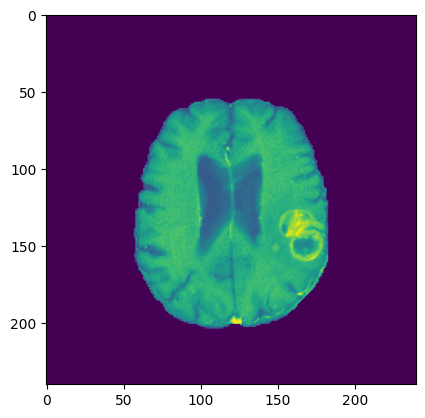

In [79]:
path_to_testing_tfr = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/all_pats_single_slice_rgb/sub-01551183/sub-01551183_2.tfrecord"
rgb = True

num_images = 5 # 4 sequences + 1 mask

image_shape = []

if rgb: # rgb images need three channels
    image_shape = [240, 240, 3, num_images]
else: # gray scale images don't
    image_shape = [240, 240, num_images]

feature_description = {
    "image": tf.io.FixedLenFeature(image_shape, tf.float32),
    "sex": tf.io.FixedLenFeature([], tf.int64, default_value=[0]),
    "age": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "layer": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "primary": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse(serialize_patient):
    example = tf.io.parse_single_example(serialize_patient, feature_description)
    # input = [example["image"], example["sex"], example["age"]]
    # label = example["primary"]
    image = example["image"]
    image = tf.reshape(image, image_shape) #[149, 185, 155, 4] = old size
    
    return image, example["sex"], example["age"], example["layer"], example["primary"]

dataset = tf.data.TFRecordDataset([path_to_testing_tfr], compression_type="GZIP")
parsed_dataset = dataset.map(parse)

test_image = parsed_dataset.take(1)
for image, sex, age, layer, primary in test_image:
    print(f"Sex: {sex.numpy()}")
    print(f"Age: {age.numpy()}")
    print(f"Layer: {layer.numpy()}")
    print(f"Primary: {primary.numpy()}")
    numpy_image = image.numpy()
    print(numpy_image.shape)
    # print max and min values
    print(f"Median value: {np.median(numpy_image)}")
    plt.imshow(numpy_image[:,:,2,1])

# sex
# m = 1, 0
# f = 0, 1

#### Get Min-Max of Age and Layer Number
Iterate over all patients to get the minimum and maximum value of the age and the layer number. This is important to normalize the values before training.

In [13]:
path_to_preprocessed_patients = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices")

def get_min_max_age_layer():

    patients = [patient for patient in os.listdir(path_to_preprocessed_patients) if os.path.isdir(os.path.join(path_to_preprocessed_patients, patient))]

    # write a check to compare patient_ids with patients
    patients = set(patients).intersection(patient_ids)

    ages = []
    layers = []
    
    # loop through patients
    for pat in tqdm(patients):

        leasions, leasion_layers = prepare_2d_rgb_images(pat, include_mask = False, only_cutout = False, save_as_rgb=False)

        for i in range(len(leasions)):

            age = int(list(training_patients[training_patients["participant_id"] == pat]["age"])[0])
            ages.append(age)

            layer = leasion_layers[i]
            layers.append(layer)
    
    return min(ages), max(ages), min(layers), max(layers)

In [15]:
min_age, max_age, min_layer, max_layer = get_min_max_age_layer()

print(f"Min age: {min_age}, Max age: {max_age}, Min layer: {min_layer}, Max layer: {max_layer}")

100%|██████████| 470/470 [00:02<00:00, 168.35it/s]

Min age: 25, Max age: 93, Min layer: 0, Max layer: 138


## Yale Dataset

In [3]:
path_to_yale_preprocessed_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/CIA metstobrain/yale_dataset_normalized")
path_to_met_slices = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/CIA metstobrain/yale_metastases")
path_to_yale_excel = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/CIA metstobrain/Pretreat-MetsToBrain-Masks_clin_20240410.xlsx")

In [6]:
yale_training_patients = pd.read_excel(path_to_yale_excel, sheet_name="Data")

yale_patient_ids = yale_training_patients["BraTS_MET_ID"].tolist()
print(yale_patient_ids)
print(len(yale_training_patients))

# preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

# for patient in preprocessed_patients:
#     if patient not in patient_ids:
#         print(patient)

[86, 89, 90, 96, 97, 98, 100, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 229, 230, 231, 232, 233, 234, 235, 237, 238, 239, 240, 241, 242, 243, 244, 245, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 258, 260, 262, 263, 264, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 285, 286, 288, 289, 290, 291, 292, 293, 294, 295, 296, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 309, 310]
200


### Unify primary classes

count different primaries that exist within the Yale Dataset. As one can see, most primaries belong to lung cancer (86 + 17 = 103), after that Melanoma (41), then Breast Cancer (26), Renal cell carcinoma (16) and lastly Gastrointestinal cancers (16).

In [9]:
# primaries are written like this: 1, 2, 3, 4, 5
# explanation:
# 1 = Breast cancer; 2 = Gastrointestinal cancers;
# 3 = Small cell lung cancer; 4 = Melanoma;
# 5 = Non small cell lung cancer; 6 = Renal cell carcinoma; 7 = Other

# given a certain amount of classes, e.g. 3:
# create the following classes: lung, melanoma, other
yale_primaries_array = yale_training_patients["Primary"]
print(yale_primaries_array.value_counts())

Primary
5    86
4    41
1    26
3    17
6    16
2    14
Name: count, dtype: int64


Next we'll merge the two lung categories into one, meaning we combine category number 3 and category number 5 and turn it into a new category, 0.

In [14]:
# replace each 5 and 3 in the yale_primaries_array with a 0

yale_primaries_array = yale_primaries_array.replace(5, 0)
yale_primaries_array = yale_primaries_array.replace(3, 0)

print(yale_primaries_array.value_counts())

Primary
0    103
4     41
1     26
6     16
2     14
Name: count, dtype: int64


In [35]:
yale_class_primaries = return_specific_primaries(yale_primaries_array, specific_classes = [1], dataset="Yale")

print(yale_class_primaries.value_counts())

Primary
1    103
0     97
Name: count, dtype: int64
Primary
1    103
0     97
Name: count, dtype: int64


In [36]:
labels = yale_class_primaries.to_numpy()

classes = np.array([1, 0])

weights = class_weight.compute_class_weight(class_weight="balanced",
                                            classes=classes,
                                            y=labels)

print(weights)

[0.97087379 1.03092784]


### One hot encode sex
The sex in the yale dataset is encoded as such:\
0 = Male; 1 = Female\
Then it's time to adjust the dataset accordingly:

In [40]:
yale_sex_array = yale_training_patients["Sex"]

print(yale_sex_array.value_counts())

# str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
# str_lookup_layer.adapt(sex_array)
# sex_tensors = str_lookup_layer(sex_array)

# sex_test = sex_tensors[0].numpy()
# print(sex_test)

yale_sex_encoded = []
for sex in yale_sex_array:
    if sex == 0: # Male
        yale_sex_encoded.append([1, 0])
    elif sex == 1: # Femal
        yale_sex_encoded.append([0, 1])
    else:
        print(f"unknown sex: {sex}")
        yale_sex_encoded.append([0, 0])

print(yale_sex_encoded)

Sex
1    125
0     75
Name: count, dtype: int64
[[0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1],

### Prepare Images for training

#### 3D images

In [132]:
def load_yale_patient(patientID):
    images = []
    # get all four sequences

    if patientID < 100:
        patientID = "0" + str(patientID)

    patientID = str(patientID)

    patients = os.listdir(path_to_yale_preprocessed_images)
    patient_folder_name = [patient for patient in patients if patientID in patient][0]
    patient_path = Path(patient_folder_name)

    image_names = [file for file in os.listdir(path_to_yale_preprocessed_images / patient_path) if "normalized" in file]
    
    # load them
    for name in image_names:
        path_to_image = path_to_yale_preprocessed_images / patient_path / Path(name)
        image = nib.load(path_to_image)
        data = image.get_fdata()
        #tensor = tf.convert_to_tensor(data, dtype = float)
        images.append(data)
    
    if len(images) != 4:
        print(f"Warning: either too many or too few images for {patientID} (#{len(images)})")
    
    # return four images as array
    return images


def rotate_90_deg_yale(images):
    """rotates images by 90 degrees"""
    # rotate images
    rotated_images = []
    for image in images:
        rotated_image = ndimage.rotate(np.array(image), angle = 90)
        #rotated_images.append(tf.convert_to_tensor(rotated_image, dtype = float))
        rotated_images.append(rotated_image)
    
    # return back
    return rotated_images

def merge_and_transpose_images_yale(images):
    """merge images so that the fourth dimension used for the different sequences"""
    # merge image
    stacked = tf.stack(images, axis = -1)

    new_order = [2, 0, 1, 3]
    transposed = np.transpose(stacked, axes=new_order)

    # rearranges the sequence to order to the only correct one: T1, T1c, T2, FLAIR
    yale_sequence_order = [0, 2, 3, 1]
    new_sequence_images = transposed[..., yale_sequence_order]

    # transposed = tf.transpose(stacked, perm = new_order)
    return new_sequence_images

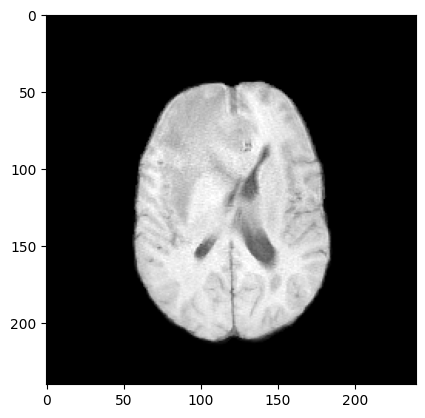

In [136]:
images = merge_and_transpose_images_yale(rotate_90_deg_yale(load_yale_patient(135)))
plt.imshow(images[80,:,:,0], cmap = "gray")

#### 2D images